# Perceptual Space of Singing Voices - Analysis

### This notebook runs through the analysis we performed on a dataset, provided by participants who were asked to rate dissimilarity between singing audio clips based on the timbral diversities of their singing techniques.

### The data is collected, screened, grouped by participant and experimental conditions, checked for normal distributions, underoges cluster, correlation and statistical analysis processes. These are accompanied with many visual examples, concluding with a multidimensional scalining to present timbral perceptual spaces on 2d planes for visual interpretation.

In [1]:
import h5py
import ast
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import random

import pandas as pd
import scipy.stats as stats

import clustering
import utils
from statistical_analysis import show_hist, cohend, custom_mann_whit_better, nonpara_multisample_stat_test
from statistical_analysis import normality_stat_test, normality_test_wrapper, array_column_correlations
from make_plots import display_dissim_heatmaps, summarize_cond_grouped_ratings_mds, mds_from_dissim_matrix

## Load h5 file, make a copy of it in RAM to analyze

In [2]:
run_once=True #this variable will be changed later to ensure certain cells can't be run again

In [3]:
h5_path = "anon_perceptual_dissimilarity_data.hdf5"

if 'h5' in globals():
    h5.close()

h5 = h5py.File(h5_path, mode = 'r+')

In [4]:
h5_ram = {}
for key in h5.keys():
    h5_ram[key] = h5[key][...]

### The 'participant_info' key of the h5_ram file contains the following information about the participant:
0. Their corresponding Xml file name (not publically available)
1. The session set they were given to evaluate
2. The date and 
3. time they participated
4. Email address (not publically available)
5. Listening Equipment (1-inbuilt speakers, 2-external speaker, 3-ear/headphones)
6. Listening Environment (1(very noisy) - 5 (very quiet))
7. Age
8. Gender
9. Gold-MSI 'Perceptual Abilities' Question 1 - see Mullensiefen (2014) for response types
10. Gold-MSI 'Perceptual Abilities' Question 2 - see Mullensiefen (2014) for response types
11. Gold-MSI 'Perceptual Abilities' Question 3 - see Mullensiefen (2014) for response types
12. Gold-MSI 'Perceptual Abilities' Question 4 - see Mullensiefen (2014) for response types
13. Gold-MSI 'Perceptual Abilities' Question 5 - see Mullensiefen (2014) for response types
14. Gold-MSI 'Perceptual Abilities' Question 6 - see Mullensiefen (2014) for response types
15. Gold-MSI 'Perceptual Abilities' Question 7 - see Mullensiefen (2014) for response types
16. Gold-MSI 'Perceptual Abilities' Question 8 - see Mullensiefen (2014) for response types
17. Gold-MSI 'Perceptual Abilities' Question 9 - see Mullensiefen (2014) for response types
18. Instrument (post-annotated with categorical information n=None, s=singer, other=musician)
19. Feedback (post-annotated with ordinal data 1-4 to reflect level of comprehension (5=not annotated))
20. Self-reported Impairments (1=no, 2=yes, 3=minor)
21. Time taken to complete study
22. Listening ability - Listening Equipment + Listening Environment
23. Total MSI-score
24. Ordinal Musician (derived from categorical post-annotated data from 18)
25. Task Comprehension (derived from ordinal post-annotated data from 19)
26. Reliability by self-similarity identification, reliability by repeated pages
27. Consistency (sum of squared errors between two identical test pages)
28. Neglected audio file (due to data collection error, ratings related to one particular audio file in each set were lost)

## Detect unreliable participant data using three methods

In [6]:
"""remove those with worst task comp scores (0)"""

comp_score_thresh = 0
unsatisfactory_part_indices = set()
for idx in range(len(h5_ram['participant_info'])):
    comp_score = h5_ram['participant_info'][idx][25]
    if int(comp_score) == comp_score_thresh:
        print('comprehension failed idx: ', idx)
        unsatisfactory_part_indices.add(idx)

"""remove those that could not identify same-audio clips within reason"""

same_audio_sim_threshold = 0.1
same_audio_sim_fail_thresh = 2
for idx in range(len(h5_ram['participant_info'])):
    diagonal_vals = h5_ram['participant_info'][idx][26]
#     print(diagonal_vals)
    diagonal_vals = utils.bytes_to_str(diagonal_vals)
    num_cells_above_threshold = len([val for val in ast.literal_eval(diagonal_vals) if val > same_audio_sim_threshold])
#     print(num_cells_above_threshold)
    if num_cells_above_threshold > same_audio_sim_fail_thresh:
        print('same-audio indentification failed idx: ', idx)
        unsatisfactory_part_indices.add(idx)


"""remove those that yielded higher rmse scores between repeated pages"""

rmse_thresh = 0.4
for idx in range(len(h5_ram['participant_info'])):
    rmse = h5_ram['participant_info'][idx][27]
    if float(rmse) > rmse_thresh:
        print('rmse failed idx: ', idx)
        unsatisfactory_part_indices.add(idx)
        

comprehension failed idx:  13
comprehension failed idx:  18
comprehension failed idx:  33
same-audio indentification failed idx:  51
same-audio indentification failed idx:  52
rmse failed idx:  10
rmse failed idx:  51


### Remove unrelaible entries from h5_ram dataset (only run this cell once)

In [7]:
if run_once:
    for key in h5_ram.keys():
        all_entries = h5_ram[key]
        num_entries = all_entries.shape[0]
        mask = np.ones(num_entries, dtype=bool)
        mask[list(unsatisfactory_part_indices)] = False
        filtered_entries = np.asarray(all_entries)[mask, ...]
        h5_ram[key] = filtered_entries
else:
    raise Exception('Error. Do not run this cell a second time without restarting the kernel')
    
run_once = False

### Declare list variables

In [8]:
# Make this variable false to avoid displaying graphs
num_experiments = len(h5_ram['participantRatings'])
save_plot = False
sig_thresh = 0.05

session_cond_names = ['m1low','m2low','m4low','m1high','m2high','m4high',
                 'f2low','f3low','f5low','f2high','f3high','f5high']
singer_cond_names = ['m1','m2','m4','f2','f3','f5']
register_cond_names = ['low','high']
gender_cond_names = ['male','female']
reg_gen_cond_names = register_cond_names + gender_cond_names

label_list = ['straight','belt','breathy','fry','vibrato']
label_class_dict = {'straight':0,'belt':1,'breathy':2,'fry':3,'vibrato':4}
class_pairs = list(itertools.combinations(label_class_dict.values(), 2))
class_pairs.extend(((0,0), (1,1), (2,2), (3,3), (4,4)))

## Create lists of indices based on condition groups

In [9]:
# Collect participant indices for each condition and each group in lists (first 4 are lists, next 4 are arrays)

indices_for_low_sessions = utils.indices_by_key_value(h5_ram, 'participant_info', 1, 'low')
indices_for_high_sessions = utils.indices_by_key_value(h5_ram, 'participant_info', 1, 'high')
indices_for_male_sessions = utils.indices_by_key_value(h5_ram, 'participant_info', 1, 'm')
indices_for_female_sessions = utils.indices_by_key_value(h5_ram, 'participant_info', 1, 'f')

indices_for_low_male_session = np.setdiff1d(indices_for_male_sessions, indices_for_high_sessions)
indices_for_high_male_session = np.setdiff1d(indices_for_male_sessions, indices_for_low_sessions)
indices_for_low_female_session = np.setdiff1d(indices_for_female_sessions, indices_for_high_sessions)
indices_for_high_female_session = np.setdiff1d(indices_for_female_sessions, indices_for_low_sessions)

In [10]:
# Combine index lists for same variable types (all lists)

indices_grouped_by_session = []
for session in session_cond_names:
    indices_for_specific_session = utils.indices_by_key_value(h5_ram, 'participant_info', 1, session)
    indices_grouped_by_session.append(indices_for_specific_session)

    
indices_grouped_by_singer = []
for singer in singer_cond_names:
    indices_for_specific_singer = utils.indices_by_key_value(h5_ram, 'participant_info', 1, singer)
    indices_grouped_by_singer.append(indices_for_specific_singer)
    
indices_grouped_by_register = [indices_for_low_sessions, indices_for_high_sessions]
indices_grouped_by_gender = [indices_for_male_sessions, indices_for_female_sessions]


indices_grouped_by_condition_groups = [indices_grouped_by_session, indices_grouped_by_singer,
                                         indices_grouped_by_register, indices_grouped_by_gender]

indices_grouped_individually = [[i] for i in range(60)]

# Group Ratings by conditions

In [11]:
print_monitor=False
intra_session_ratings = utils.class_rating_distributions(h5_ram, indices_grouped_by_session,
                                                   class_pairs, session_cond_names, 'intra_session_distributions',
                                                   show_plot=False, print_monitor=print_monitor)
intra_singer_ratings = utils.class_rating_distributions(h5_ram, indices_grouped_by_singer,
                                                  class_pairs, singer_cond_names, 'intra_singer_distributions',
                                                   show_plot=False, print_monitor=print_monitor)
intra_register_ratings = utils.class_rating_distributions(h5_ram, indices_grouped_by_register,
                                                    class_pairs, register_cond_names, 'intra_register_distributions',
                                                   show_plot=False, print_monitor=print_monitor)
intra_gender_ratings = utils.class_rating_distributions(h5_ram, indices_grouped_by_gender,
                                                  class_pairs, gender_cond_names, 'intra_gender_distributions',
                                                   show_plot=False, print_monitor=print_monitor)

/Users/brendanoconnor/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [12]:
rating_groups = [intra_session_ratings,
                 intra_singer_ratings,
                 intra_register_ratings,
                 intra_gender_ratings]

group_names = ['intra_session_ratings',
                 'intra_singer_ratings',
                 'intra_register_ratings',
                 'intra_gender_ratings']

condition_names = [session_cond_names,
                   singer_cond_names,
                   register_cond_names,
                   gender_cond_names]

### Intra-condition ratings contain all ratings for a given condition. However, the final grouping of these ratings is based on class pairs. So the first entry for these lists will relate to class pair (0,1), the second to (0,2) etc.

In [13]:
print('num class pairs:', len(intra_session_ratings))
print('num conditions (sessions, gender or singer):', len(intra_session_ratings[0]))
print('num relevant experiments for each condition:', len(intra_session_ratings[0][0]))
print('num class_pair ratings per experiment:', len(intra_session_ratings[0][0][0]))

num class pairs: 15
num conditions (sessions, gender or singer): 12
num relevant experiments for each condition: 6
num class_pair ratings per experiment: 6


### Calculate average distances using nested dicts for class pairs

In [14]:
directory_name = 'average_class_distance_distributions'
averaged_groups = {}

for rating_group_idx, rating_group in enumerate(rating_groups):
    
    if rating_group_idx < 2: # ignore first 2 condition groups as we are not interested in these
        continue
    
    group_dict_by_class = {}
    
    for class_group_idx, class_group in enumerate(rating_group):
        # get the average of all the distances for each condition of each class of each group  
        averages_dict_by_condition = {}
        
        for condition_group_idx, condition_group in enumerate(class_group):
            # convert multiple scores for each participant into a single average for them
            participant_averages = []
            
            for part_idx, participant in enumerate(condition_group):

                num_ratings = len(participant)
                average = sum(participant)/len(participant)
                participant_averages.append(average)

            if False:
                plt.hist(participant_averages, bins=10)
                os.makedirs(directory_name, exist_ok=True)
                title ='Group {0}, Condition {2}, Class pair {1}, Averages Distribution'.format(
                    rating_group_idx,
                    class_pairs[class_group_idx],
                    condition_group_idx
                )
                
                # plt.title(title)
                plt.tight_layout()
                if save_plot:
                    plt.savefig(directory_name +'/' +title)
                plt.show()
                plt.close() 
            

            averages_dict_by_condition[condition_names[rating_group_idx][condition_group_idx]] = participant_averages
                
        # add this class to the group for this rating groups
        group_dict_by_class[class_pairs[class_group_idx]] = averages_dict_by_condition
        
    averaged_groups[group_names[rating_group_idx]] = group_dict_by_class
    

### Plot distribution of ratings per participant to show how frequently they used certain ratings - only useful for analyzing indivuals behaviour

In [15]:
square_matrix_dim = len(h5_ram['dissim_matrix'][0])
flattened_participant_ratings_list = []
directory_name = 'participant_rating_distributions'
for experiment_idx in range(num_experiments):
    dissim_matrix = h5_ram['dissim_matrix'][experiment_idx]
    flattened_dissim_matrix = dissim_matrix.flatten()
    flattened_participant_ratings_list.append(flattened_dissim_matrix)
    if False:
        plt.hist(flattened_dissim_matrix, bins=15)
        os.makedirs(directory_name, exist_ok=True)
        title ='Experiment_idx {0} ratings'.format(experiment_idx)
        # plt.title(title)
        plt.tight_layout()
        if save_plot:
            plt.savefig(directory_name +'/' +'Experiment_idx {0} ratings'.format(experiment_idx))
        plt.show()
        plt.close()

### Example of some dissimilarity ratings

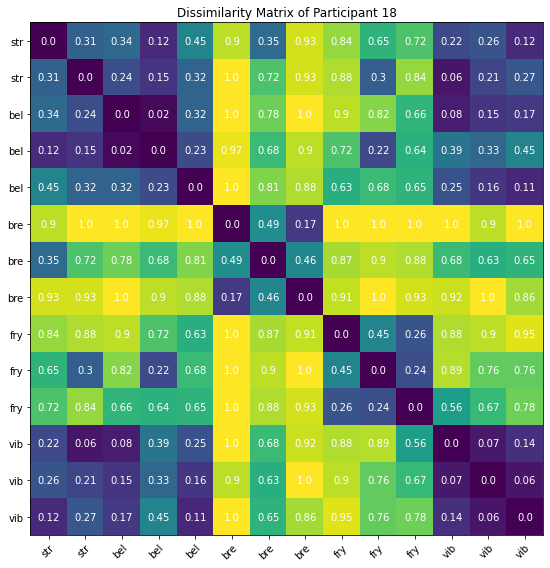

In [16]:
random_ints = [random.randint(0, num_experiments) for _ in range(1)]
random_ints = [18]
for r_idx in random_ints:
    dissim_matrix = h5_ram['dissim_matrix'][r_idx]
    ref_auds = h5_ram['referenceAudioNames'][r_idx]
    display_dissim_heatmaps(dissim_matrix, ref_auds, r_idx, save_plot=True)

### Plot Distribution For Ratings Across All Participants - purely out of interest not analytical use

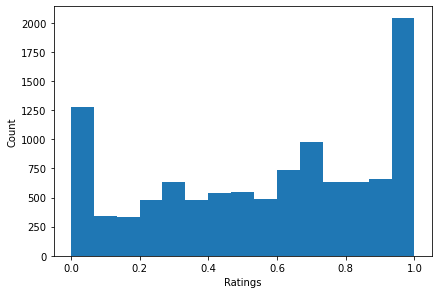

In [17]:
# histogram representation used to represent continous data distribution
flattened_flattened_participant_ratings_list = [rating
                                                for participant in flattened_participant_ratings_list
                                                for rating in participant]
plt.hist(flattened_flattened_participant_ratings_list, bins=15)
os.makedirs(directory_name, exist_ok=True)
title ='All Participant Ratings Distribution'
# # plt.title(title)
plt.tight_layout()
plt.xlabel('Ratings')
plt.ylabel('Count')
if True:
    plt.savefig(directory_name +'/' +'All Participant Ratings')
plt.show()
plt.close()

## Generate a profile array of features containing participant information that has been converted to ordinal data

In [18]:
# Go through participant's info and add relevant data to profile_array
total_features = 7
profile_array = np.empty((0,total_features))

profile_label_names = ['Hearing Impairments',
                 'Listen Ability',
                 'Instrumentation',
                 'MSI score',
                 'Task Comprehension Level',
                 'Identity Recognition',
                 'Poor Repetition'
                ]

profile_label_dict = {'Hearing Impairments':('Hearing Impairments',('None','Not significant')),
                 'Listen Ability':('Score',('4','5','6','7','8')),
                 'Instrumentation':('Musical Category',('Non-musician','Musician','Singer')),
                 'MSI score':('Score',()),
                 'Task Comprehension Level':('Task Comprehension Level',('1','2','3','4','5')),
                 'Identity Recognition':('Score',()),
                 'Poor Repetition':('Score',())
                 }

for i in range(num_experiments):
    p = h5_ram['participant_info'][i]
    row = np.array([p[20], #hearImpairments
                    p[22], #listening_ability
                    p[24], #musician_category
                    round(float(p[23]), 2), #msi_score
                    p[25], #task comprehension
                    p[26], #similarity identification (zero_error)
                    round(float(p[27]), 2)])#consistency
    row = row.reshape(-1, total_features)
    profile_array = np.append(profile_array, row, axis=0)

#### Generate distributions across all participatns for each profile feature

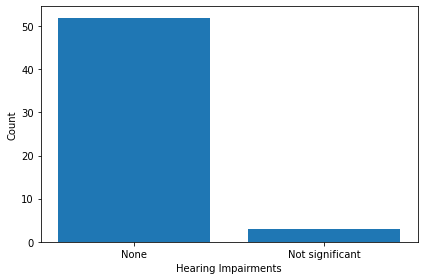

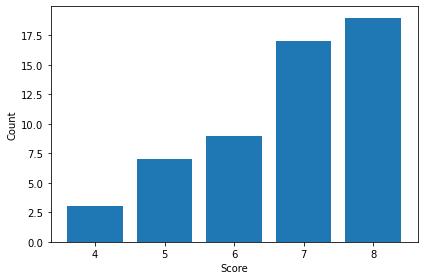

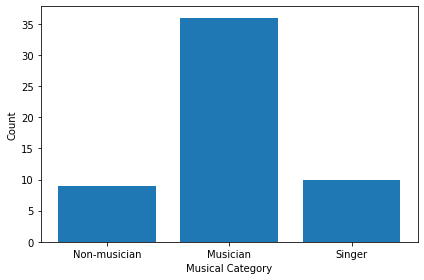

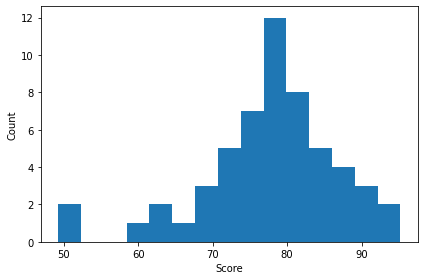

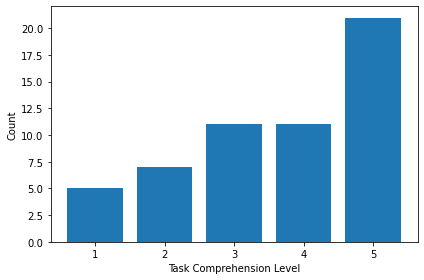

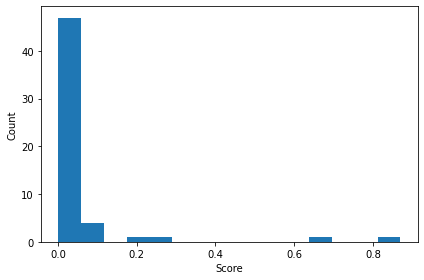

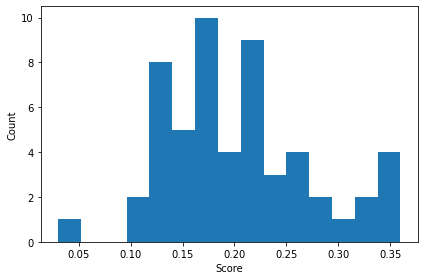

In [19]:
# Each column in the profile array represents a different profile feature (see list above)

directory_name = 'participant_profile_distributions'
for i in range(profile_array.shape[1]):
    profile_feature_list = []
    for experiment_idx in range(num_experiments):
        if i == 5: # if similarity misenditification (zero error)
            # a list saved as a string-byte - convert to string, then to literal list
            profile_array_i_string = profile_array[experiment_idx][i]
            profile_array_i_string = utils.bytes_to_str(profile_array_i_string)
            corrected_list = ast.literal_eval(profile_array_i_string)
            profile_feature_list.append(sum(corrected_list))
            
        else:
            profile_feature_list.append(float(profile_array[experiment_idx][i]))
    unique_values = list(set(profile_feature_list))
    value_counts = [profile_feature_list.count(value) for value in unique_values]


    # decide whether bar/hist for discrete/continuous data
    if i < 3 or i == 4: # if i = 0,1,2,4
        plt.bar(profile_label_dict[profile_label_names[i]][1], value_counts)
        rep_type = 'bar graph'
    else:
        plt.hist(profile_feature_list, bins=15)
        rep_type = 'distribution'
        
    os.makedirs(directory_name, exist_ok=True)
    title =f'Participant {profile_label_names[i]} {rep_type}'
    plt.xlabel(profile_label_dict[profile_label_names[i]][0])
    plt.ylabel('Count')
#     # plt.title(title)
    plt.tight_layout()
    if True:
        plt.savefig(directory_name +'/' +title)
    plt.show()
    plt.close()

### Plot stacked histogram of ages across all participants

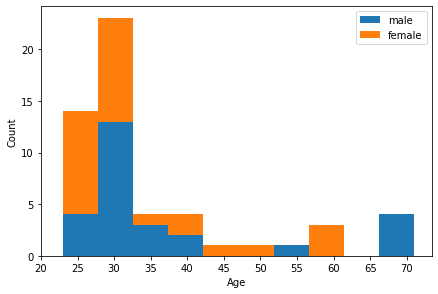

Participant age mean = 35.30909090909091, std = 12.907887267830018.


In [20]:
ages = []
male_ages=[]
female_ages=[]
for experiment_idx in range(num_experiments):
    # ages.append(int(h5_ram['participant_info'][experiment_idx][7]))
    gender_indicator = h5_ram['participant_info'][experiment_idx][8]
    gender_indicator = utils.bytes_to_str(gender_indicator) 
    if gender_indicator == 'm':
        gender = 0
        male_ages.append(int(h5_ram['participant_info'][experiment_idx][7]))
    elif gender_indicator=='f':
        gender = 1
        female_ages.append(int(h5_ram['participant_info'][experiment_idx][7]))
    else:
        raise NotImplementedError

    
plt.hist([male_ages, female_ages], stacked=True, bins=10)
os.makedirs(directory_name, exist_ok=True)
title ='Age distribution'
# # plt.title(title)
plt.tight_layout()
plt.xticks(range(20, 75, 5))
labels = ['male', 'female']
plt.legend(labels)
plt.xlabel('Age')
plt.ylabel('Count')
if True:
    plt.savefig(directory_name +'/' +'Distribution of Ages')
plt.show()
plt.close()

male_ages_array = np.asarray(male_ages)
female_ages_array = np.asarray(female_ages)
all_ages = np.concatenate((male_ages_array, female_ages_array))
print('Participant age mean = {0}, std = {1}.'.format(np.mean(all_ages), np.std(all_ages)))

### Plot stacked bar graph of musician abilities across all participants

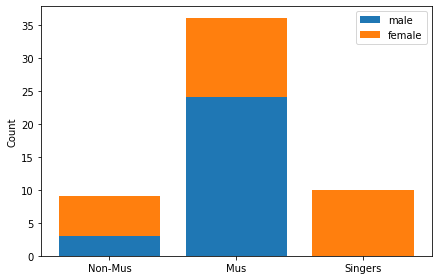

In [21]:
# PLOT GRAPH OF THE THREE CATEGORIES OF INSTRUMENTAL ABILITY USED IN THIS STUDY
men_non_mus = 0
men_mus = 0
men_singer_mus= 0
women_non_mus = 0
women_mus = 0
women_singer_mus= 0
N = 3
ind = np.arange(N)
for experiment_idx in range(num_experiments):
    music_cat_indicator = h5_ram['participant_info'][experiment_idx][24]
    music_cat_indicator = utils.bytes_to_str(music_cat_indicator)
    gender_indicator = h5_ram['participant_info'][experiment_idx][8]
    gender_indicator = utils.bytes_to_str(gender_indicator)
    if music_cat_indicator == '0':
        if gender_indicator == 'm':
            men_non_mus += 1
        else:
            women_non_mus +=1
    elif music_cat_indicator == '1':
        if gender_indicator == 'm':
            men_mus += 1
        else:
            women_mus +=1
    elif music_cat_indicator == '2':
        if gender_indicator == 'm':
            men_singer_mus += 1
        else:
            women_singer_mus +=1

p1 = plt.bar(ind, (men_non_mus, men_mus, men_singer_mus))
p2 = plt.bar(ind, (women_non_mus, women_mus, women_singer_mus), bottom=(men_non_mus, men_mus, men_singer_mus))
os.makedirs(directory_name, exist_ok=True)
title ='Instrumental Ability'
# # plt.title(title)
plt.xticks(ind, ('Non-Mus', 'Mus', 'Singers'))
plt.tight_layout()
plt.ylabel('Count')
labels = ['male', 'female']
plt.legend((p1[0], p2[0]), ('male', 'female'))
if True:
    plt.savefig(directory_name +'/' +'Instrumental Ability')
plt.show()
plt.close()

# ANALYSIS SECTION

## Clustering Analysis

In [22]:
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

In [23]:
all_indices = np.arange(num_experiments)
k_range = range(2,14)

In [24]:
cluster_metric_types = [
    'km_sil_scores',
    'km_acc_scores',
    'agg_sil_scores',
    'agg_acc_scores'
]

### Show 'Best k-value' distribution across all participants

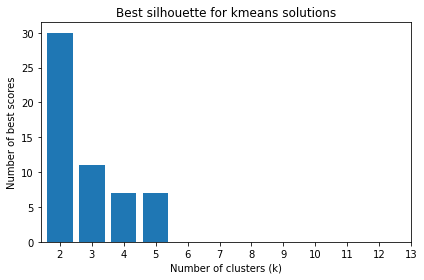

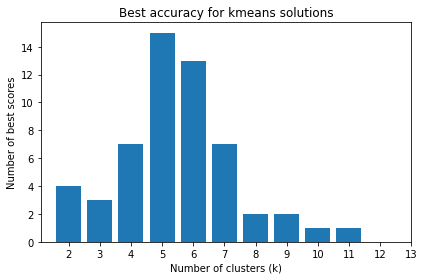

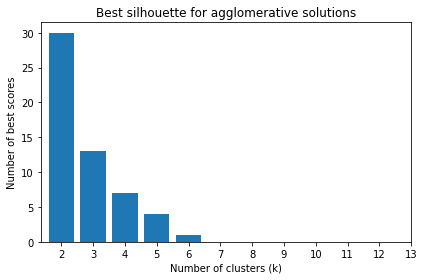

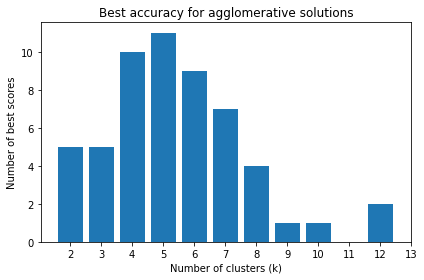

In [25]:
k_range = range(2,14)
km_sil_scores, best_kmeans_sil_ks = clustering.find_best_k_values(h5=h5_ram,
                                                         indices=all_indices,
                                                         condition_name='all_data',
                                                         k=k_range,
                                                         cluster_algorithm='kmeans',
                                                         score_type='silhouette',
                                                         show_plot=True,
                                                         save_plot=True)
km_acc_scores, best_kmeans_acc_ks = clustering.find_best_k_values(h5=h5_ram,
                                                         indices=all_indices,
                                                         condition_name='all_data',
                                                         k=k_range,
                                                         cluster_algorithm='kmeans',
                                                         score_type='accuracy',
                                                         show_plot=True,
                                                         save_plot=True)
agg_sil_scores, best_agg_sil_ks = clustering.find_best_k_values(h5=h5_ram,
                                                         indices=all_indices,
                                                         condition_name='all_data',
                                                         k=k_range,
                                                         cluster_algorithm='agglomerative',
                                                         score_type='silhouette',
                                                         show_plot=True,
                                                         save_plot=True)
agg_acc_scores, best_agg_acc_ks = clustering.find_best_k_values(h5=h5_ram,
                                                         indices=all_indices,
                                                         condition_name='all_data',
                                                         k=k_range,
                                                         cluster_algorithm='agglomerative',
                                                         score_type='accuracy',
                                                         show_plot=True,
                                                         save_plot=True)

### Correlation between clustering scores for diff algorithms

Size of sample is 55


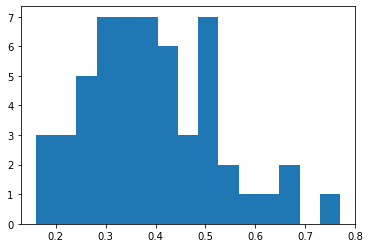

variable: km_sil , condition name: all , - NORMAL DISTRIBUTION
Size of sample is 55


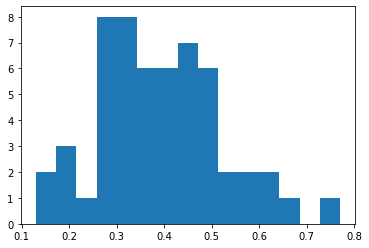

variable: agg_sil , condition name: all , - NORMAL DISTRIBUTION
Size of sample is 55


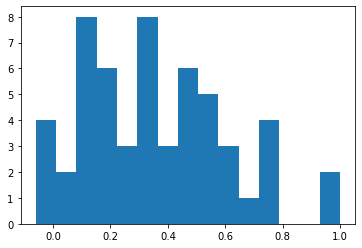

variable: km_acc , condition name: all , - NORMAL DISTRIBUTION
Size of sample is 55


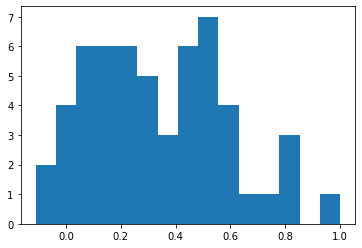

variable: agg_acc , condition name: all , - NORMAL DISTRIBUTION


In [26]:
cluster_algorithms_sil = np.concatenate((km_sil_scores.reshape(-1,1), agg_sil_scores.reshape(-1,1)), axis=1)
data = cluster_algorithms_sil[:,0]
normality_test_wrapper([data], ['all'], 'km_sil')
data = cluster_algorithms_sil[:,1]
normality_test_wrapper([data], ['all'], 'agg_sil')

cluster_algorithms_acc = np.concatenate((km_acc_scores.reshape(-1,1), agg_acc_scores.reshape(-1,1)), axis=1)
data = cluster_algorithms_acc[:,0]
normality_test_wrapper([data], ['all'], 'km_acc')
data = cluster_algorithms_acc[:,1]
normality_test_wrapper([data], ['all'], 'agg_acc')

('silhoutte', 'silhouette', 0.99, 7.573838875657446e-48)


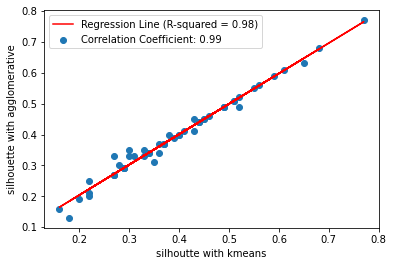

('accuracy', 'accuracy', 0.96, 3.359004479537622e-32)


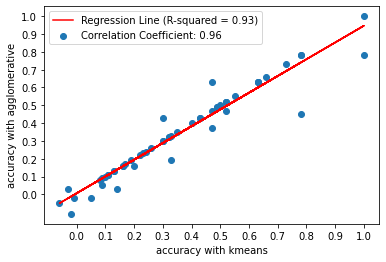

In [27]:
cluster_corr_dict, cluster_corr_list = array_column_correlations(
    cluster_algorithms_sil,
#     [cluster_metric_types[0], cluster_metric_types[2]],
    ['silhoutte with kmeans', 'silhouette with agglomerative'],
    profile_label_dict,
    0.05,
    'pearsonr',
    show_plot=True,
    save_plot=True)

cluster_corr_dict, cluster_corr_list = array_column_correlations(
    cluster_algorithms_acc,
#     [cluster_metric_types[1], cluster_metric_types[3]],
    ['accuracy with kmeans', 'accuracy with agglomerative'],
    profile_label_dict,
    0.05,
    'pearsonr',
    show_plot=True,
    save_plot=True)

As km and agg are so similar in results, only one of them was retained to reduce comparative data. Agglomerative metrics were kept as this is the more deterministic algorithm of the two

## The following cell analyses similarity between participants.

The results are underwhelming, where there are very little values in the meta dissim matrix that reveal strong correlation between datapoints. However, we do not have a frame of reference as to how linear or relevant these correlation values should be to reflect a suitable amount of similarity, or conversely, a suitable tolerance for dissimilarity.

In [28]:
# collect all matrices as flattened vectors
# ratings_grouped_by_session = np.empty((0,225))

ratings_idxs_grouped_by_session = [[] for i in range(len(session_cond_names))]
for s_idx, s_id in enumerate(session_cond_names):
    for idx in range(num_experiments):
        sesh_name = utils.bytes_to_str(h5_ram['participant_info'][idx][1])
#         print(sesh_name[:3], s_id[:3])
        if sesh_name[:3] == s_id[:3]:
            rearranged_dissim_matrix = h5_ram['dissim_matrix_dim15'][idx]
            flattened_dissim_matrix = rearranged_dissim_matrix.flatten()
            flattened_dissim_matrix = flattened_dissim_matrix.reshape(-1, len(flattened_dissim_matrix))
            ratings_idxs_grouped_by_session[s_idx].append((flattened_dissim_matrix, idx))

m1low
[7, 19, 21, 32, 37, 46]


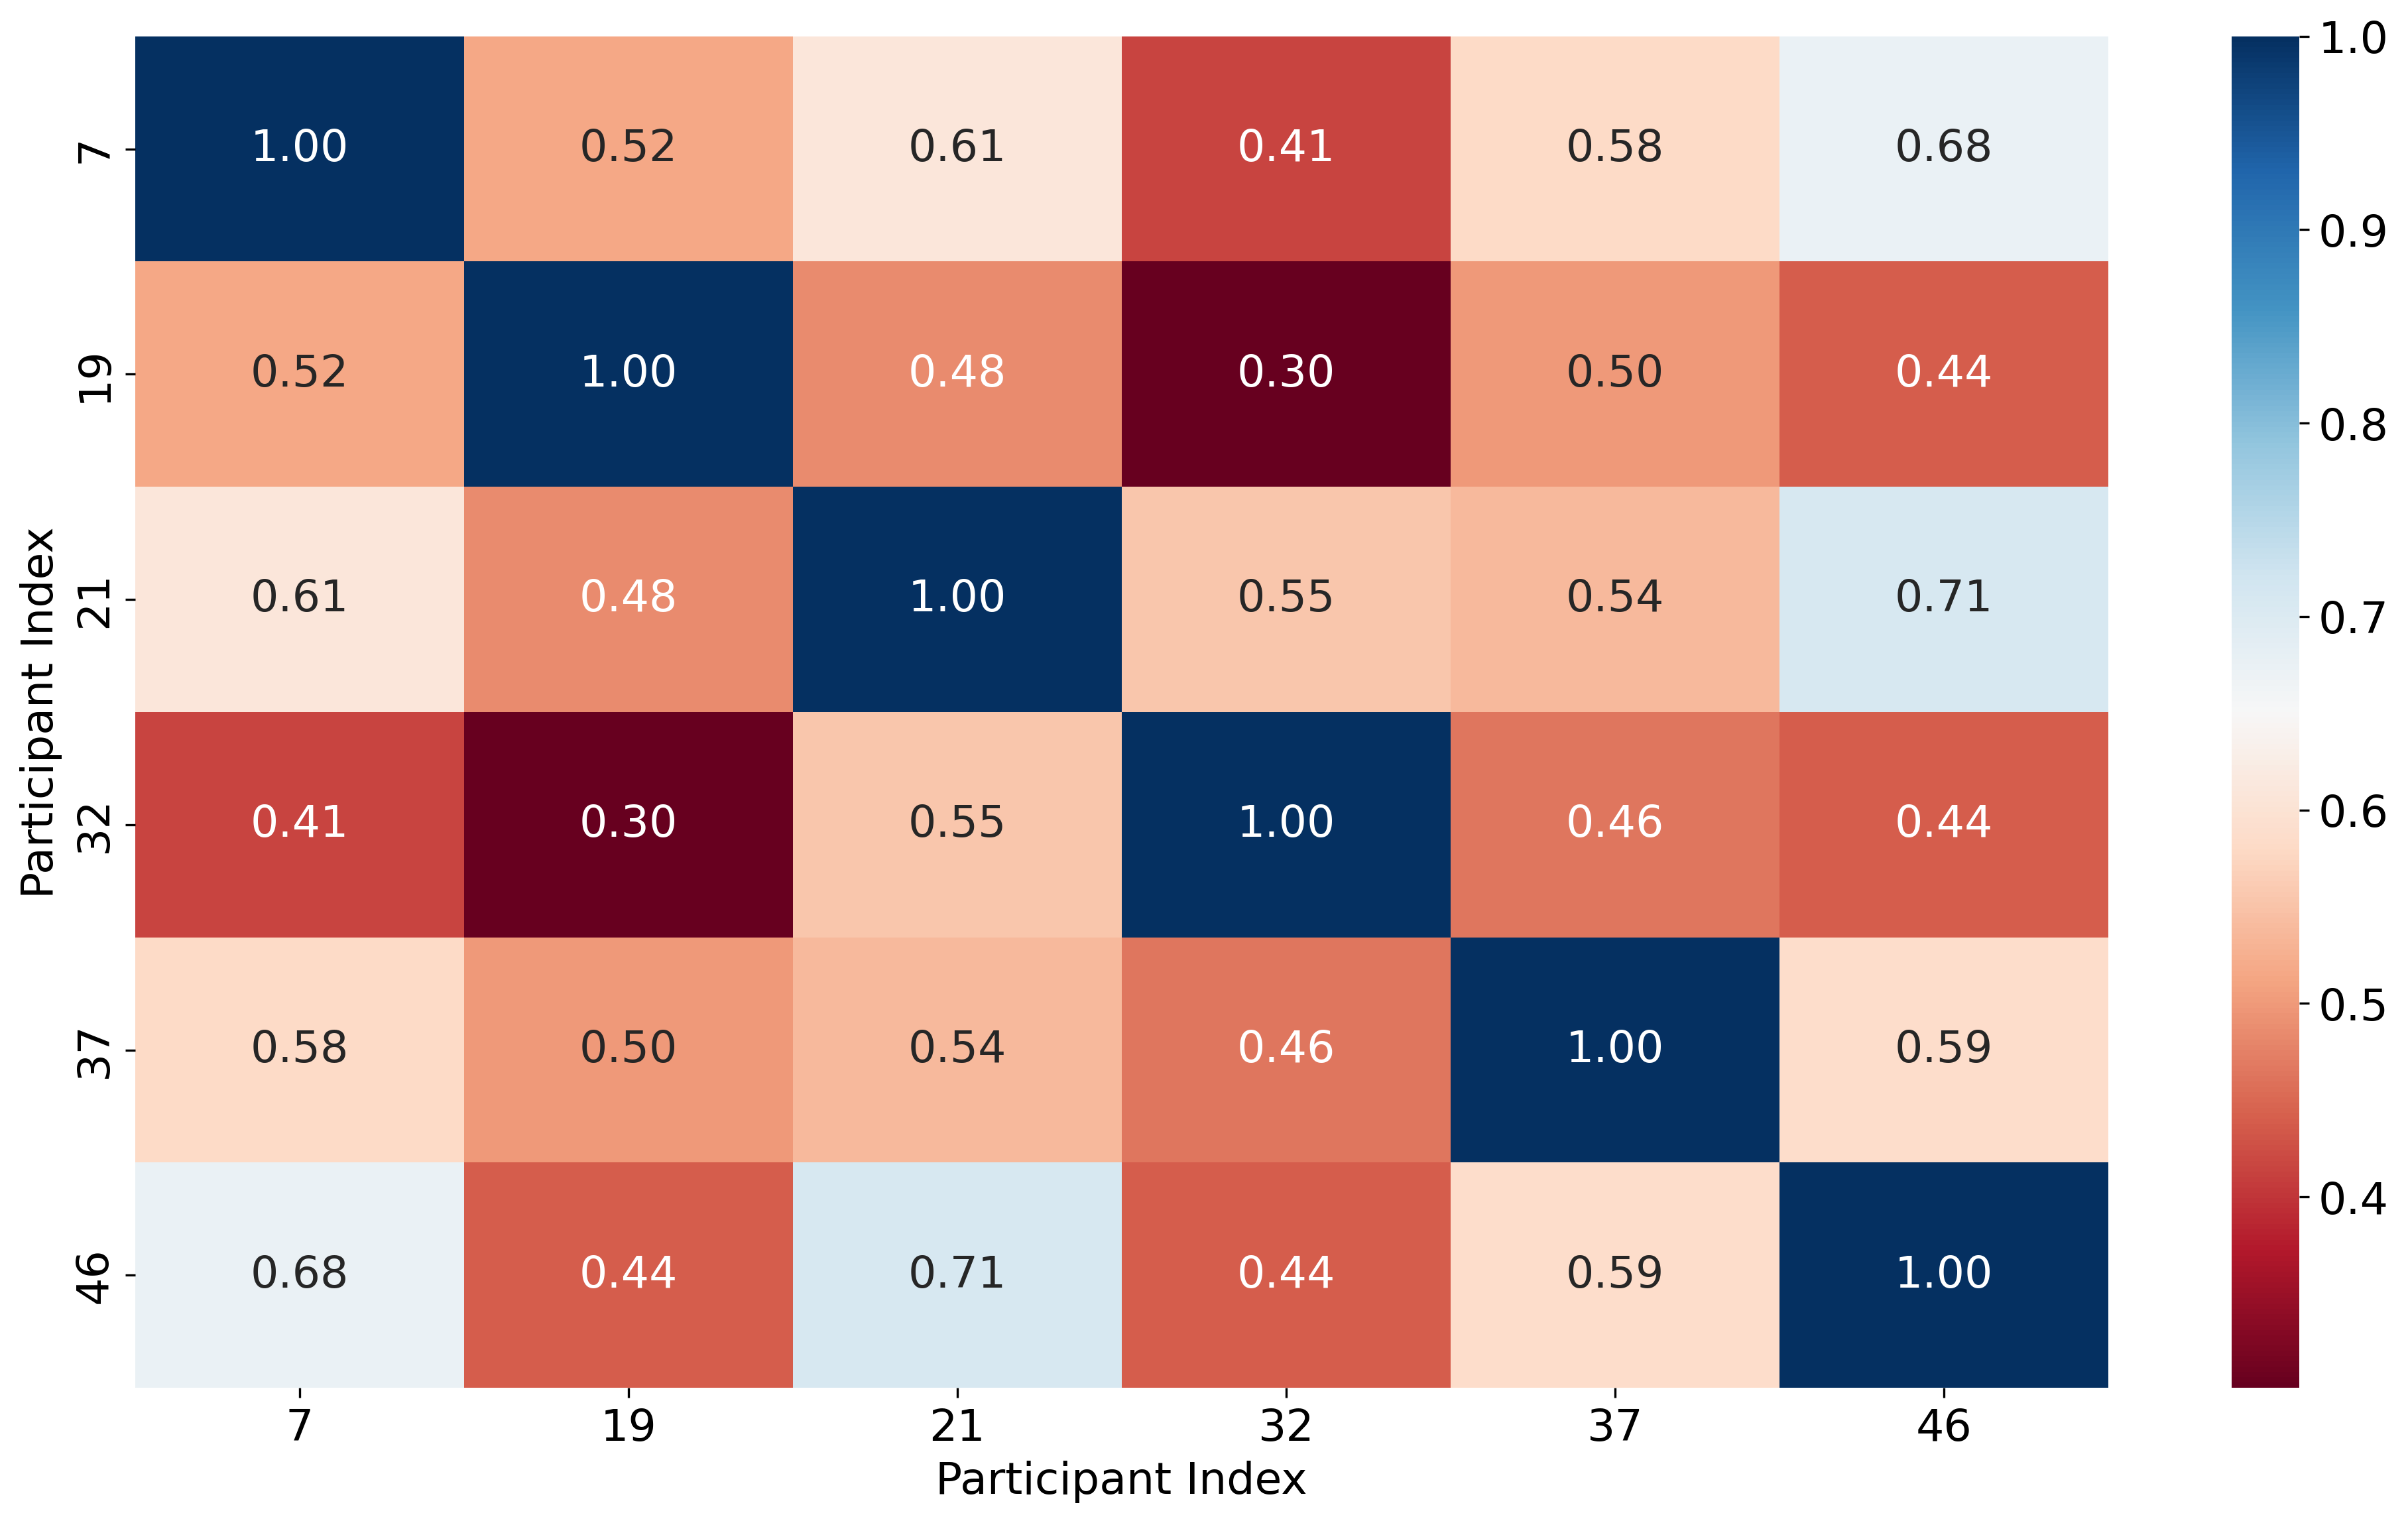

m2low
[12, 31, 34]


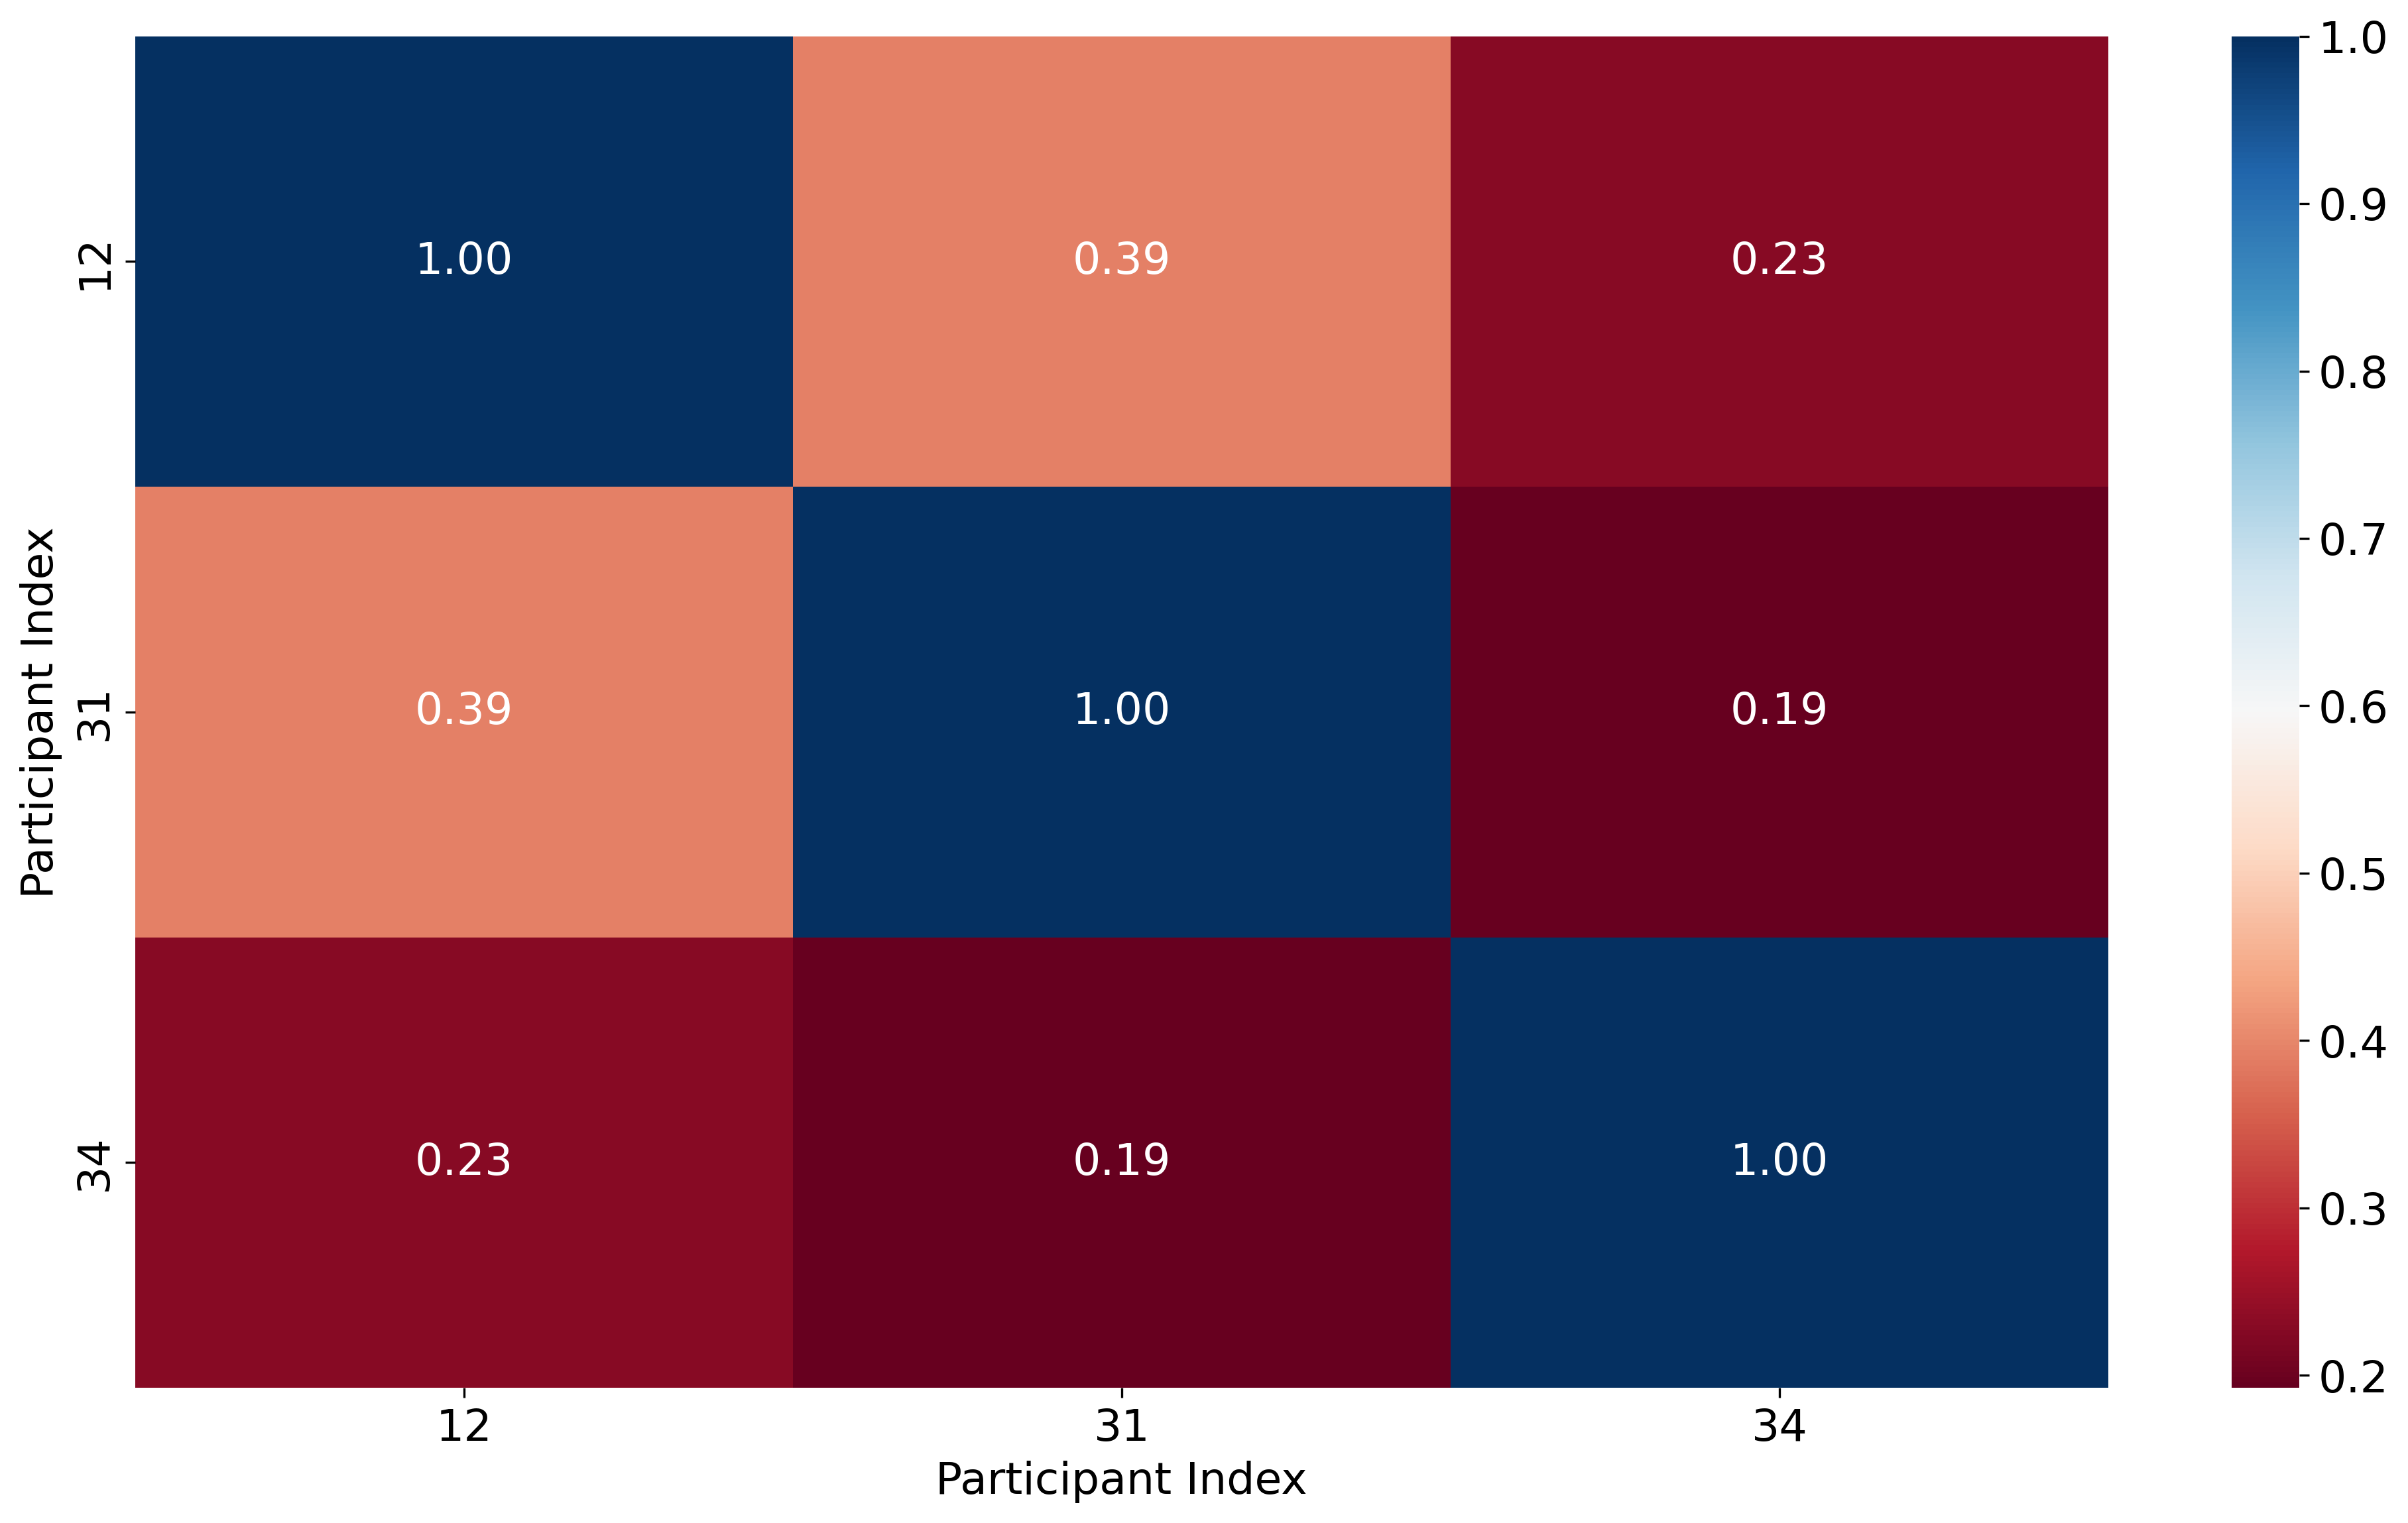

m4low
[1, 15, 42, 48, 49]


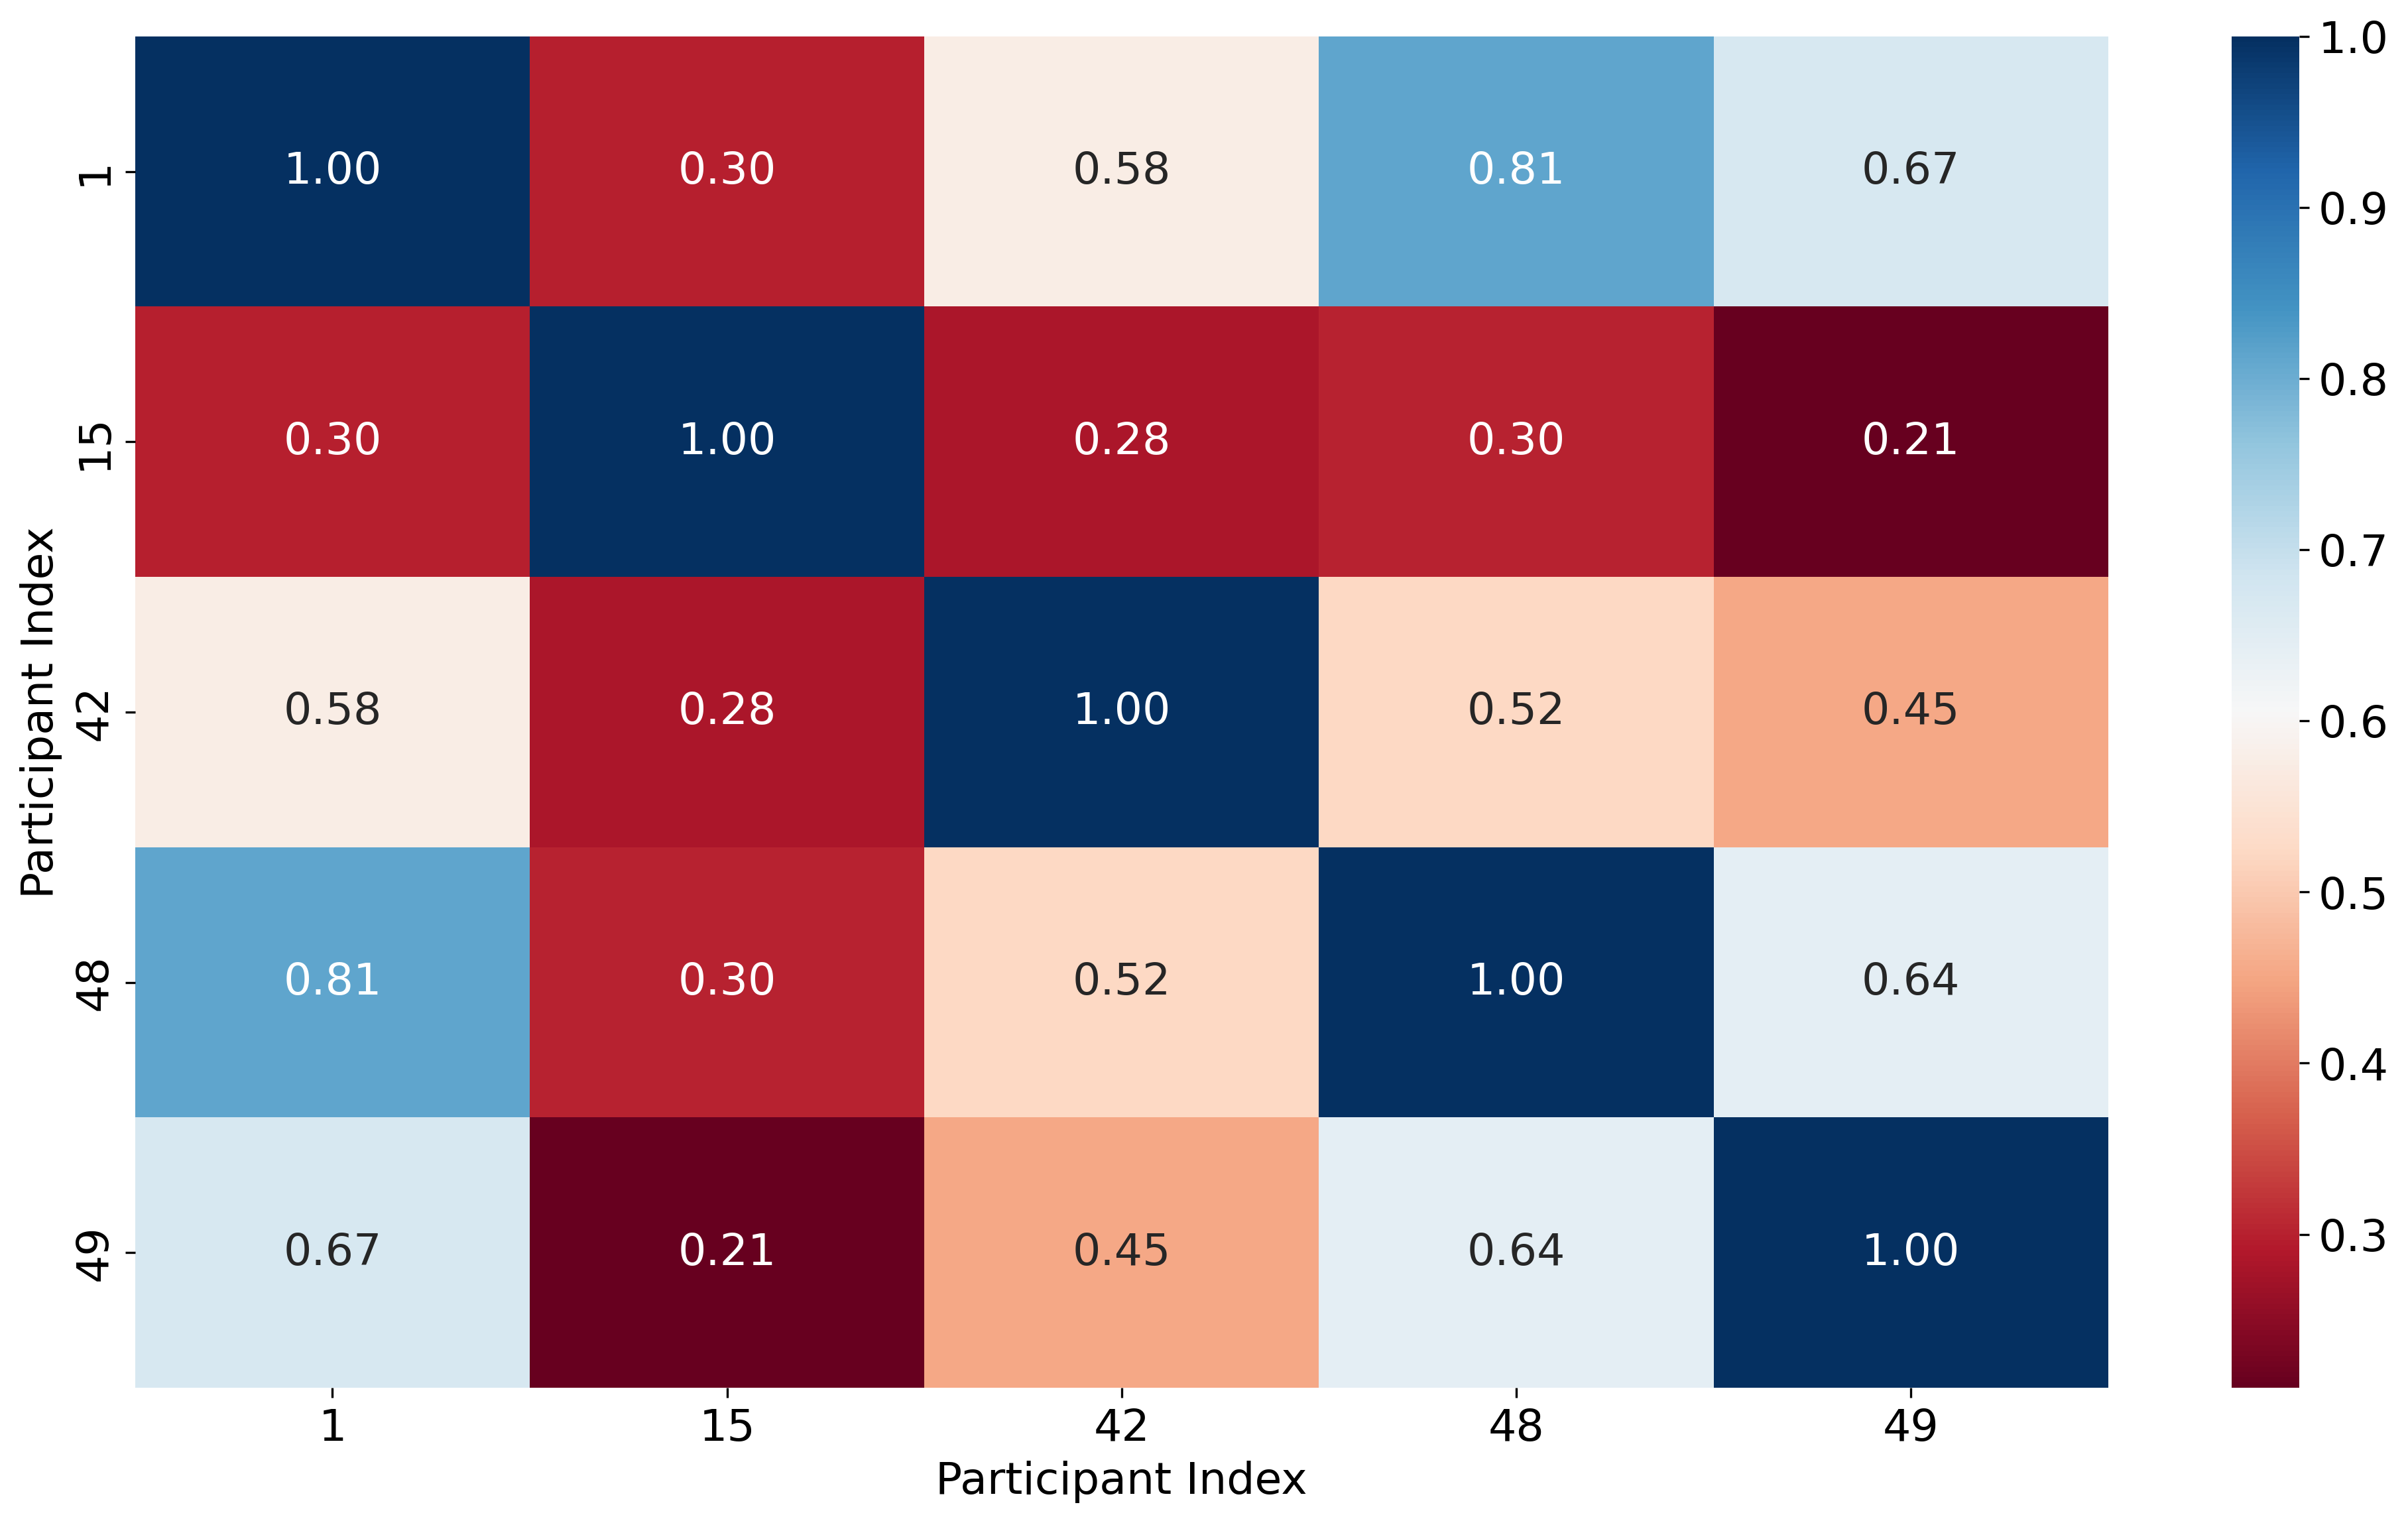

m1high
[10, 17, 23, 28, 50]


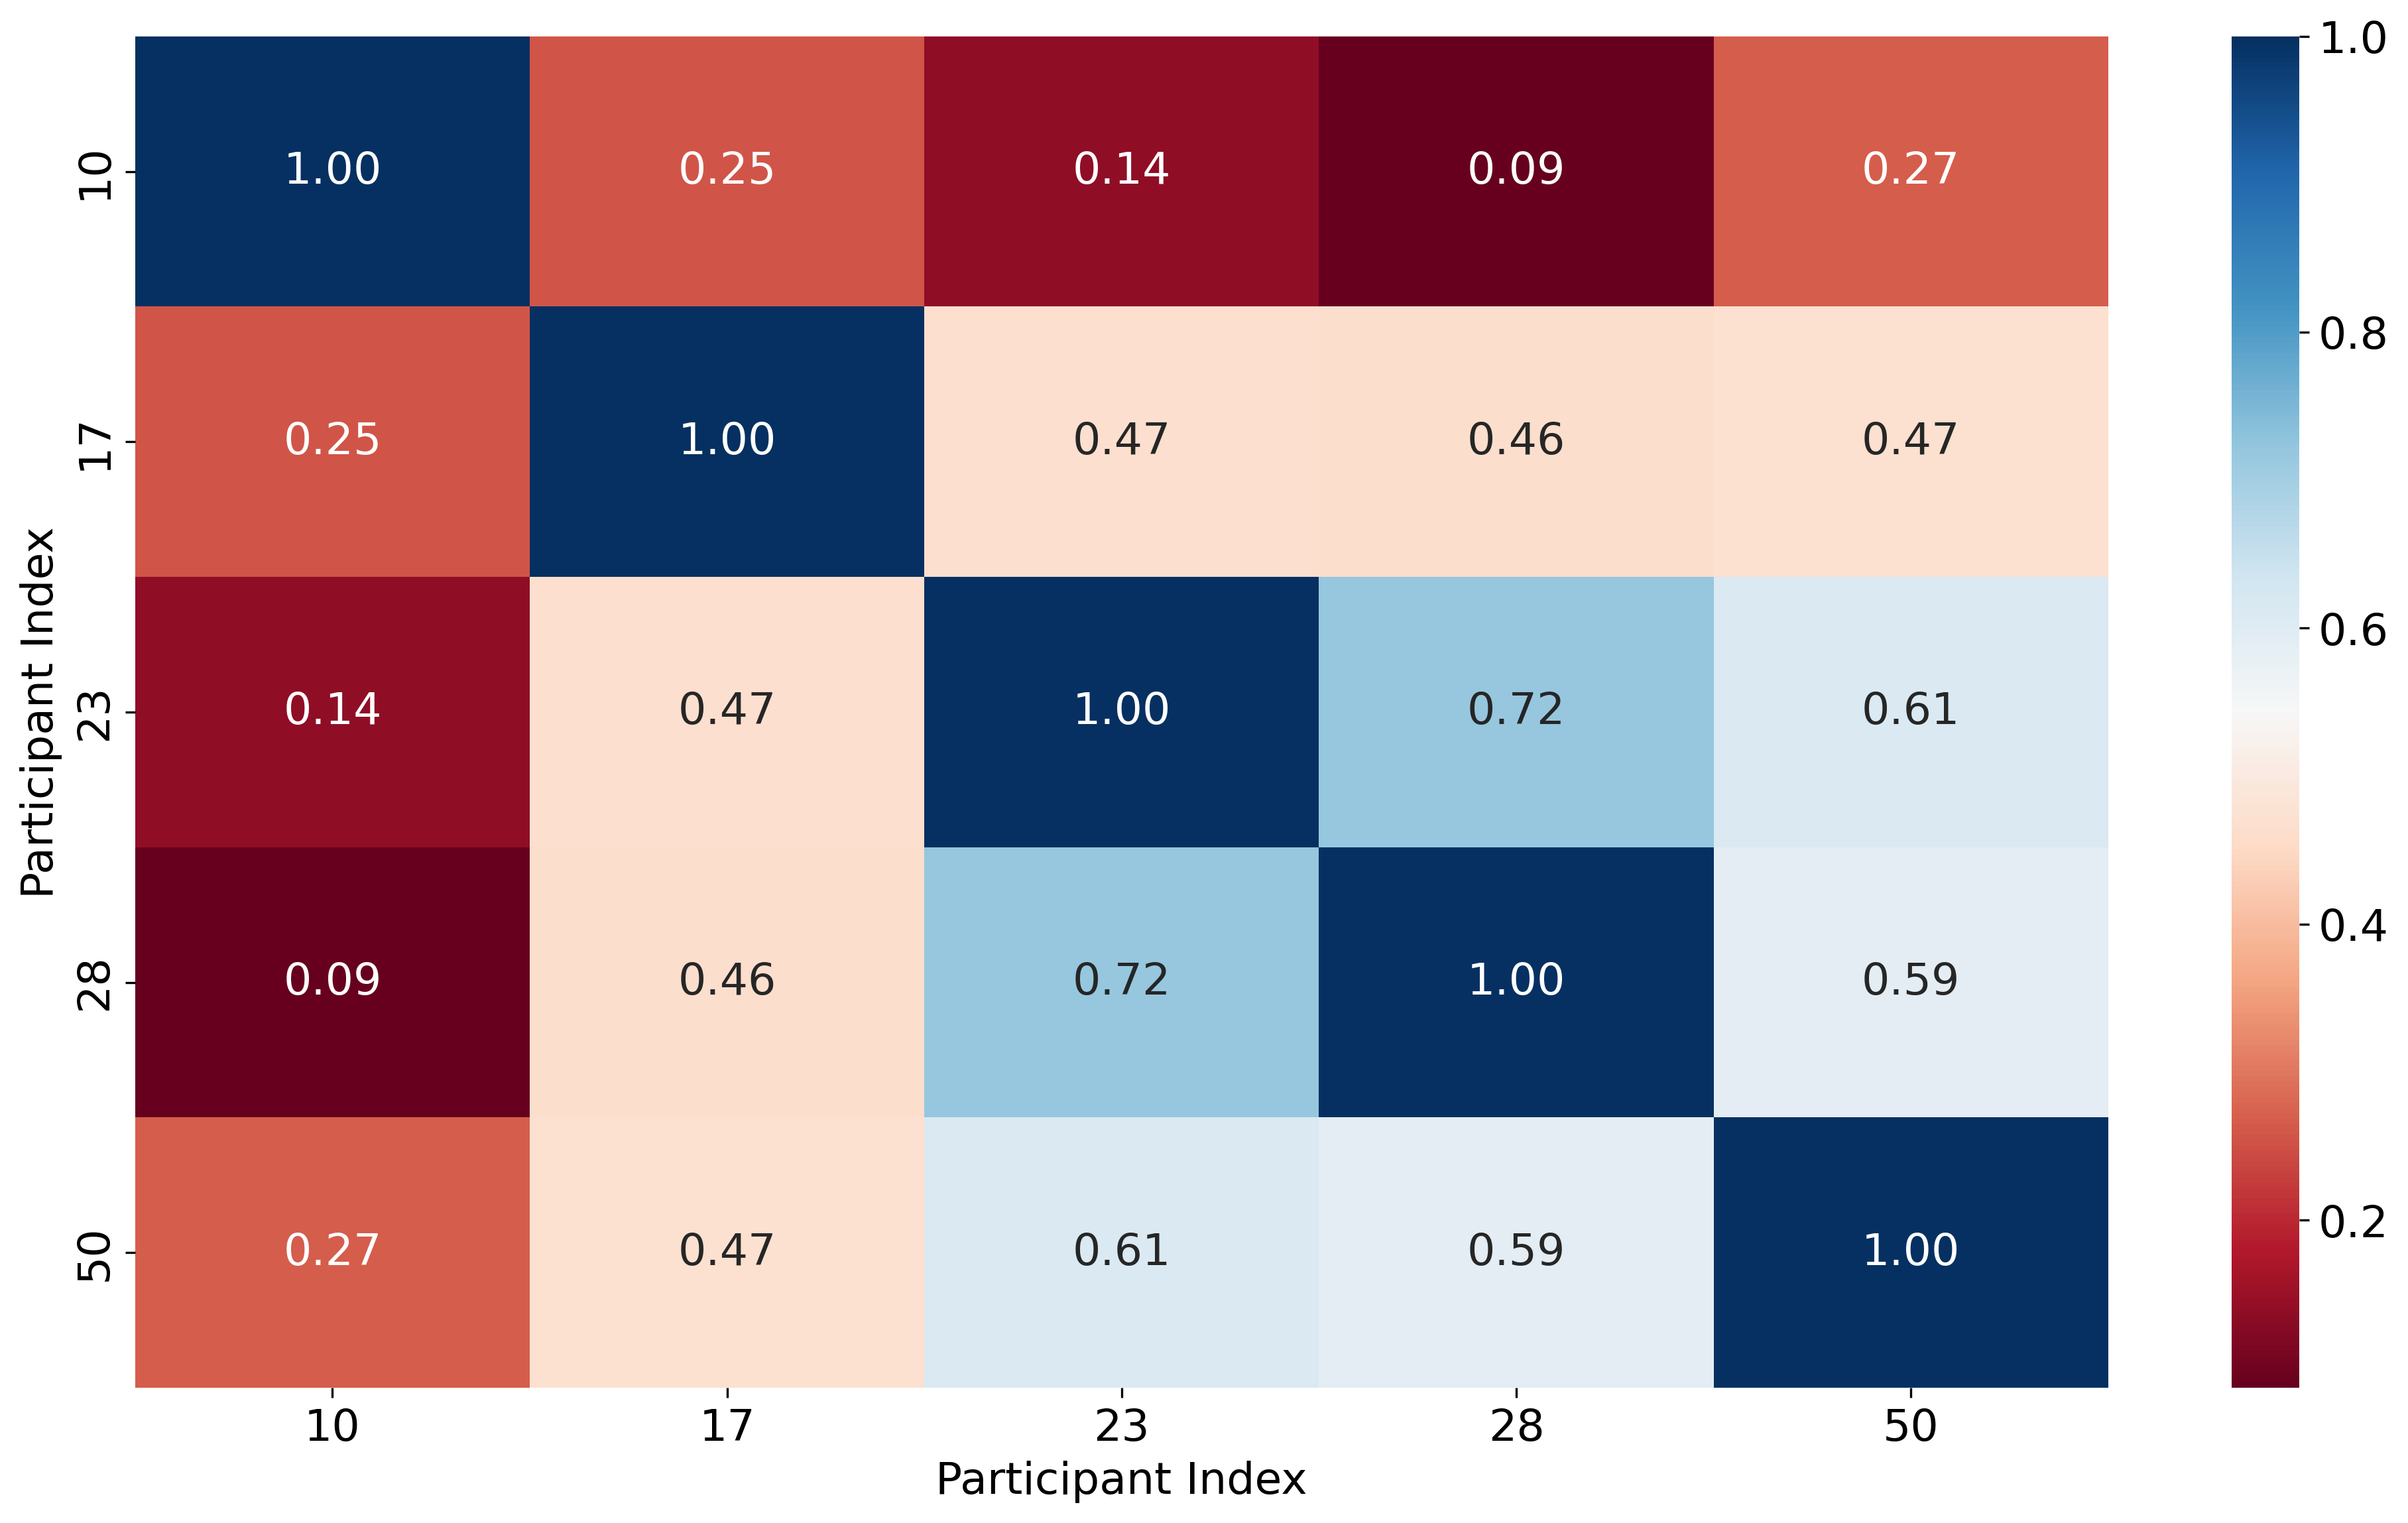

m2high
[29, 41, 47, 54]


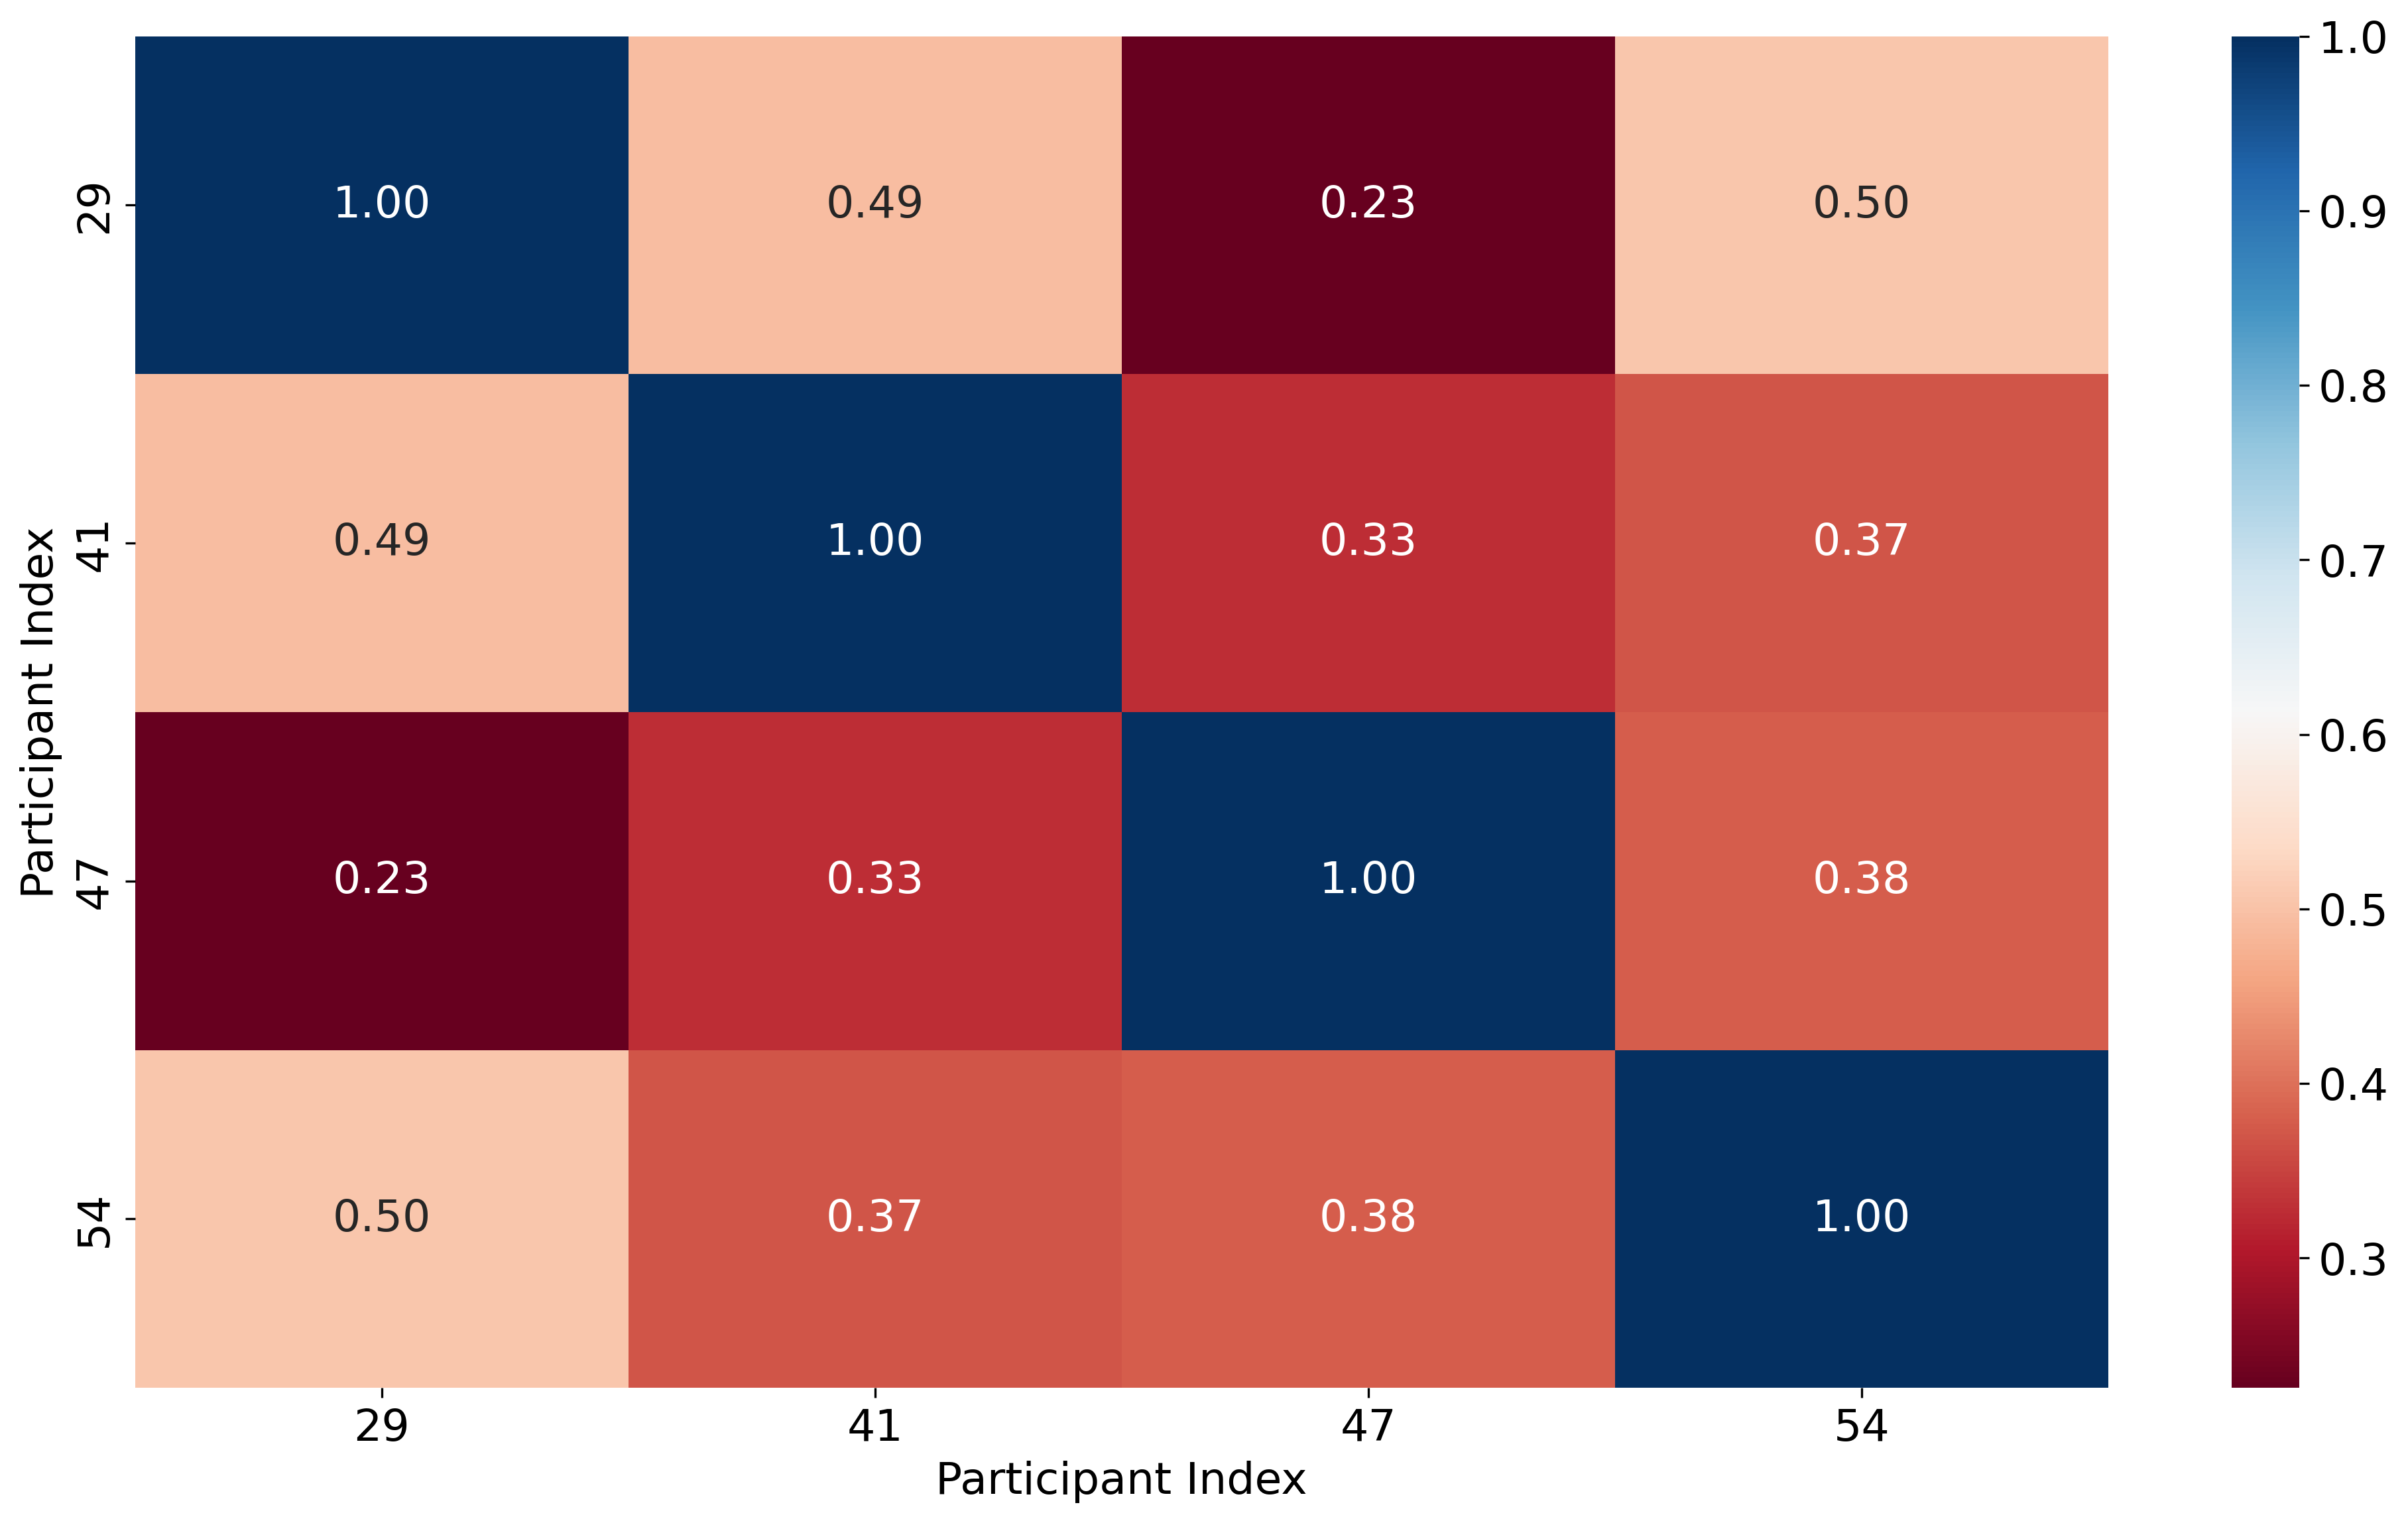

m4high
[4, 18, 36, 39, 52]


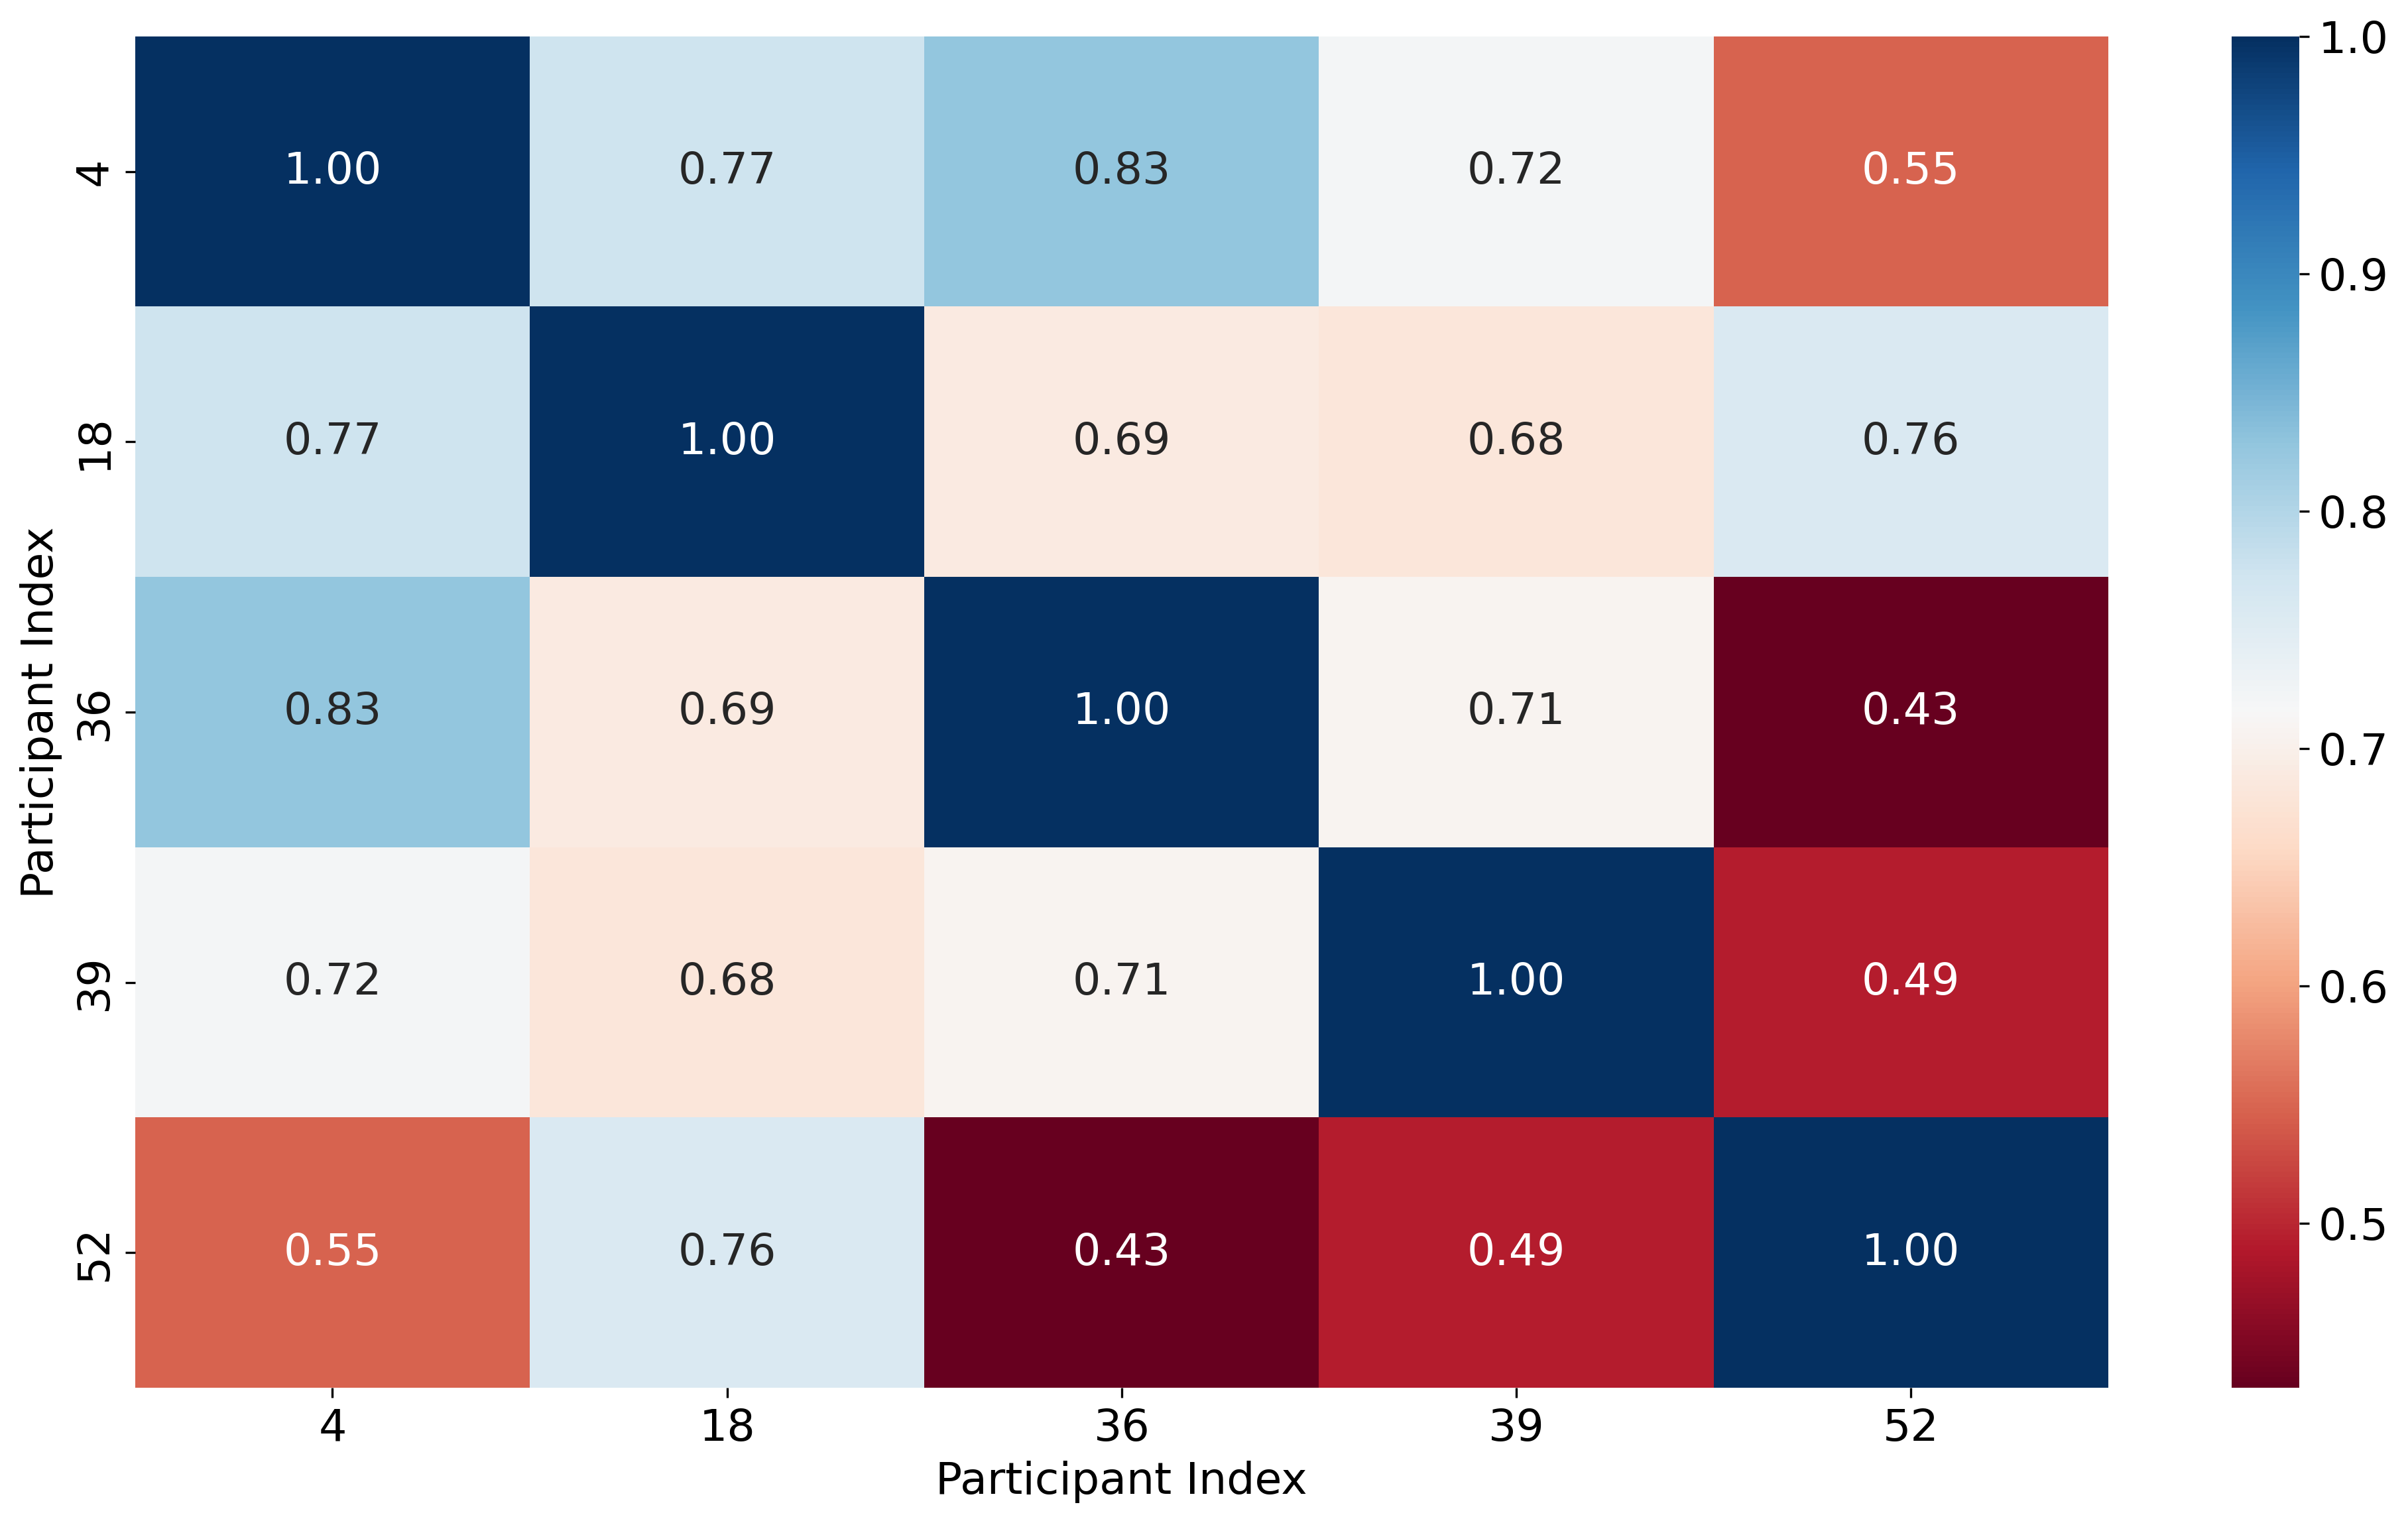

f2low
[11, 22, 25, 35]


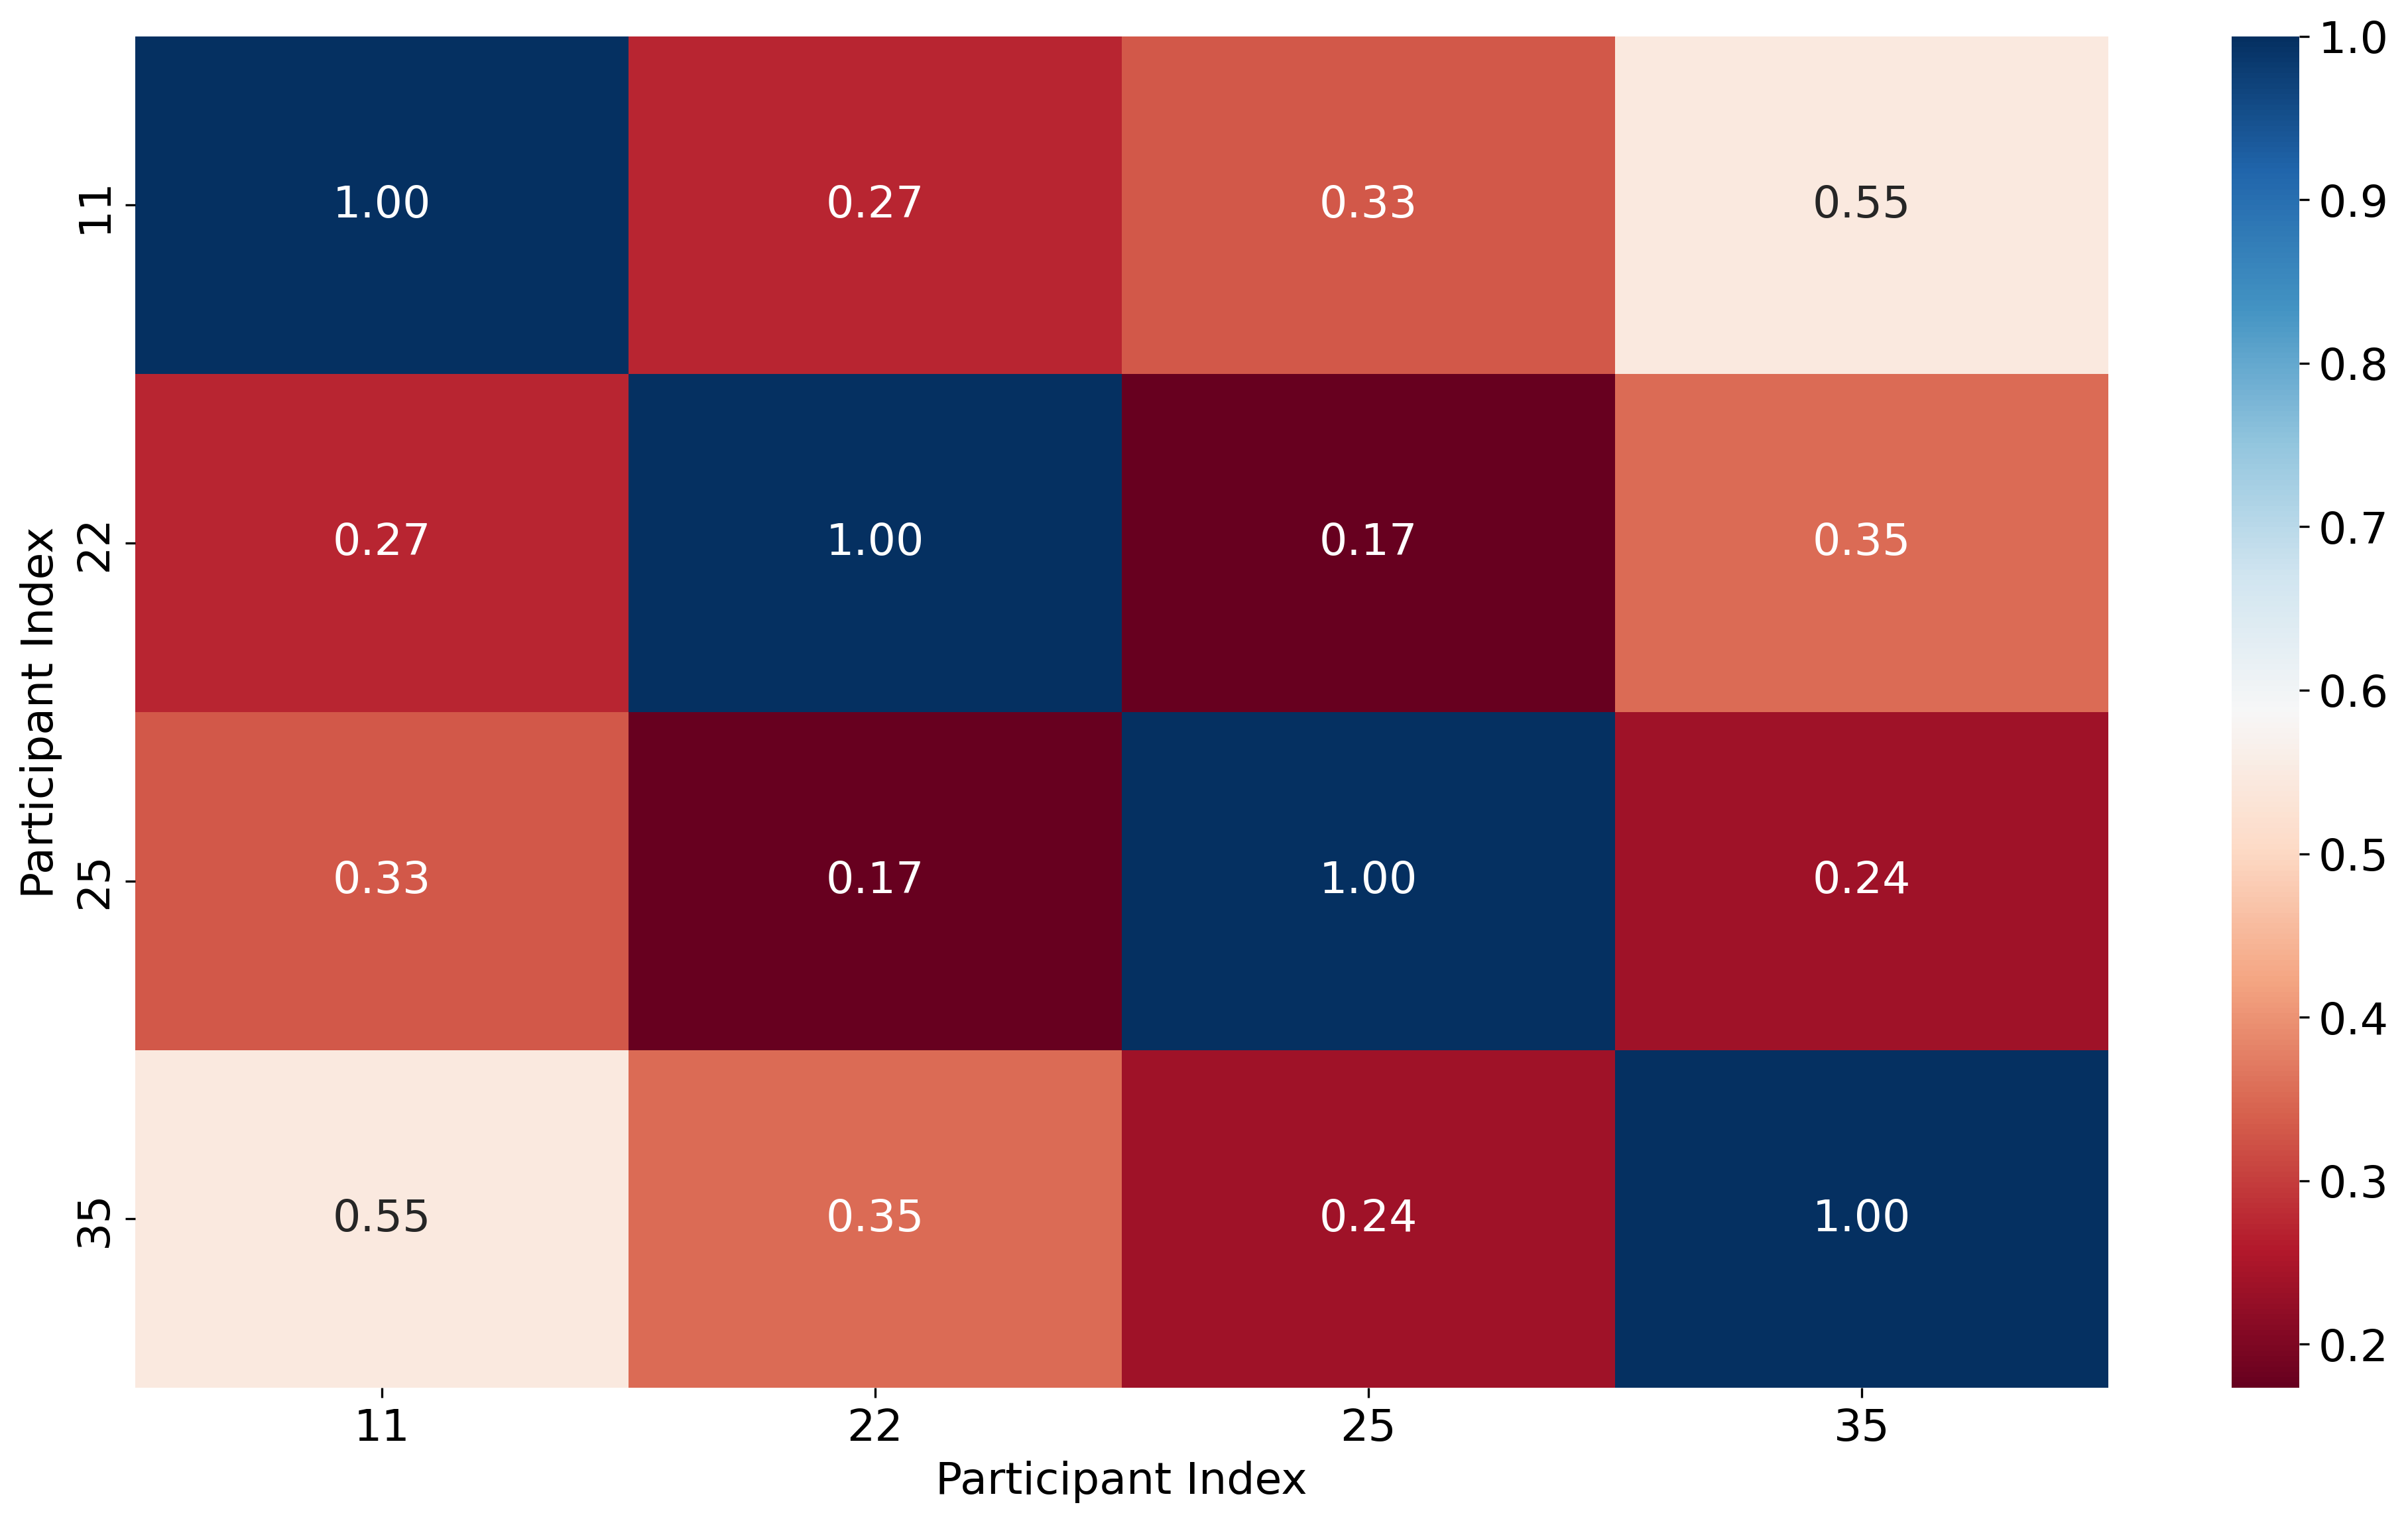

f3low
[3, 27, 33, 45, 51]


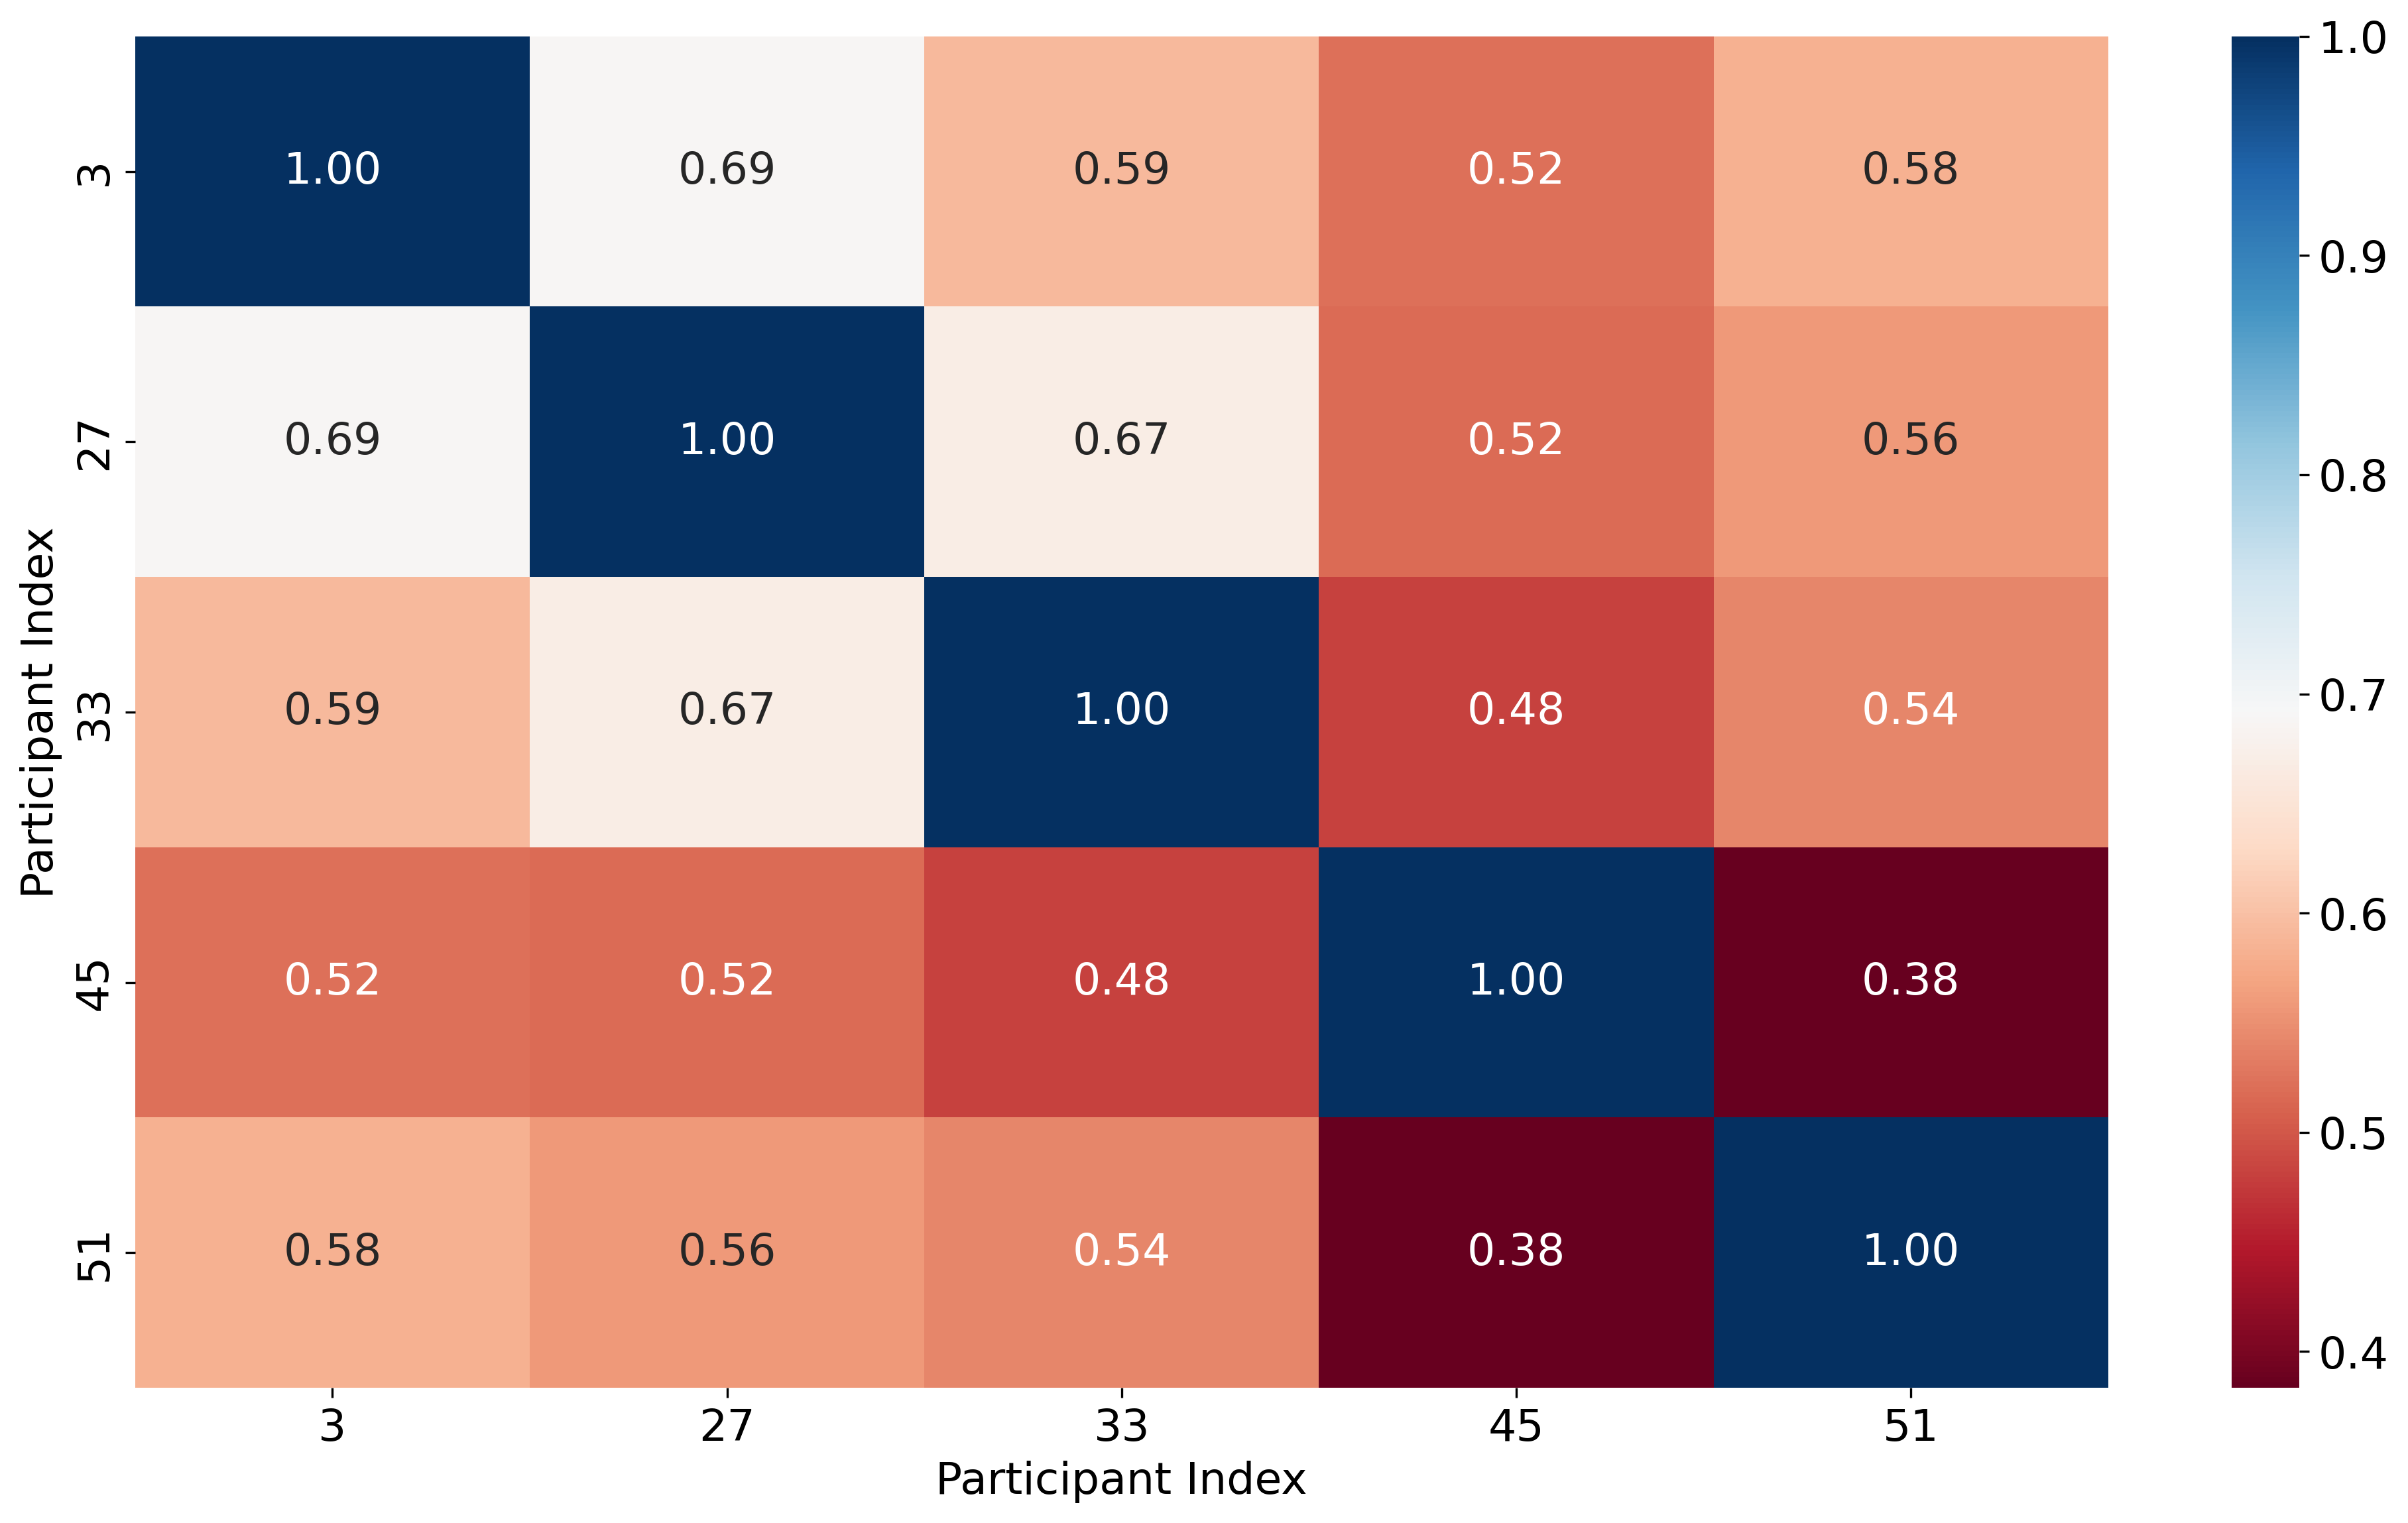

f5low
[9, 16, 20, 38, 40]


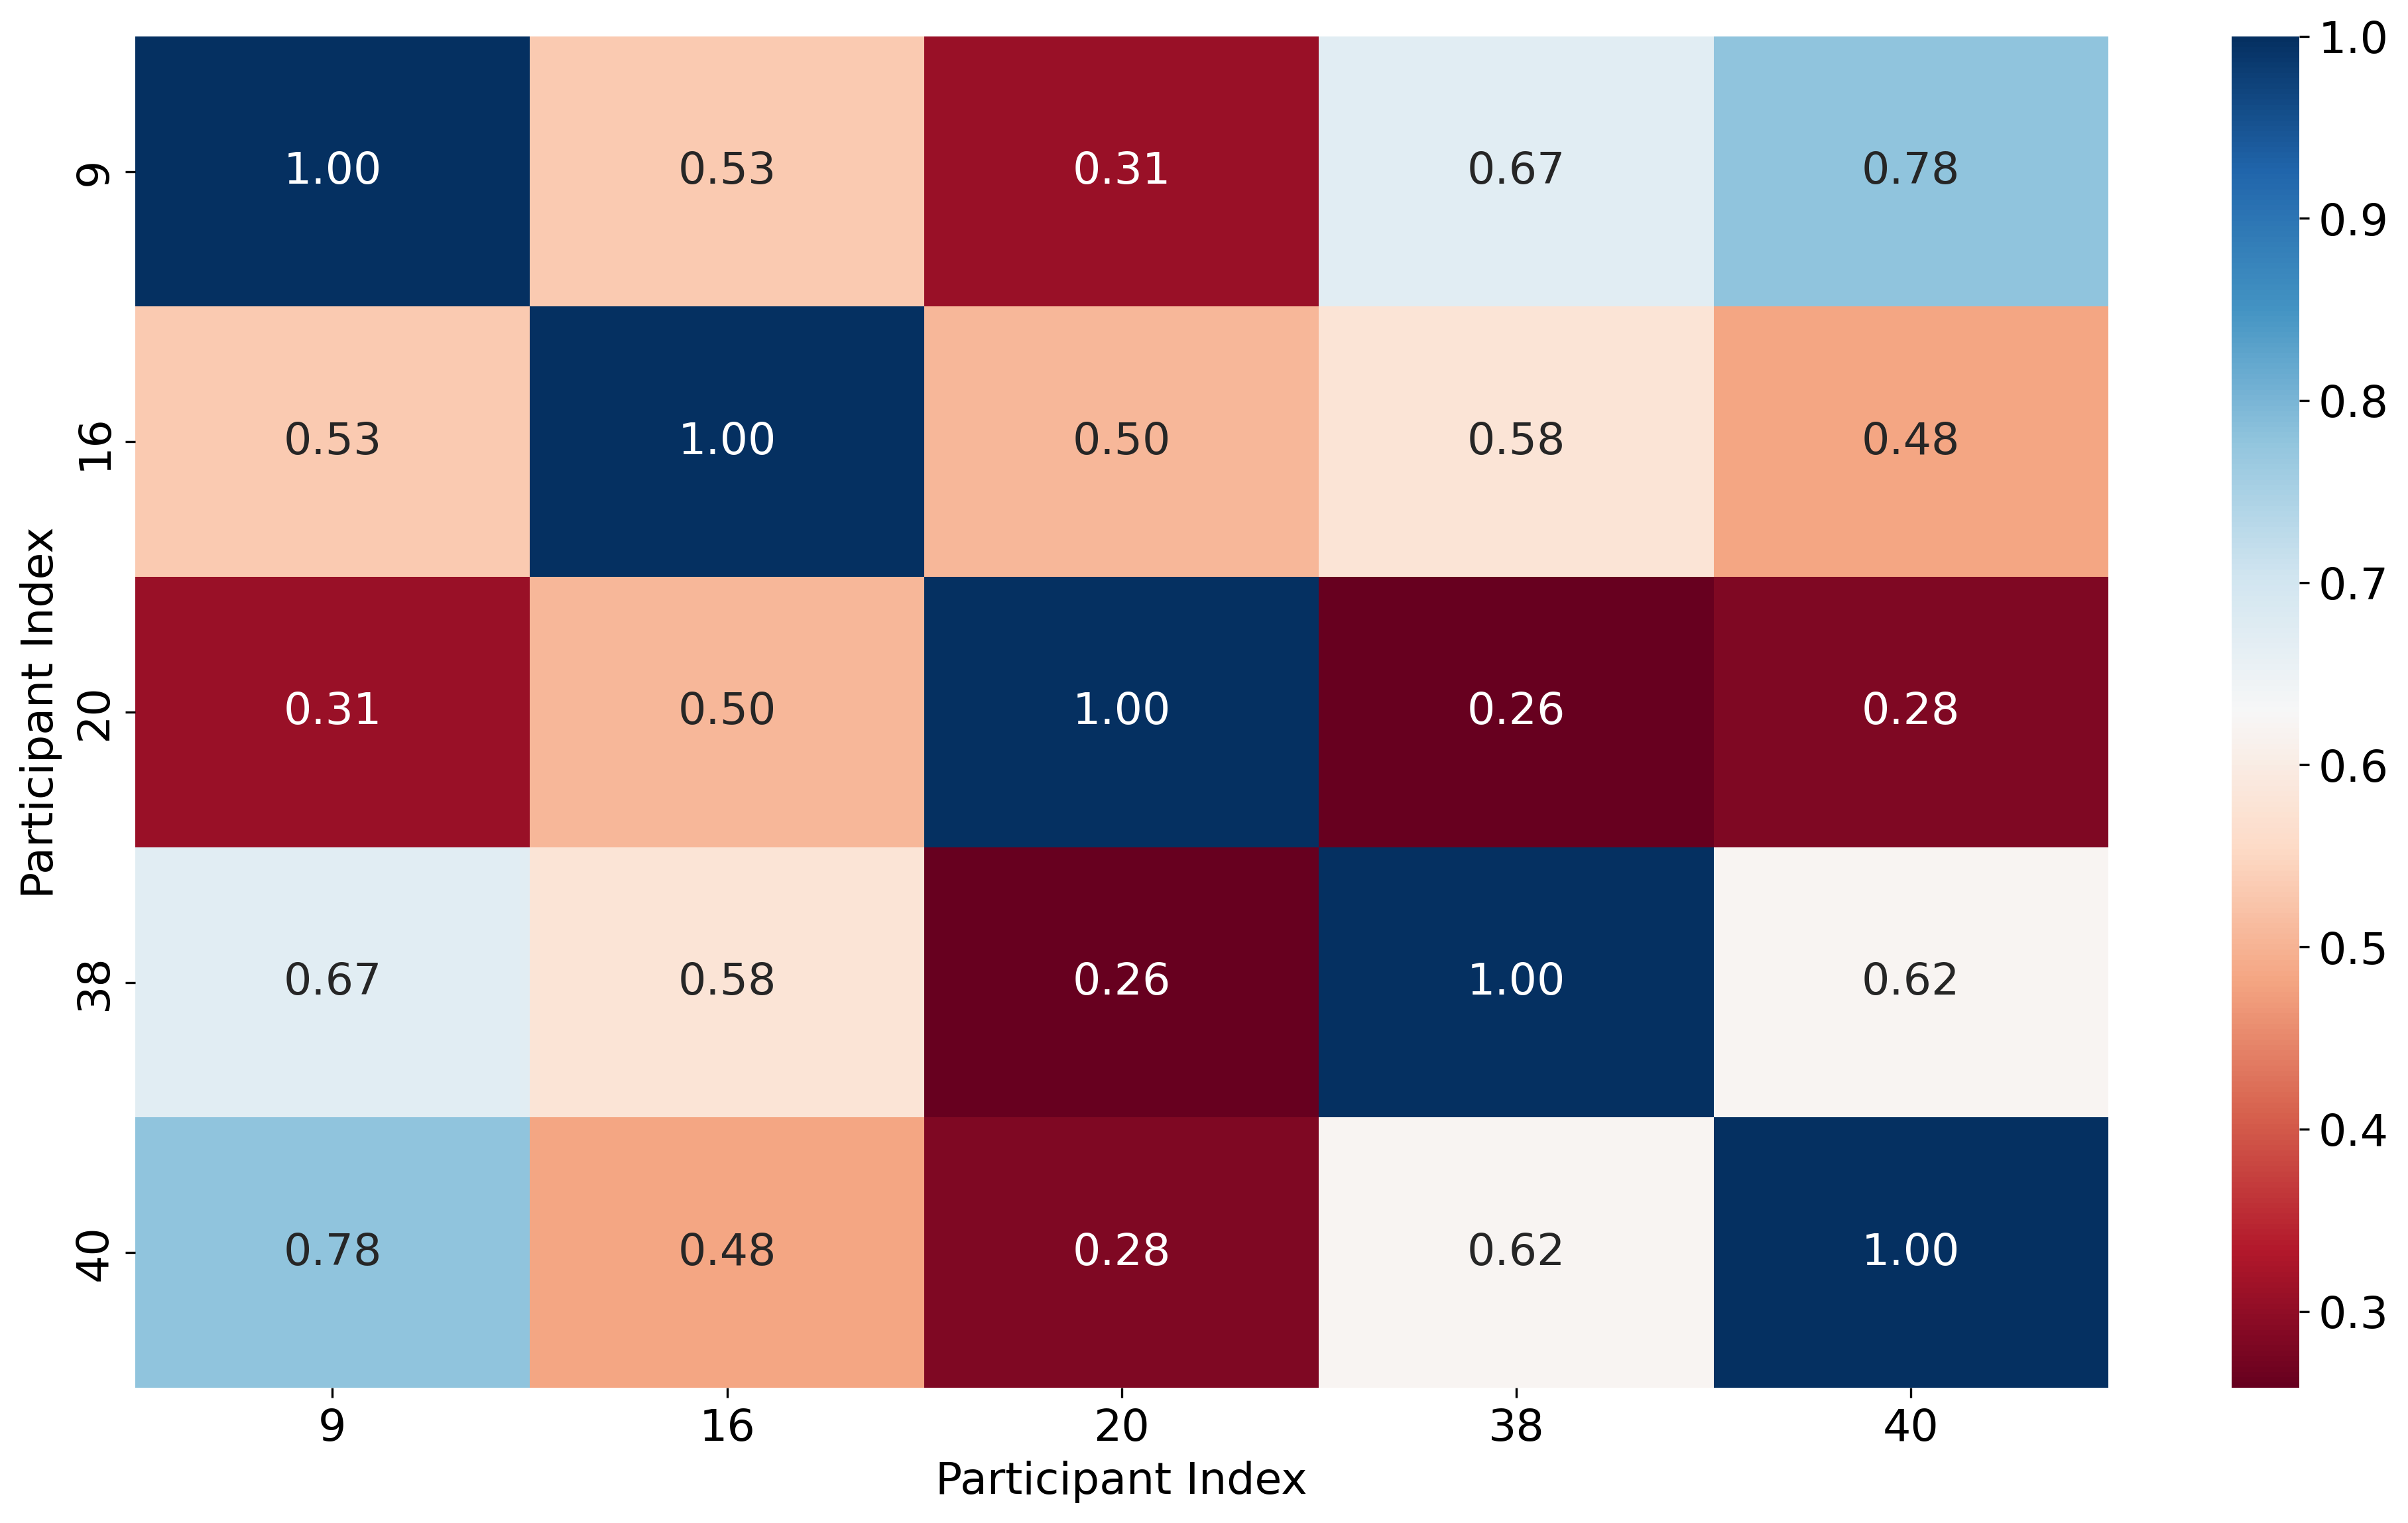

f2high
[8, 13, 14, 24, 26]


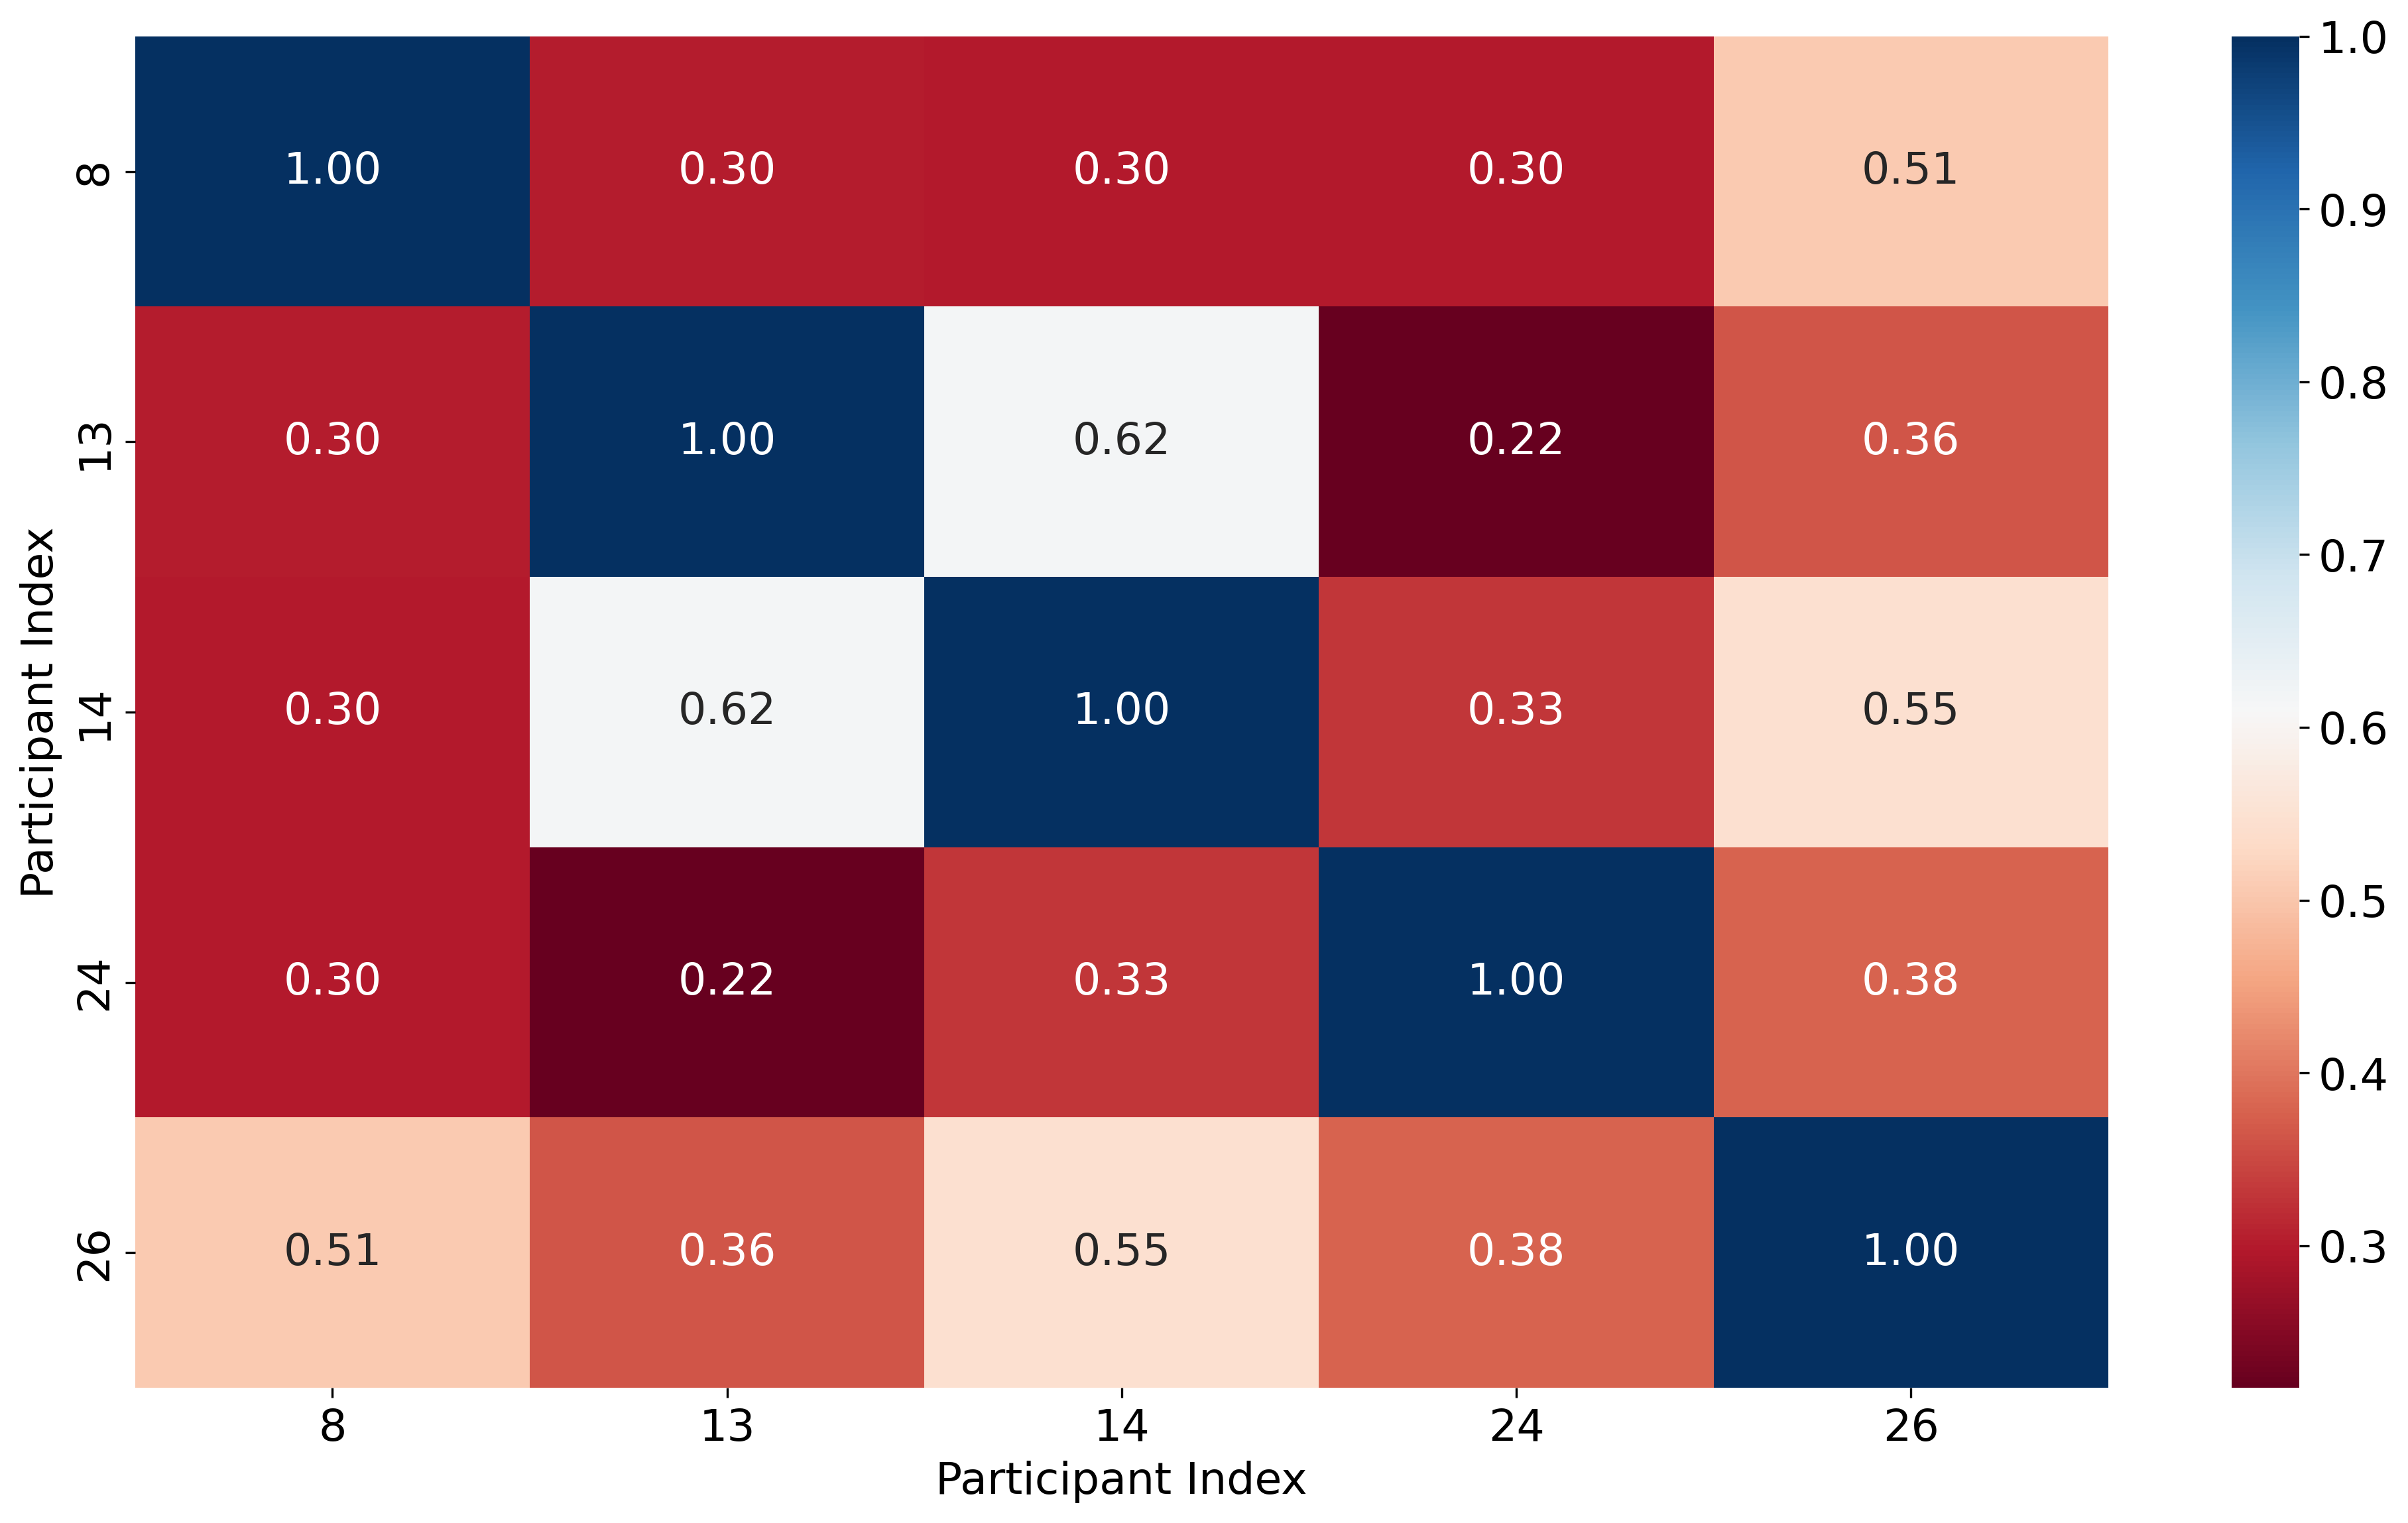

f3high
[0, 30, 44]


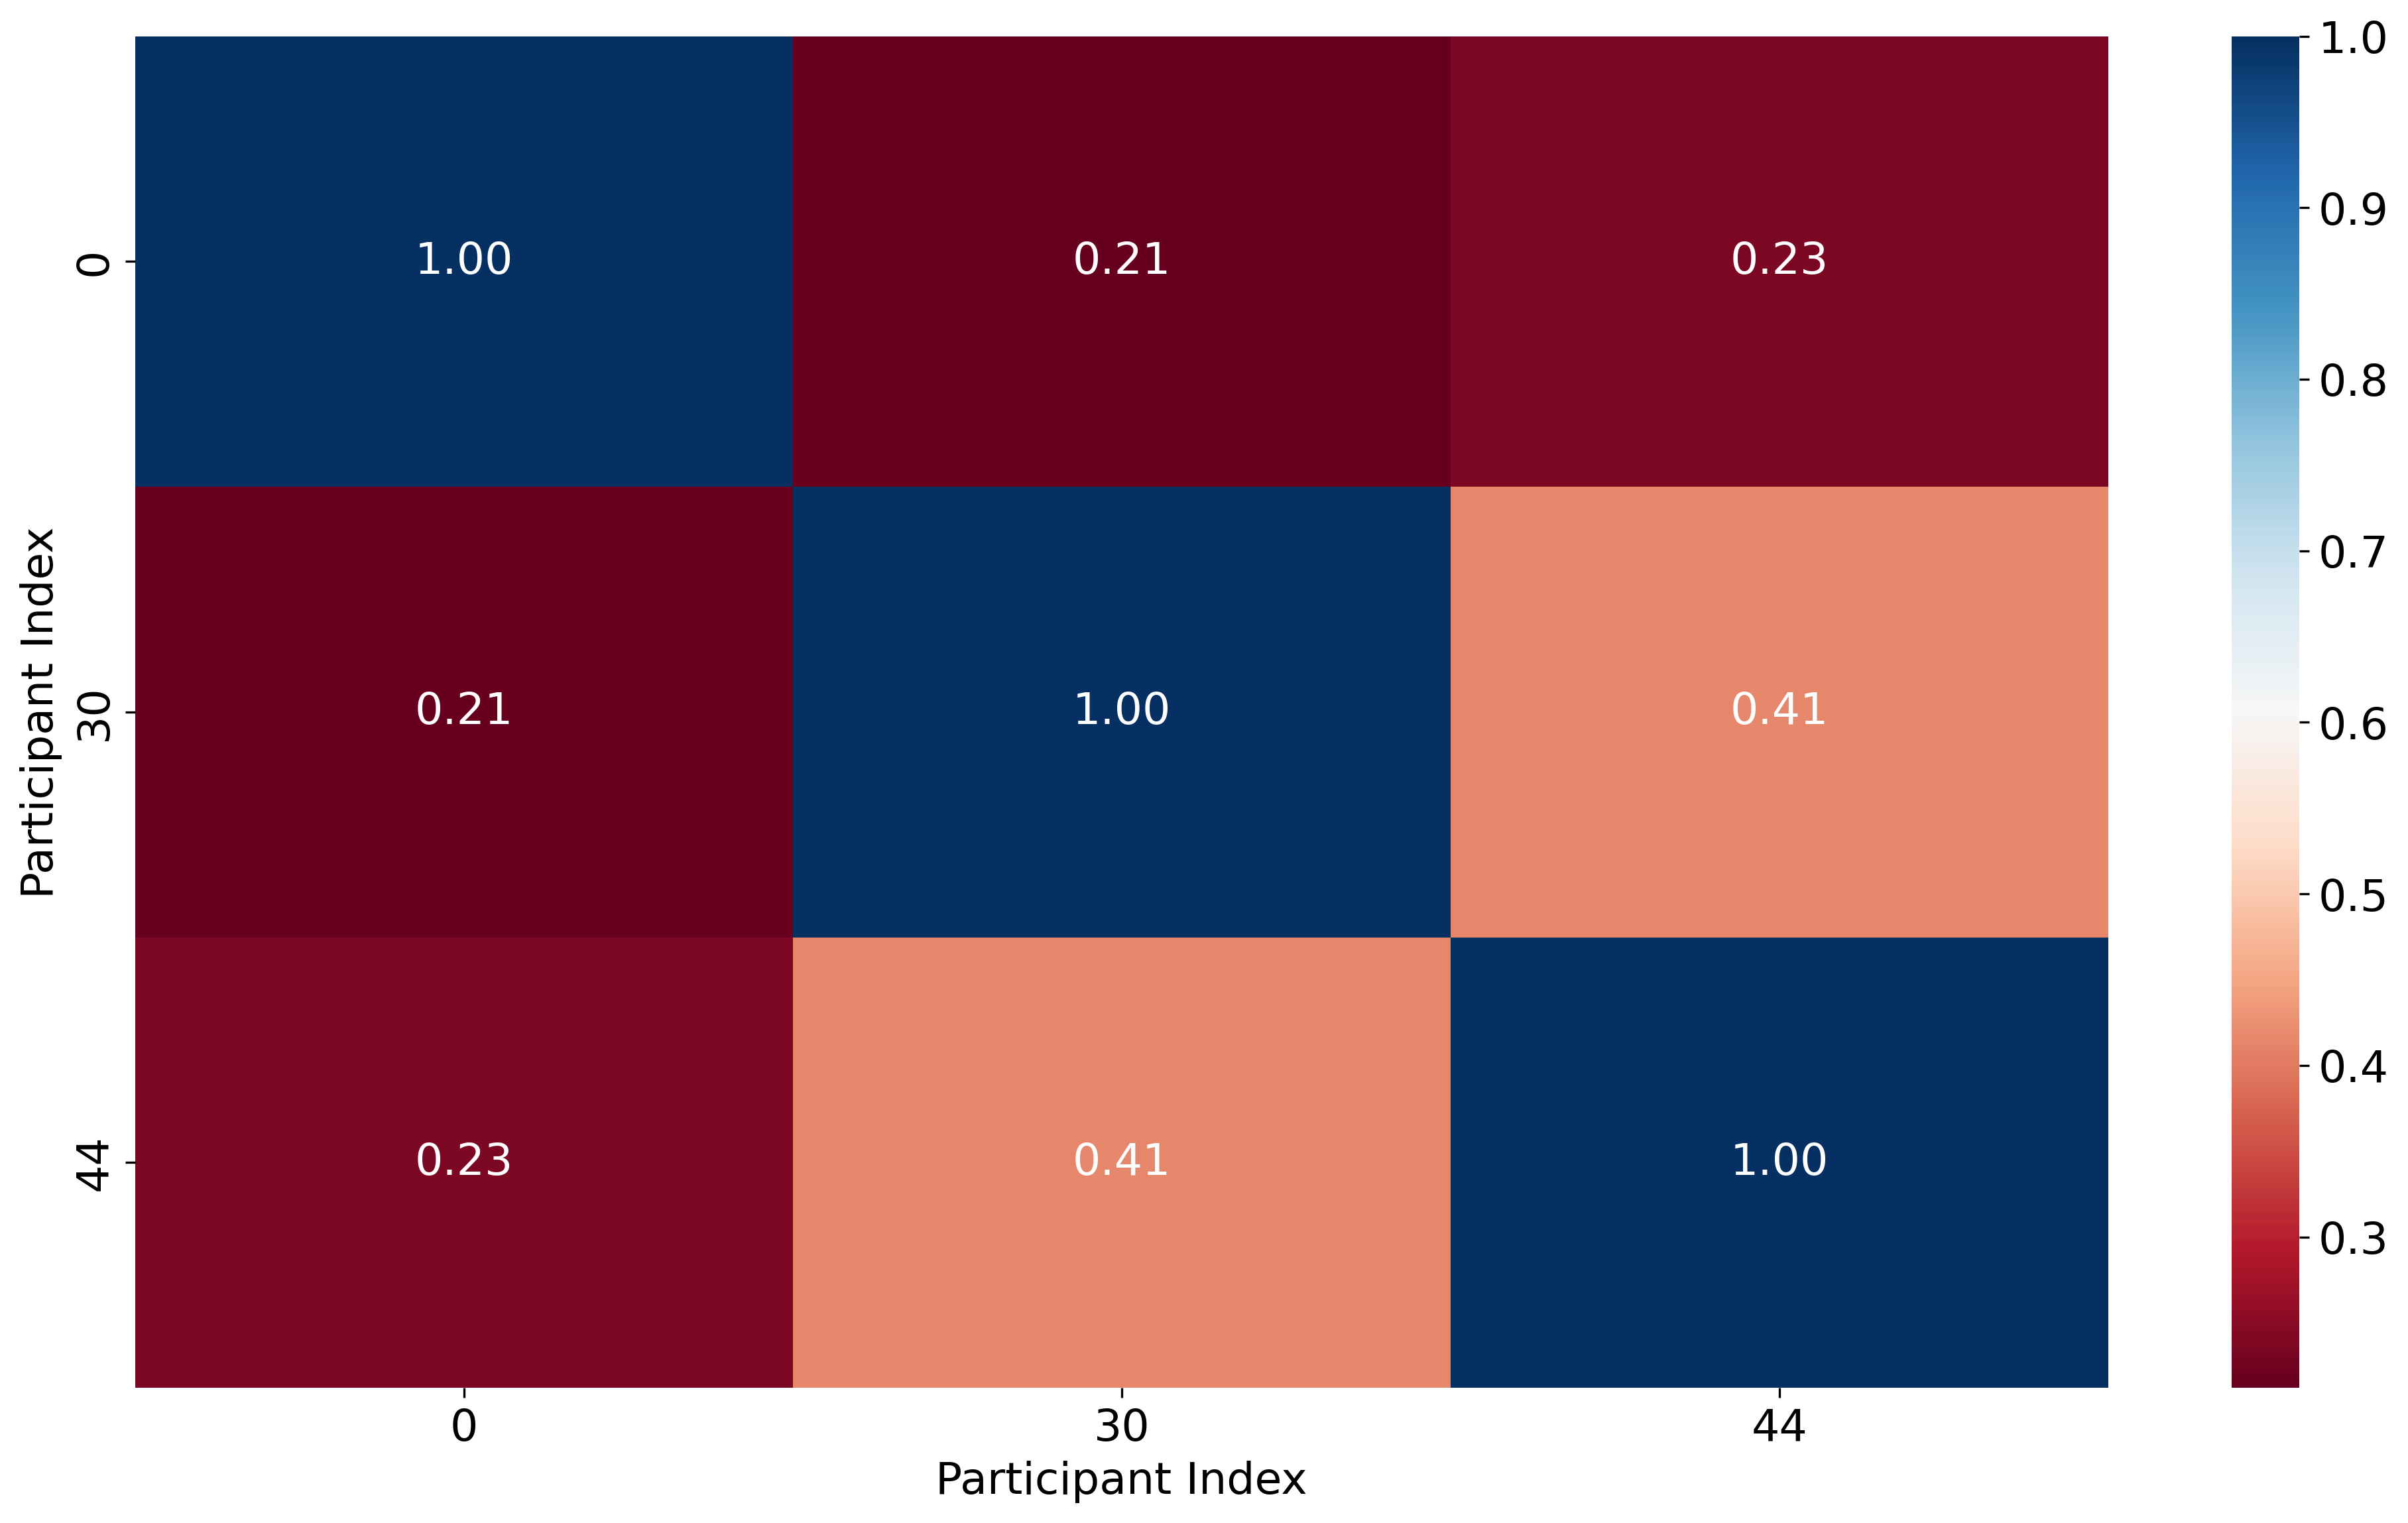

f5high
[2, 5, 6, 43, 53]


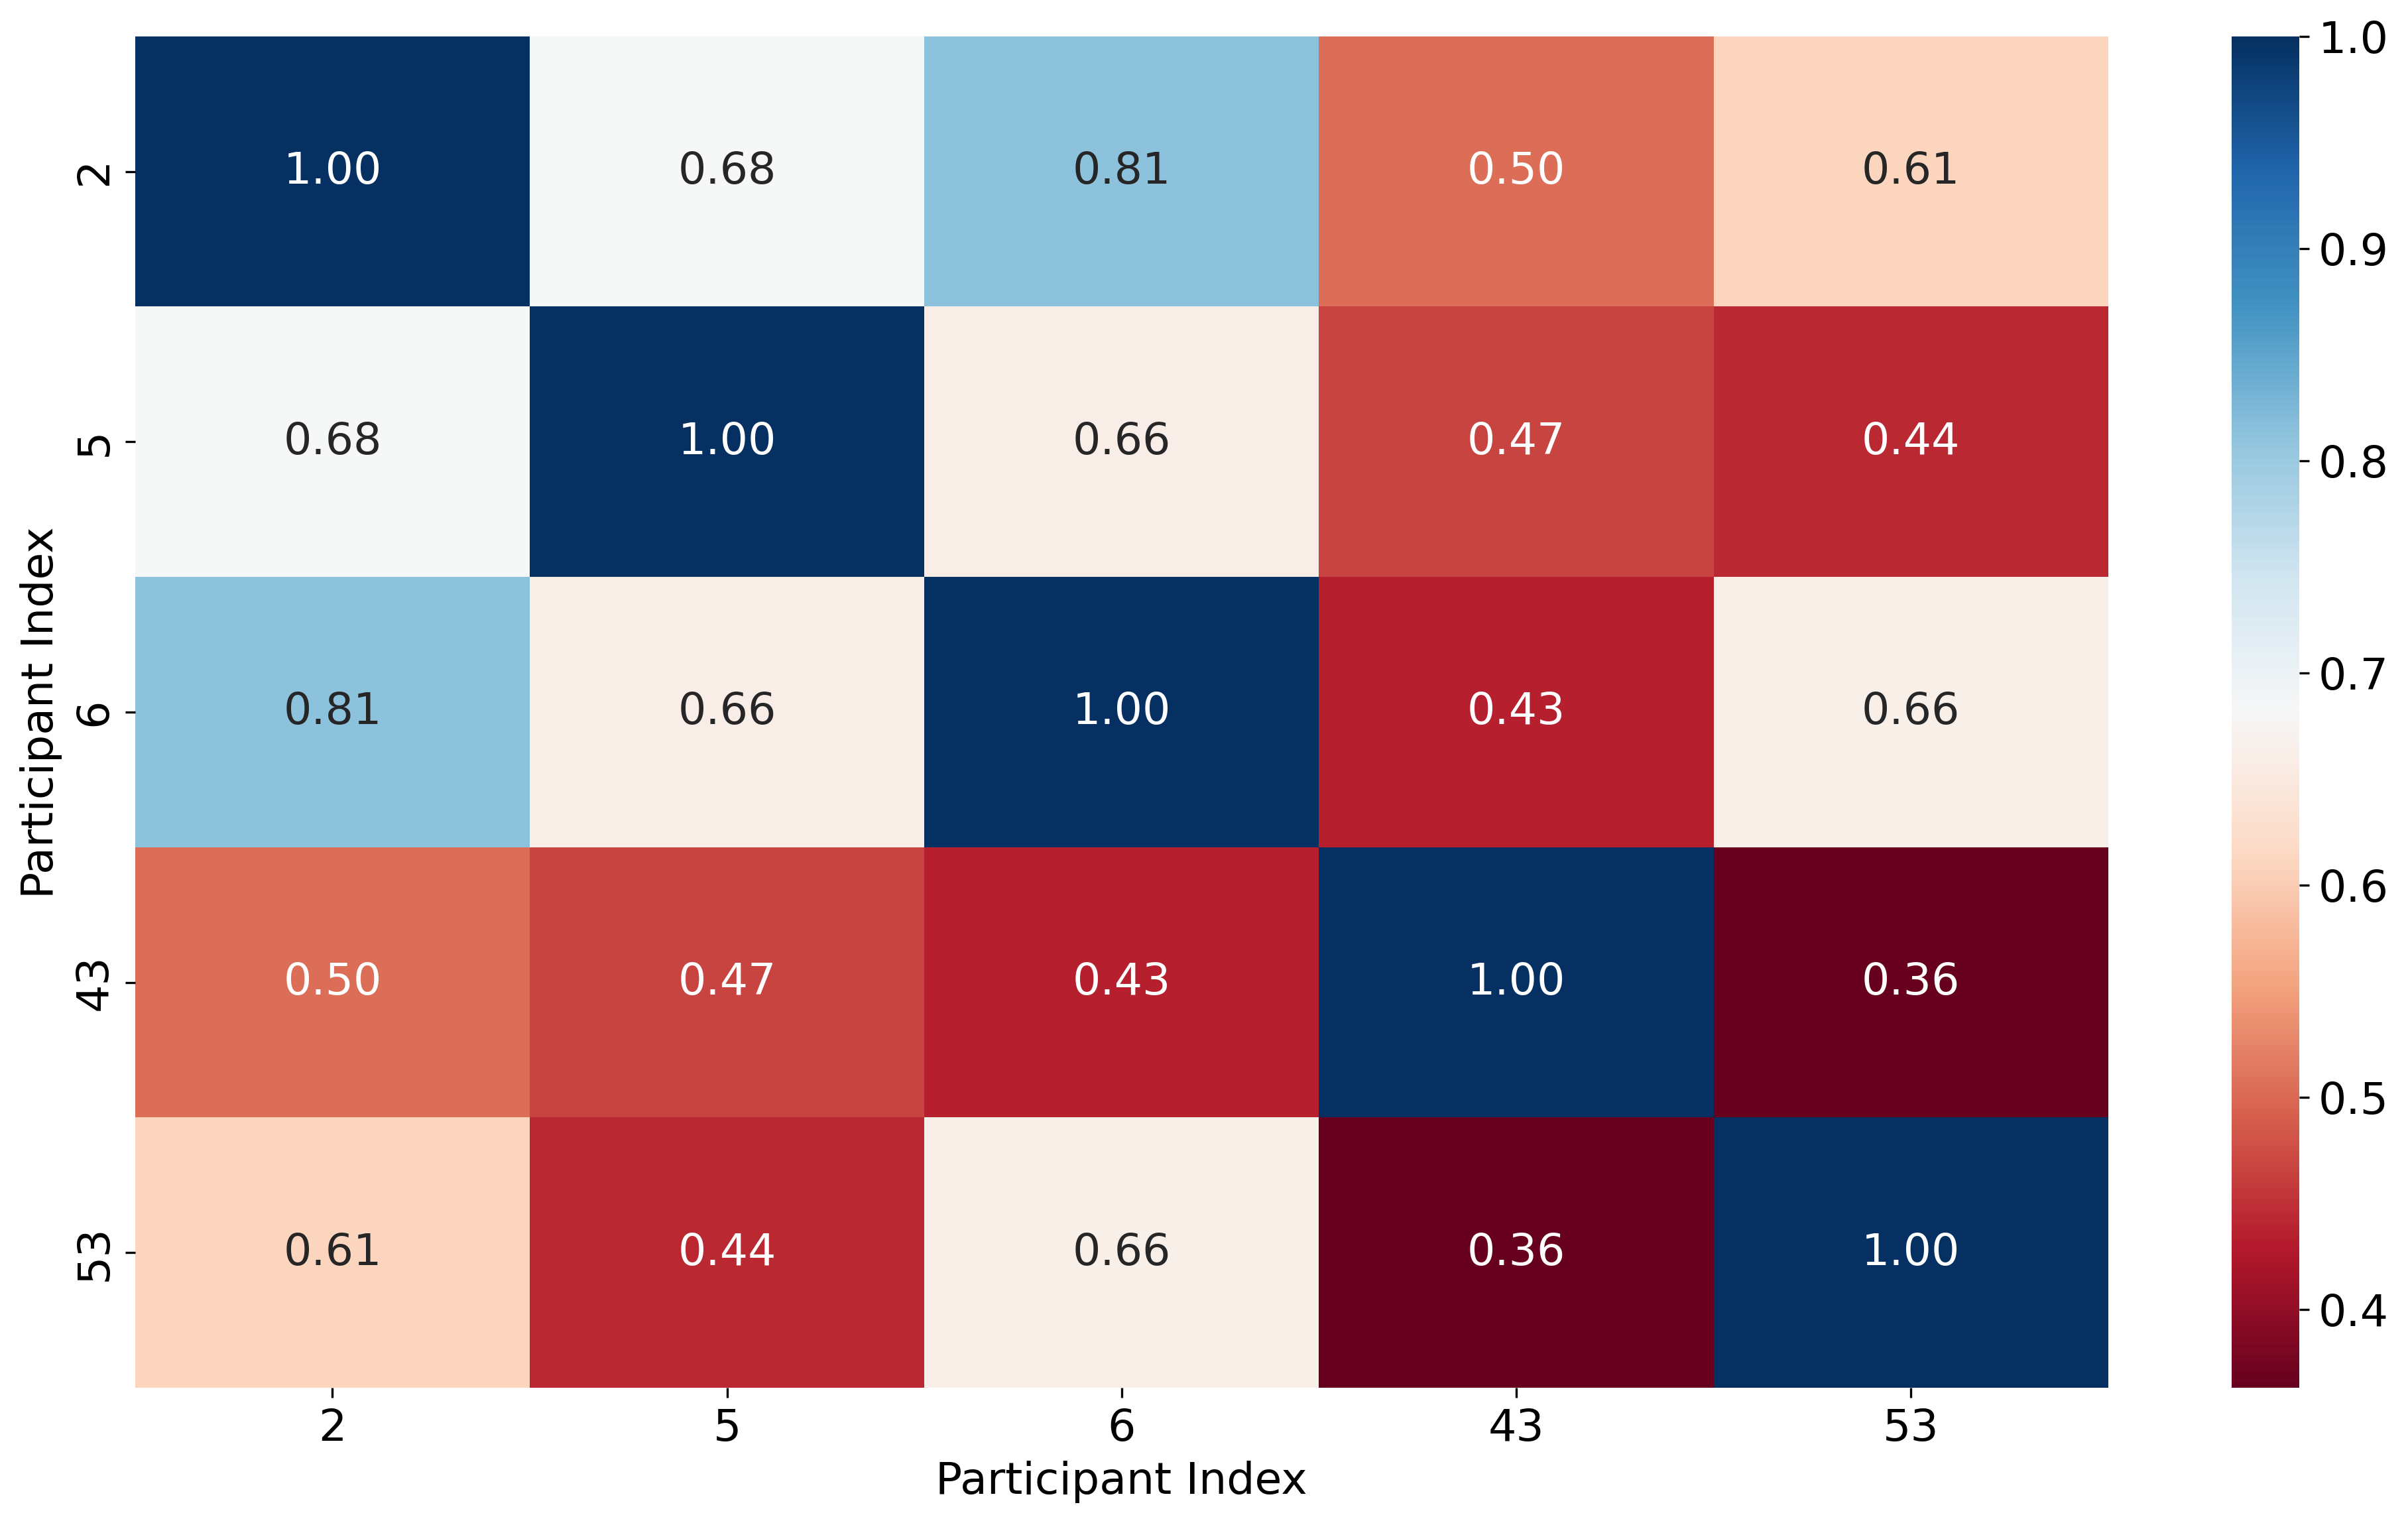

In [29]:
import seaborn as sns

text_size = 16

for idx, cond_ratings_idxs_list in enumerate(ratings_idxs_grouped_by_session):
    cond_ratings_list = [i[0] for i in cond_ratings_idxs_list]
    idxs_list = [i[1] for i in cond_ratings_idxs_list]
    sesh_name = session_cond_names[idx]
    print(sesh_name)
    cond_ratings_arr = np.asarray(cond_ratings_list).squeeze(1)
    print(idxs_list)
    cond_ratings_corr = pd.DataFrame(cond_ratings_arr).T.corr('spearman')
    heatmap = sns.heatmap(cond_ratings_corr, cmap = "RdBu", annot=True, xticklabels=idxs_list, yticklabels=idxs_list, fmt=".2f")
    heatmap.set_xlabel("Participant Index", fontsize=text_size)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), size=text_size)
    heatmap.set_ylabel("Participant Index", fontsize=text_size)
    heatmap.set_yticklabels(heatmap.get_xticklabels(), size=text_size)
    for text in heatmap.texts:
        text.set_fontsize(text_size)
    cbar = heatmap.collections[0].colorbar  # Access the color bar object
    cbar.ax.tick_params(labelsize=text_size)  # Set the font size as needed
    fig = plt.gcf()
    fig.set_size_inches(16, 9)  # Set the desired width and height in inches
    fig.set_dpi(300)
    plt.savefig(f"correlations/corr_matrices/corr_mat_plot_{sesh_name}.png", dpi=300)
    plt.show()
    plt.close()

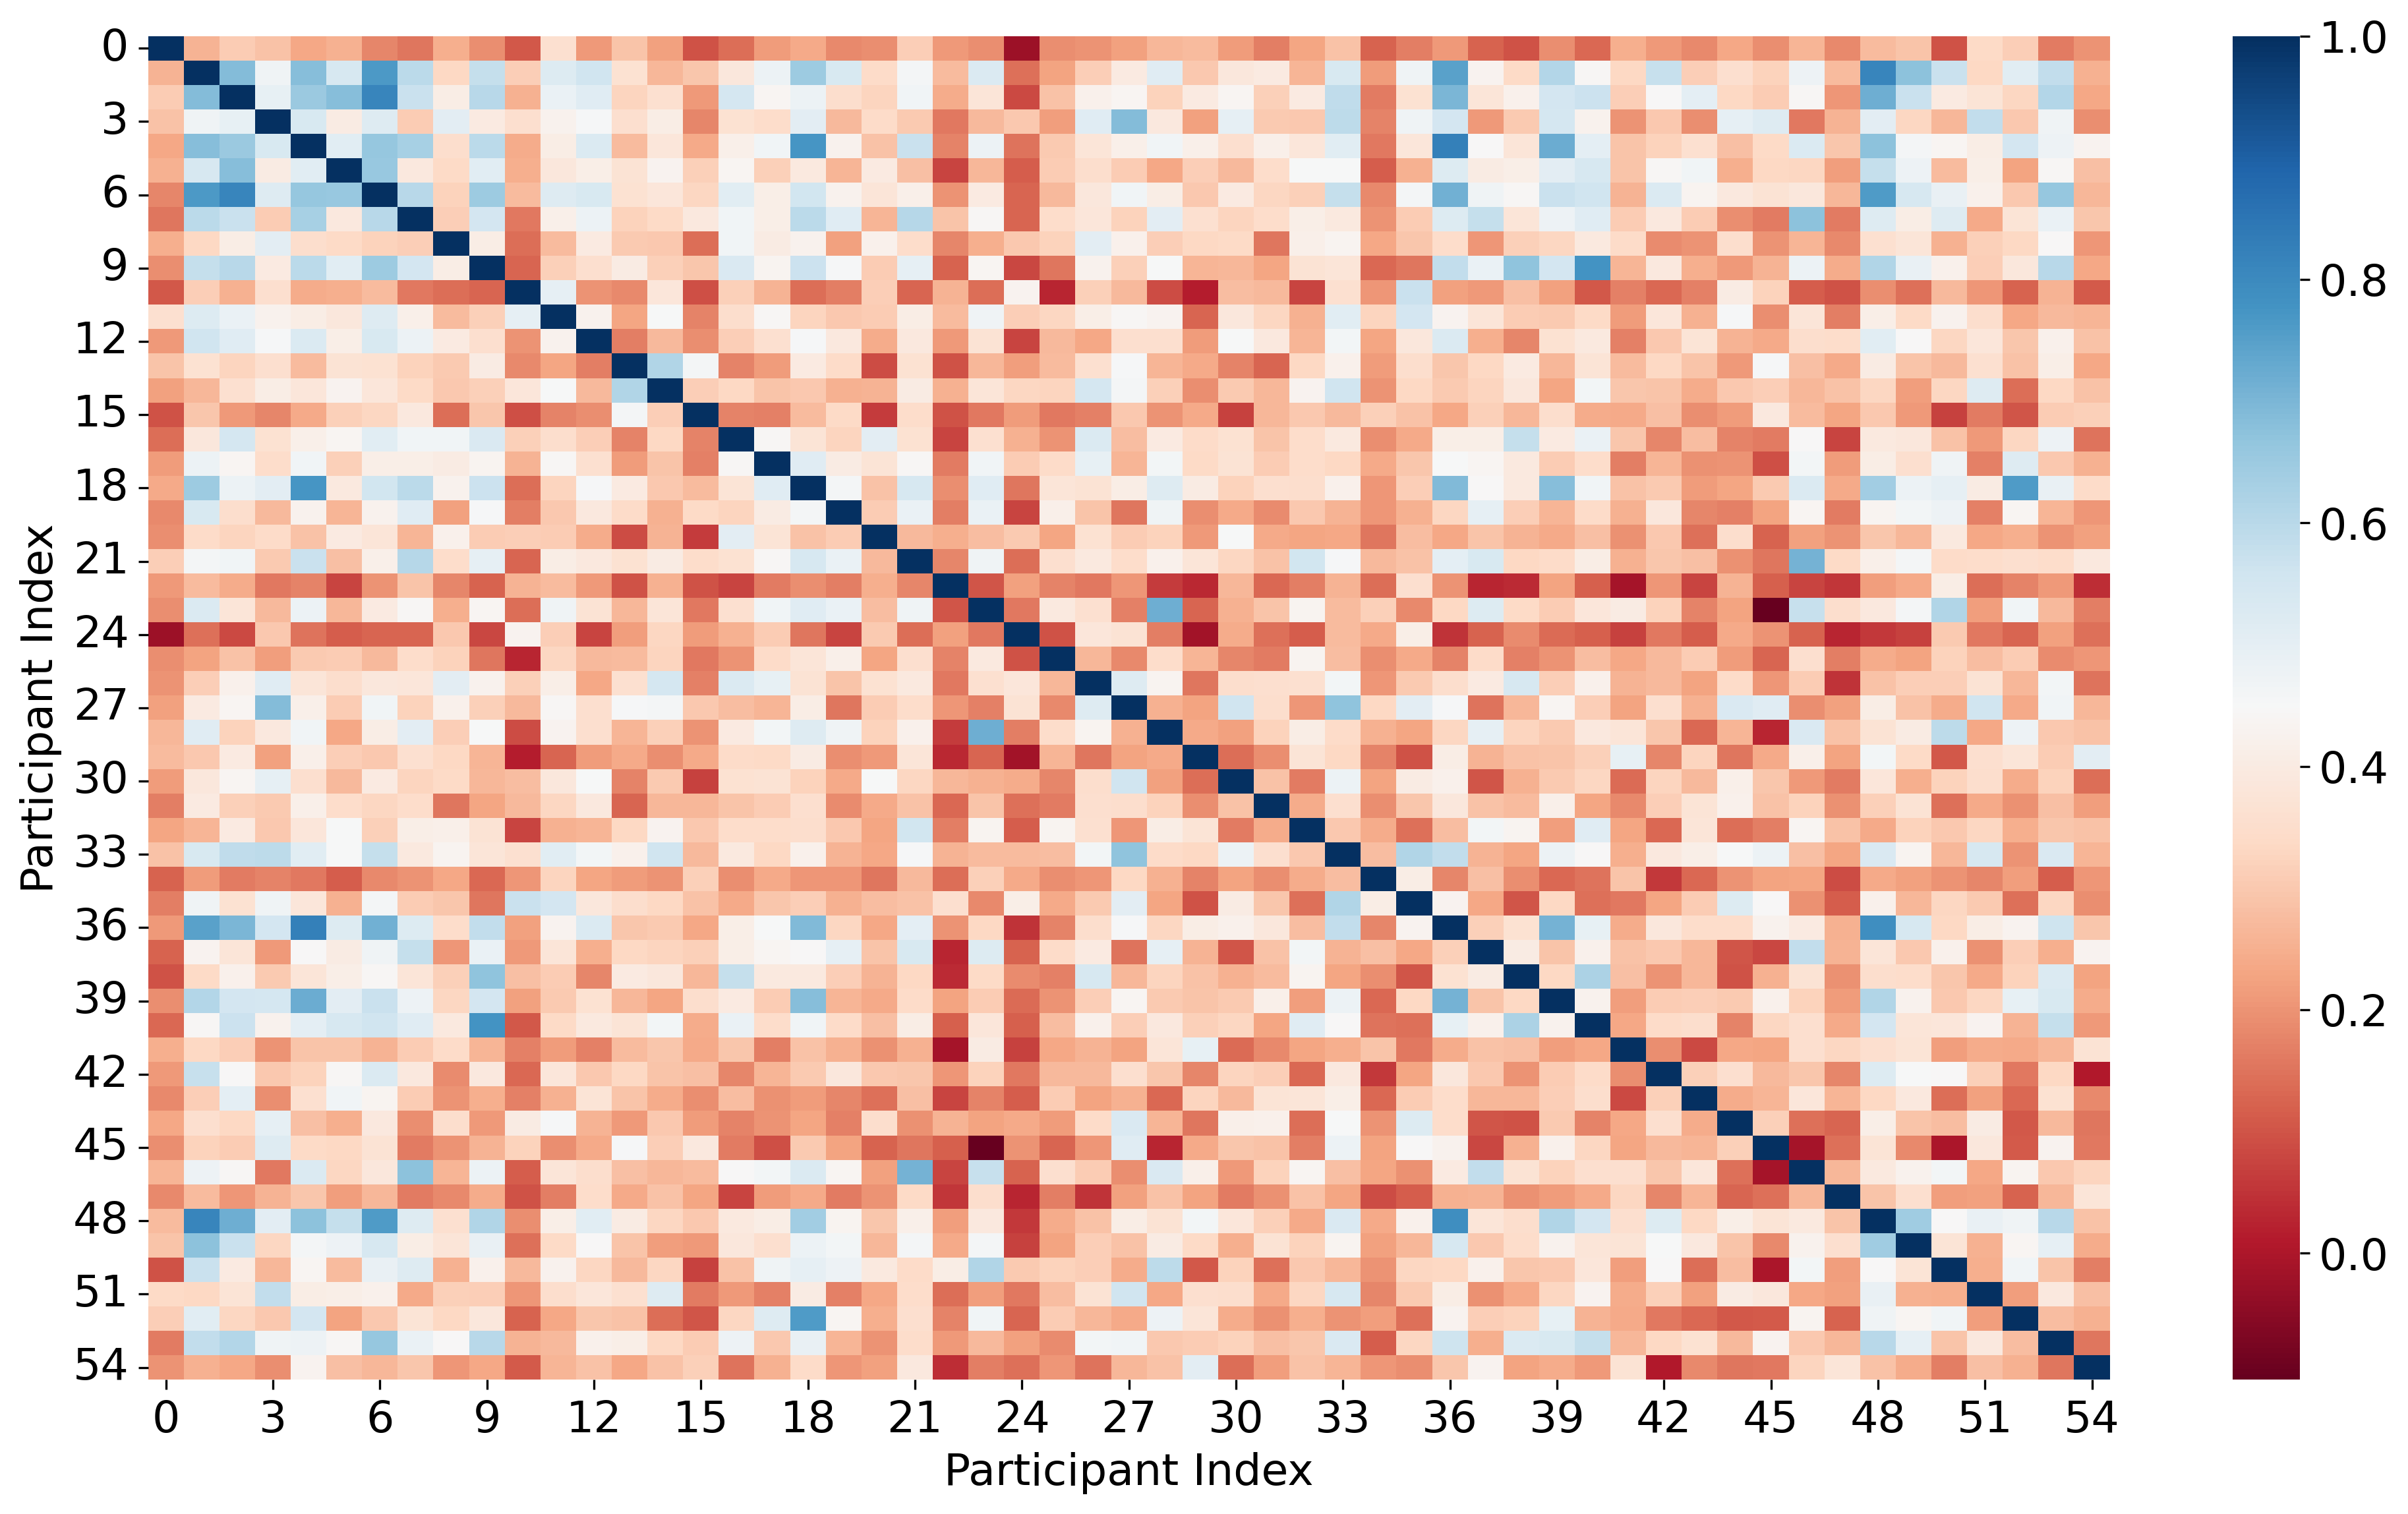

In [30]:
"""CHECH FOR OUTLIERS AMONG PARTICIPANTS' DISSIMILARITY MATRICES
Too many datapoints are highly uncorrelated with others, and none are negatively correlated.
"""

# collect all matrices as flattened vectors
flattened_matrices = np.empty((0,225))
for idx in range(num_experiments):
    rearranged_dissim_matrix = h5_ram['dissim_matrix_dim15'][idx]
    flattened_dissim_matrix = rearranged_dissim_matrix.flatten()
    flattened_dissim_matrix = flattened_dissim_matrix.reshape(-1, len(flattened_dissim_matrix))
    flattened_matrices = np.append(flattened_matrices,flattened_dissim_matrix, axis=0)

# convert to pandas and get spearman's correlation
df = pd.DataFrame(flattened_matrices)
df_tran = df.T
df_tran_corr = df_tran.corr('spearman')

if True:
    heatmap = sns.heatmap(df_tran_corr, cmap = "RdBu")
    heatmap.set_xlabel("Participant Index", fontsize=text_size)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), size=text_size)
    heatmap.set_ylabel("Participant Index", fontsize=text_size)
    heatmap.set_yticklabels(heatmap.get_xticklabels(), size=text_size)
    cbar = heatmap.collections[0].colorbar  # Access the color bar object
    cbar.ax.tick_params(labelsize=text_size)  # Set the font size as needed
    fig = plt.gcf()
    fig.set_size_inches(16, 9)  # Set the desired width and height in inches
    fig.set_dpi(300)
    plt.savefig("correlations/corr_matrices/corr_mat_plot.png", dpi=300)
# perform hc clustering to find outlier clusters that are behaving abnormally
hcs = []
# for i in range(1,10):
#     new_hc = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage='ward')
#     hc_new_clustering = new_hc.fit_predict(df_tran_corr)
#     print('For {0} clusters, the data splits in the following way:'.format(i))
#     print(hc_new_clustering)
#     hcs.append(hc_new_clustering)

## Test Effects by Experimental Condition

### Make best-k distribution for acc and sil scores across vals 2-14

LOW 



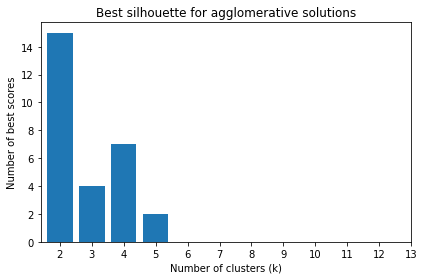

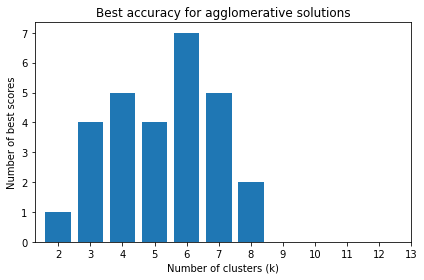

HIGH 



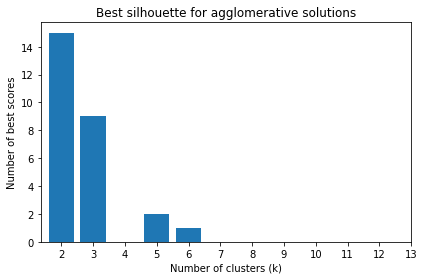

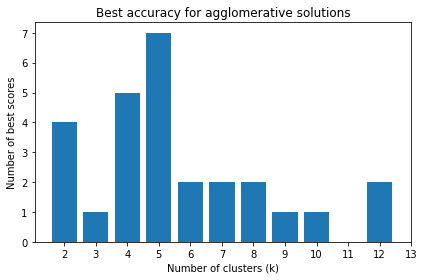

MALE 



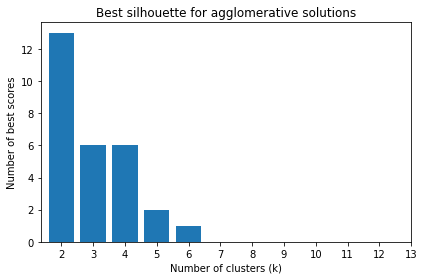

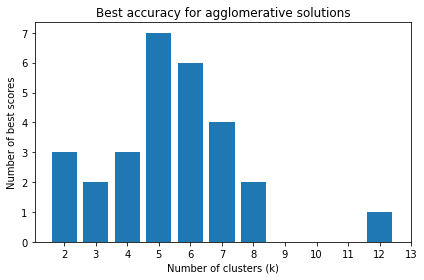

FEMALE 



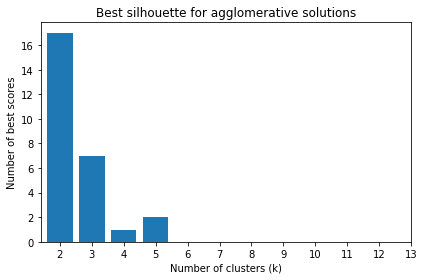

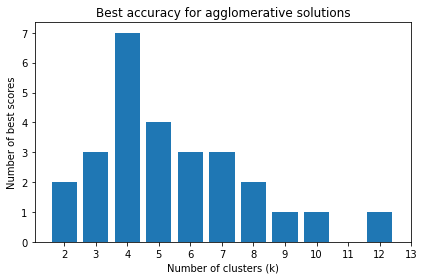

In [31]:
scores_by_condition = []
for i in range(len(indices_grouped_by_condition_groups)):
    if i<2: #ignore session and singer cond groups
        continue
    cond_group = indices_grouped_by_condition_groups[i]
    cond_group_name = group_names[i]
    for j in range(len(cond_group)):
        indices_of_cond = cond_group[j]
        cond_name = condition_names[i][j]
        scores = clustering.get_scores_for_cond_indices(h5_ram, indices_of_cond, cond_name, k_range, show_plots=True)
        scores_by_condition.append(scores)

### Make sil and acc scores for cond groups using k=5

In [32]:
acc_k5_by_singer_conds = []
for cond_idx, cond_indices in enumerate(indices_grouped_by_singer):
    acc_k5, _ = clustering.find_best_k_values(h5=h5_ram,
                       indices=cond_indices,
                       condition_name=singer_cond_names[cond_idx],
                       k=5,
                       cluster_algorithm='agglomerative',
                       score_type='accuracy',
                       show_plot=False,
                       save_plot=True)
    acc_k5_by_singer_conds.append(acc_k5)

acc_k5_by_reg_conds = []
for cond_idx, cond_indices in enumerate(indices_grouped_by_register):
    acc_k5, _ = clustering.find_best_k_values(h5=h5_ram,
                       indices=cond_indices,
                       condition_name=register_cond_names[cond_idx],
                       k=5,
                       cluster_algorithm='agglomerative',
                       score_type='accuracy',
                       show_plot=False,
                       save_plot=True)
    acc_k5_by_reg_conds.append(acc_k5)
    
acc_k5_by_gen_conds = []
for cond_idx, cond_indices in enumerate(indices_grouped_by_gender):
    acc_k5, _ = clustering.find_best_k_values(h5=h5_ram,
                       indices=cond_indices,
                       condition_name=gender_cond_names[cond_idx],
                       k=5,
                       cluster_algorithm='agglomerative',
                       score_type='accuracy',
                       show_plot=False,
                       save_plot=True)
    acc_k5_by_gen_conds.append(acc_k5)
    

sil_k5_by_singer_conds = []
for cond_idx, cond_indices in enumerate(indices_grouped_by_singer):
    sil_k5, _ = clustering.find_best_k_values(h5=h5_ram,
                       indices=cond_indices,
                       condition_name=singer_cond_names[cond_idx],
                       k=5,
                       cluster_algorithm='agglomerative',
                       score_type='silhouette',
                       show_plot=False,
                       save_plot=True)
    sil_k5_by_singer_conds.append(sil_k5)

sil_k5_by_reg_conds = []
for cond_idx, cond_indices in enumerate(indices_grouped_by_register):
    sil_k5, _ = clustering.find_best_k_values(h5=h5_ram,
                       indices=cond_indices,
                       condition_name=register_cond_names[cond_idx],
                       k=5,
                       cluster_algorithm='agglomerative',
                       score_type='silhouette',
                       show_plot=False,
                       save_plot=True)
    sil_k5_by_reg_conds.append(sil_k5)
    
sil_k5_by_gen_conds = []
for cond_idx, cond_indices in enumerate(indices_grouped_by_gender):
    sil_k5, _ = clustering.find_best_k_values(h5=h5_ram,
                       indices=cond_indices,
                       condition_name=gender_cond_names[cond_idx],
                       k=5,
                       cluster_algorithm='agglomerative',
                       score_type='silhouette',
                       show_plot=False,
                       save_plot=True)
    sil_k5_by_gen_conds.append(sil_k5)
    

sil_k5_all_data, _ = clustering.find_best_k_values(h5=h5_ram,
                       indices=all_indices,
                       condition_name='',
                       k=5,
                       cluster_algorithm='agglomerative',
                       score_type='silhouette',
                       show_plot=False,
                       save_plot=True)

acc_k5_all_data, _ = clustering.find_best_k_values(h5=h5_ram,
                       indices=all_indices,
                       condition_name='',
                       k=5,
                       cluster_algorithm='agglomerative',
                       score_type='accuracy',
                       show_plot=False,
                       save_plot=True)

###  acc and sil scores for k=5, test for normality

In [33]:
normality_test_wrapper(acc_k5_by_singer_conds, singer_cond_names, 'acc', show_plot=False)    
normality_test_wrapper(acc_k5_by_reg_conds, register_cond_names, 'acc', show_plot=False)
normality_test_wrapper(acc_k5_by_gen_conds, gender_cond_names, 'acc', show_plot=False)

variable: acc , condition name: m1 , - NORMAL DISTRIBUTION
variable: acc , condition name: m2 , - NOT NORMAL DISTRIBUTION
variable: acc , condition name: m4 , - NORMAL DISTRIBUTION
variable: acc , condition name: f2 , - NORMAL DISTRIBUTION
variable: acc , condition name: f3 , - NORMAL DISTRIBUTION
variable: acc , condition name: f5 , - NORMAL DISTRIBUTION
variable: acc , condition name: low , - NORMAL DISTRIBUTION
variable: acc , condition name: high , - NORMAL DISTRIBUTION
variable: acc , condition name: male , - NORMAL DISTRIBUTION
variable: acc , condition name: female , - NORMAL DISTRIBUTION


/Users/brendanoconnor/Desktop/phd/experiment1-voice_percetion/Mds4VoiceTimbre/4Github/statistical_analysis.py:201: UserWarning: Data sample size is less than minimal value {refuse_minimal}.
  warnings.warn('Data sample size is less than minimal value {refuse_minimal}.')


In [34]:
normality_test_wrapper(sil_k5_by_singer_conds, singer_cond_names, 'sil', show_plot=False)    
normality_test_wrapper(sil_k5_by_reg_conds, register_cond_names, 'sil', show_plot=False)
normality_test_wrapper(sil_k5_by_gen_conds, gender_cond_names, 'sil', show_plot=False)

variable: sil , condition name: m1 , - NORMAL DISTRIBUTION
variable: sil , condition name: m2 , - NORMAL DISTRIBUTION
variable: sil , condition name: m4 , - NORMAL DISTRIBUTION
variable: sil , condition name: f2 , - NORMAL DISTRIBUTION
variable: sil , condition name: f3 , - NOT NORMAL DISTRIBUTION
variable: sil , condition name: f5 , - NORMAL DISTRIBUTION
variable: sil , condition name: low , - NORMAL DISTRIBUTION
variable: sil , condition name: high , - NOT NORMAL DISTRIBUTION
variable: sil , condition name: male , - NORMAL DISTRIBUTION
variable: sil , condition name: female , - NOT NORMAL DISTRIBUTION


### acc and sil scores for k=5, Get distributional differences 

In [35]:
print(stats.f_oneway(acc_k5_by_reg_conds[0], acc_k5_by_reg_conds[1]))
print(stats.f_oneway(acc_k5_by_gen_conds[0], acc_k5_by_gen_conds[1]))
print(nonpara_multisample_stat_test(sil_k5_by_reg_conds, sig_thresh, register_cond_names))
print(nonpara_multisample_stat_test(sil_k5_by_gen_conds, sig_thresh, gender_cond_names))

F_onewayResult(statistic=0.2461040145434186, pvalue=0.6218829468460267)
F_onewayResult(statistic=0.7845203346360922, pvalue=0.3797633771063258)
no diff between samples low high
[None]
no diff between samples male female
[None]


### Check for normality of distributions of class pairwise distances

In [36]:
header = ('cond_group_name', 'class_pair_name', 'cond_name', 'stat', 'p', 'skewness')
sig_norm_results_csv = [header]
all_norm_results_csv = [header]

for group_idx, grouping in enumerate(rating_groups):
    
    if group_idx < 2: continue # ignore session and singer conditions
        
    # class_int refers to class_comparison_rating conditions index
    for class_int, class_comparison_ratings in enumerate(grouping):
        
        #condition_int refers to session_int
        for condition_int, relevant_sessions_group in enumerate(class_comparison_ratings):
            
            flattened_data = [rating for session in relevant_sessions_group for rating in session]
            stat, p, skewness = normality_stat_test(flattened_data, show_plot=False)
            
            cond_group_name = group_names[group_idx]
            class_pair_name = class_pairs[class_int]
            cond_name = condition_names[group_idx][condition_int]
            title = f'{cond_group_name, class_pair_name, cond_name}'
            
            if False:
                plt.hist(np.asarray(flattened_data), bins=15)
                # plt.title(title)
                plt.show()
                plt.close()
            
            all_norm_results_csv.append((cond_group_name, class_pair_name, cond_name, stat, p, skewness))
            if p > sig_thresh:
                sig_norm_results_csv.append((cond_group_name, class_pair_name, cond_name, stat, p, skewness))
            
print('sig_norm_results_csv', sig_norm_results_csv)

sig_norm_results_csv [('cond_group_name', 'class_pair_name', 'cond_name', 'stat', 'p', 'skewness')]


### Test effect of gender and register on class-pairwise-distances data

In [37]:
# get the class_pairwise distances for register and compare their distributions
cpd_for_csv = []

for class_pair_key in averaged_groups['intra_register_ratings'].keys():
    samples_list = []
    for cond_key in averaged_groups['intra_register_ratings'][class_pair_key].keys():
        samples = averaged_groups['intra_register_ratings'][class_pair_key][cond_key]
        samples_list.append(samples)
    results = nonpara_multisample_stat_test(samples_list,
                                                                   0.05,
                                                                   register_cond_names,
                                           print_all=False)
    if not results == [None]:
        cpd_for_csv.append([f'{label_list[class_pair_key[0]]}-{label_list[class_pair_key[1]]}',
                            float(results[0][0]),
                            round(float(results[0][1]), 4),
                            results[0][2].split(' ')[0] +'=' +str(round(float(results[0][2].split(' ')[-1]), 2)),
                            results[0][3].split(' ')[0] +'=' +str(round(float(results[0][3].split(' ')[-1]), 2)),
                            round(float(results[0][4].split(' ')[-1]), 2)
                           ])

cpd_header = ['PCD', 'U-value', 'p-value', 'Condition A', 'Condition B', 'Effect Size']
cpd_for_csv = sorted(cpd_for_csv, key=lambda x: x[2])
cpd_for_csv = [cpd_header] + cpd_for_csv
utils.list_to_csvfile(cpd_for_csv, './pairwise_class_distance_register_sig_diffs.csv')
cpd_for_csv

[['PCD', 'U-value', 'p-value', 'Condition A', 'Condition B', 'Effect Size'],
 ['belt-belt', 532.5, 0.0095, 'low=0.32', 'high=0.24', 0.41],
 ['straight-belt', 526.5, 0.0127, 'low=0.59', 'high=0.5', 0.39],
 ['fry-vibrato', 501.0, 0.0392, 'low=0.85', 'high=0.76', 0.33],
 ['belt-vibrato', 497.0, 0.046, 'low=0.56', 'high=0.47', 0.31]]

In [38]:
# get the class_pairwise distances for gender and compare their distributions

cpd_for_csv = []


for class_pair_key in averaged_groups['intra_gender_ratings'].keys():
    samples_list = []
    for cond_key in averaged_groups['intra_gender_ratings'][class_pair_key].keys():
        samples = averaged_groups['intra_gender_ratings'][class_pair_key][cond_key]
        samples_list.append(samples)
    results = nonpara_multisample_stat_test(samples_list,
                                                                   0.05,
                                                                   gender_cond_names,
                                           print_all=False)
    if not results == [None]:
        cpd_for_csv.append([f'{label_list[class_pair_key[0]]}-{label_list[class_pair_key[1]]}',
                            float(results[0][0]),
                            round(float(results[0][1]), 4),
                            results[0][2].split(' ')[0] +'=' +str(round(float(results[0][2].split(' ')[-1]), 2)),
                            results[0][3].split(' ')[0] +'=' +str(round(float(results[0][3].split(' ')[-1]), 2)),
                            round(float(results[0][4].split(' ')[-1]), 2)
                           ])
    
cpd_header = ['PCD', 'U-value', 'p-value', 'Condition A', 'Condition B', 'Effect Size']
cpd_for_csv = sorted(cpd_for_csv, key=lambda x: x[2])
cpd_for_csv = [cpd_header] + cpd_for_csv
utils.list_to_csvfile(cpd_for_csv, './pairwise_class_distance_gender_sig_diffs.csv')
cpd_for_csv

[['PCD', 'U-value', 'p-value', 'Condition A', 'Condition B', 'Effect Size'],
 ['straight-breathy', 575.0, 0.0009, 'male=0.7', 'female=0.47', 0.52],
 ['fry-vibrato', 205.0, 0.0037, 'male=0.72', 'female=0.91', -0.46],
 ['vibrato-vibrato', 226.5, 0.011, 'male=0.11', 'female=0.22', -0.4],
 ['breathy-breathy', 234.0, 0.0157, 'male=0.09', 'female=0.2', -0.38],
 ['belt-fry', 257.5, 0.0433, 'male=0.67', 'female=0.82', -0.32]]

## Testing effects of Between-Participant Conditions

### Spearmans rank correlation between all participant features

('Instrumentation', 'MSI', 0.48, 0.00020309564701750818)
using box plot


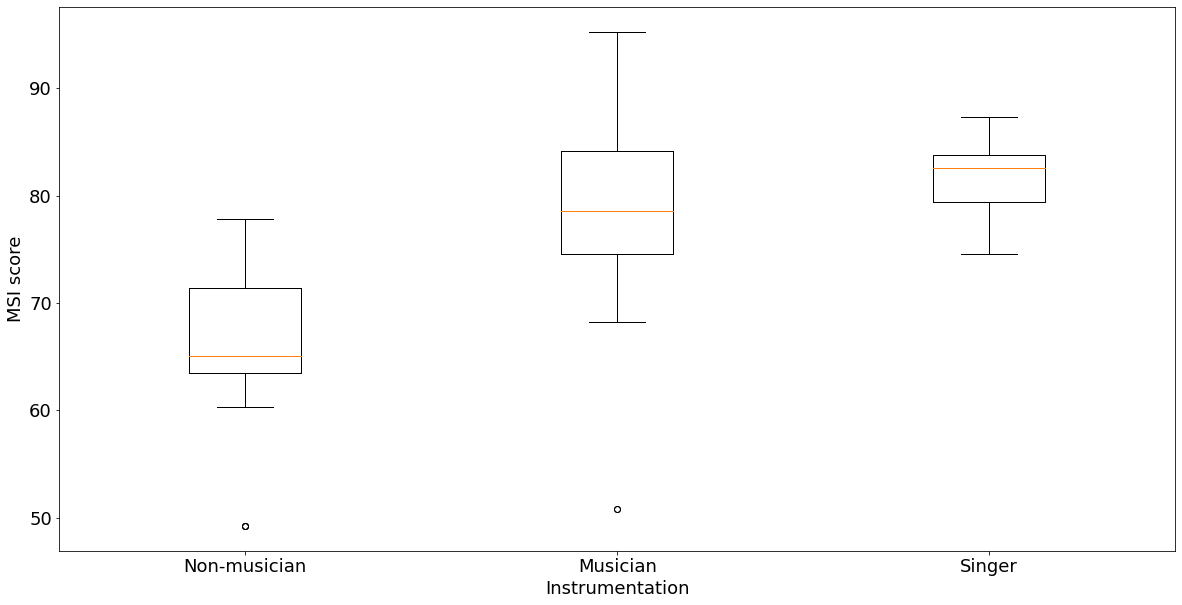

('Instrumentation', 'Silhouette', 0.27, 0.048071358185777215)
using box plot


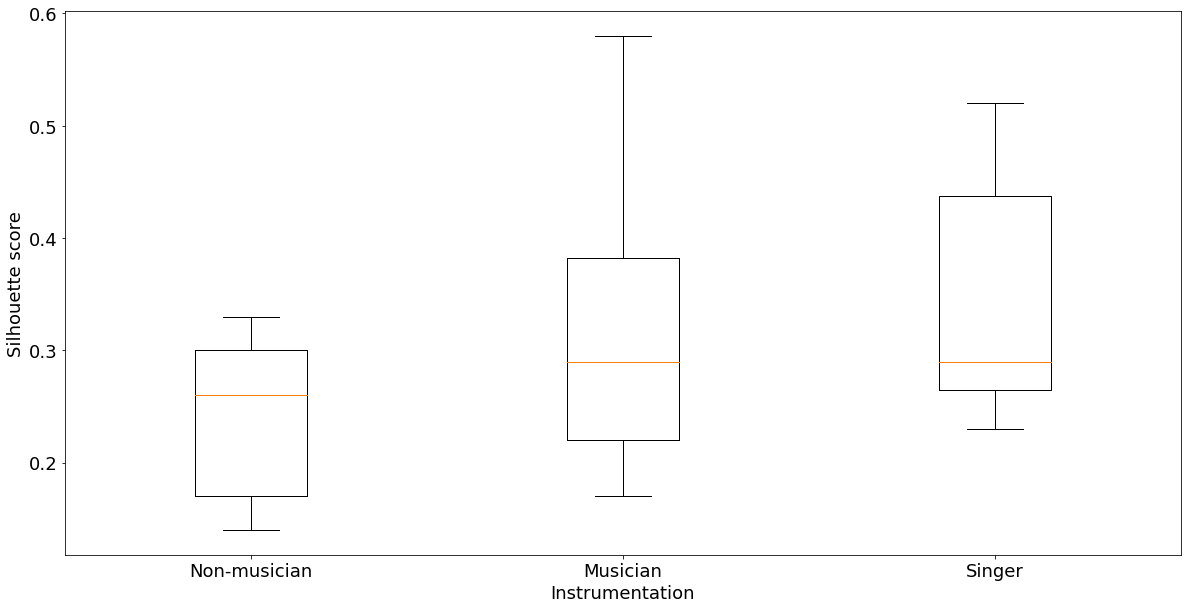

('Instrumentation', 'Accuracy', 0.47, 0.00026884671057892604)
using box plot


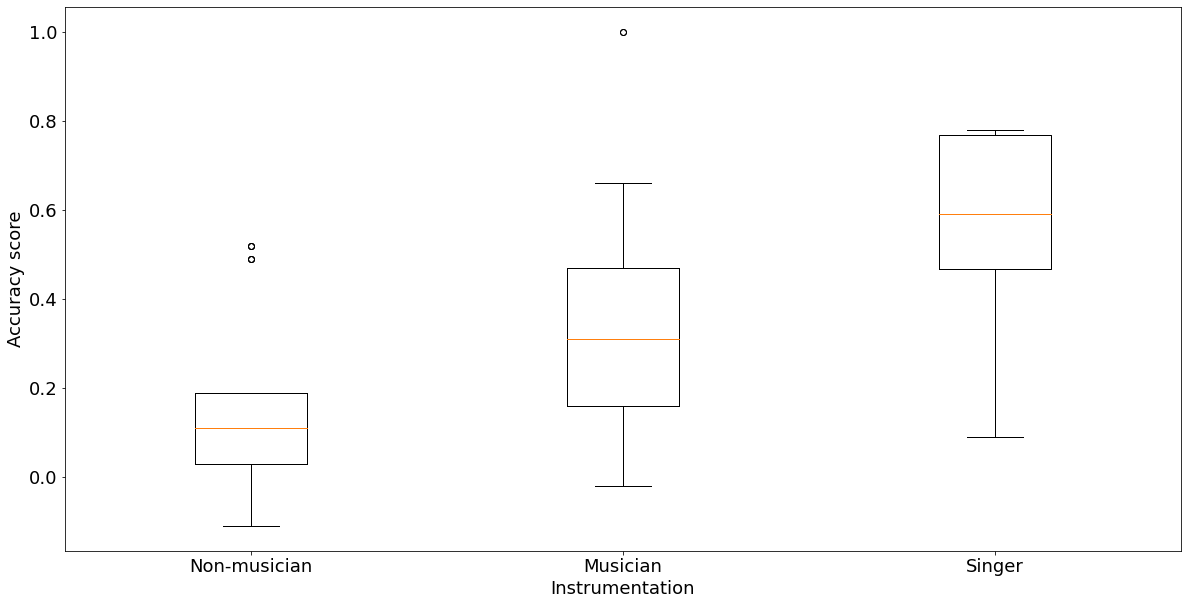

('MSI', 'Silhouette', 0.36, 0.006460363991546038)


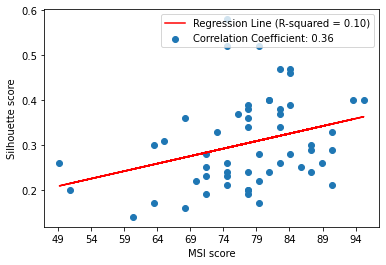

('MSI', 'Accuracy', 0.47, 0.00030136490467941454)


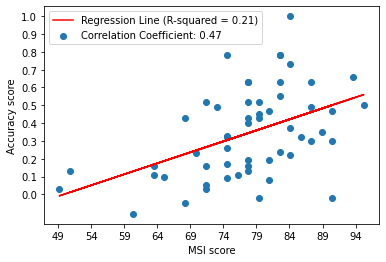

('Silhouette', 'Accuracy', 0.62, 4.504228444096923e-07)


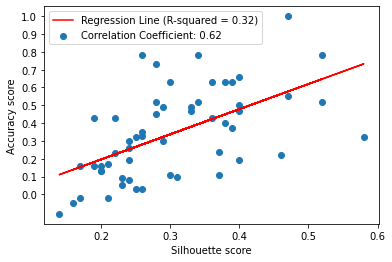

In [39]:
# print(profile_array.shape, km_sil_scores.reshape(-1,1).shape)
participant_feats_no_km = np.concatenate((profile_array,
                    sil_k5_all_data.reshape(-1,1),
                    acc_k5_all_data.reshape(-1,1)),
               axis=1)
# print(participant_feats_no_agg.shape)

correlation_dict, correlation_list = array_column_correlations(
    participant_feats_no_km,
    profile_label_names + ['Silhouette score', 'Accuracy score'],
    profile_label_dict,
    0.05,
    'spearmanr',
    show_plot=True,
    save_plot=True)

len(correlation_dict)

header = ['feature A', 'feature B', 'correlation', 'p-value']
sorted_correlation_list = sorted(correlation_list, key=lambda x: x[3])
utils.list_to_csvfile([header] + sorted_correlation_list, './spearman_05_significance_for_participant_features.csv')

('Instrumentation', 'MSI', 0.48, 0.00022706654476280824)
using box plot


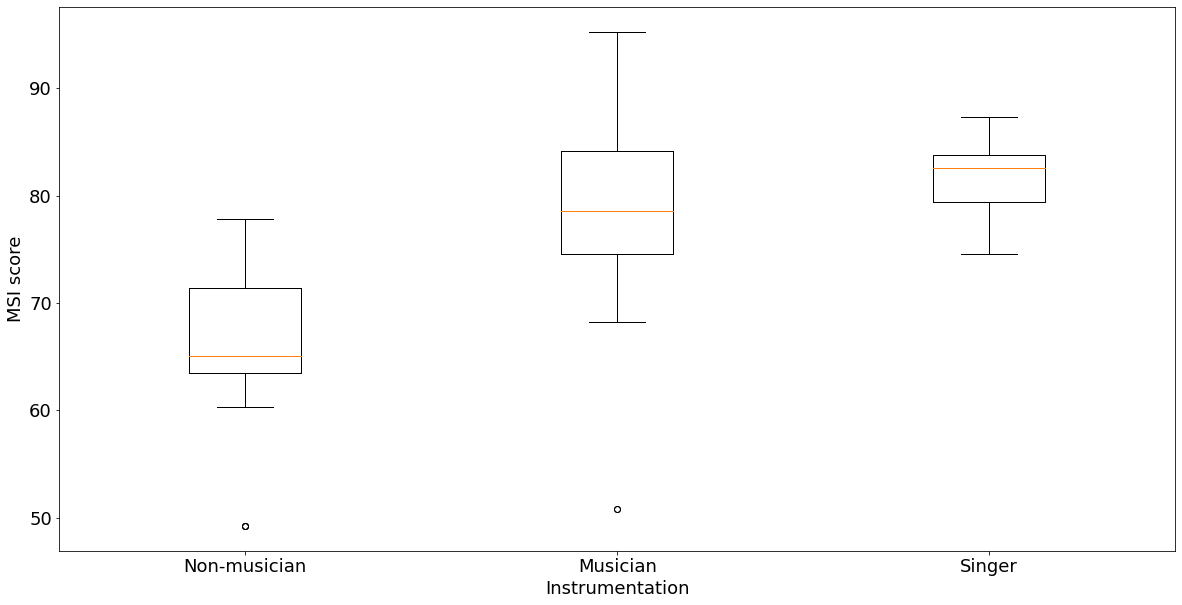

('Instrumentation', 'Silhouette', 0.3, 0.028012720948217187)
using box plot


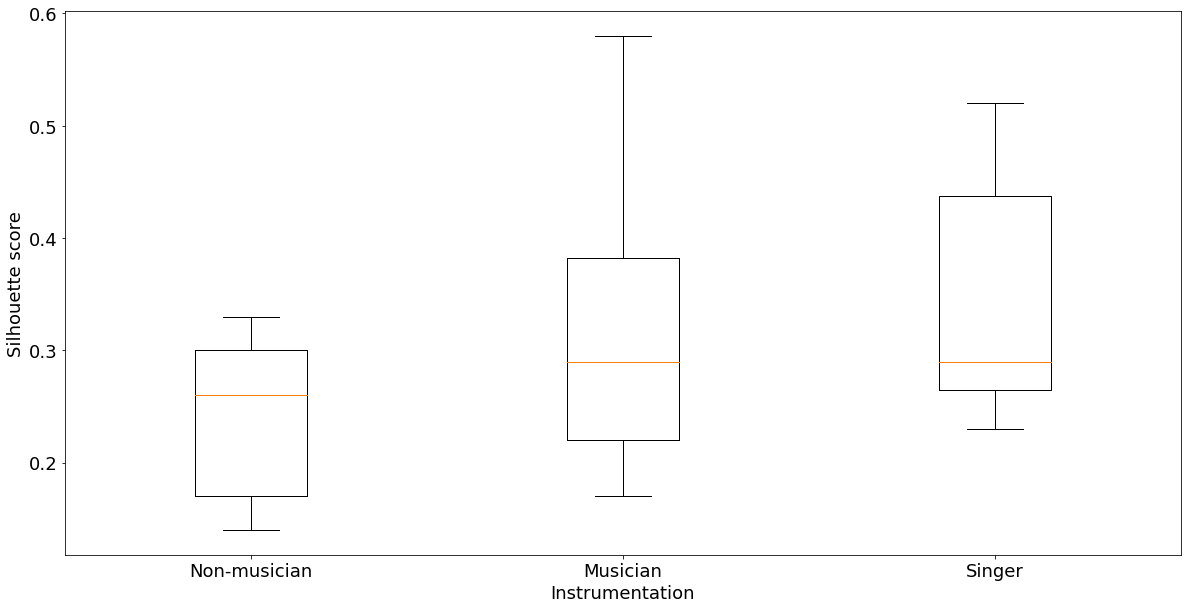

('Instrumentation', 'Accuracy', 0.48, 0.00020806876938091008)
using box plot


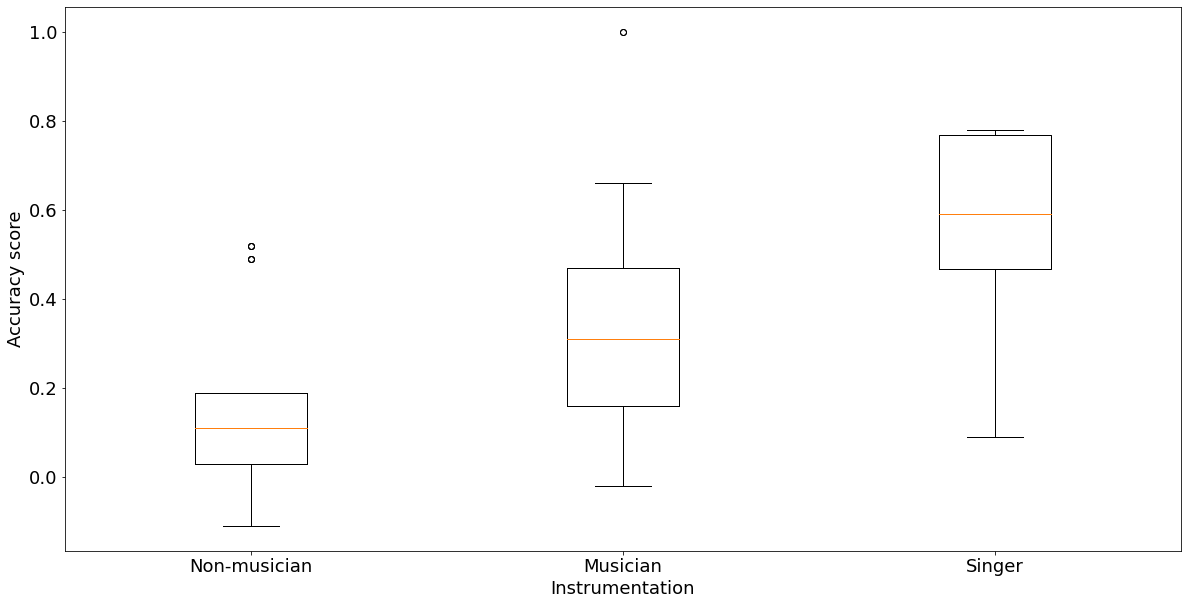

('MSI', 'Silhouette', 0.31, 0.02105498439036646)


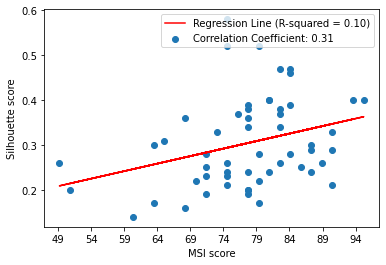

('MSI', 'Accuracy', 0.46, 0.00039213754727353853)


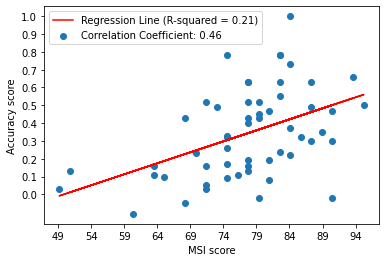

('Poor', 'Silhouette', -0.27, 0.04783620686650383)


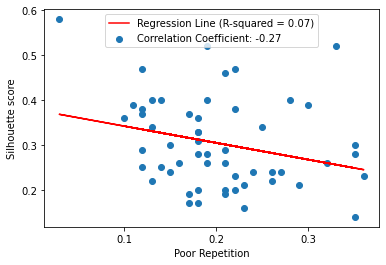

('Silhouette', 'Accuracy', 0.57, 5.896863621661858e-06)


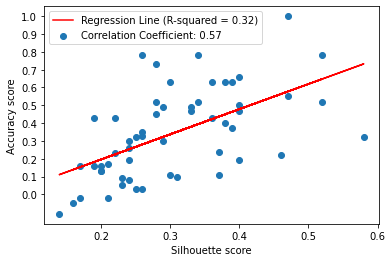

7

In [40]:
correlation_dict, correlation_list = array_column_correlations(
    participant_feats_no_km,
    profile_label_names + ['Silhouette score', 'Accuracy score'],
    profile_label_dict,
    0.05,
    'pearsonr',
    show_plot=True,
    save_plot=True)
len(correlation_dict)

## Testing for diffs in distributions

### Generate data for k=5, and group by music condition

9
Size of sample is 9


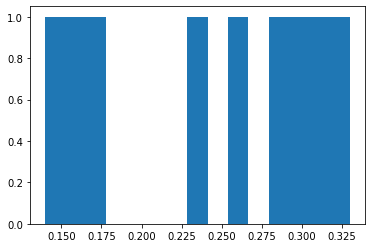

Size of sample is 9


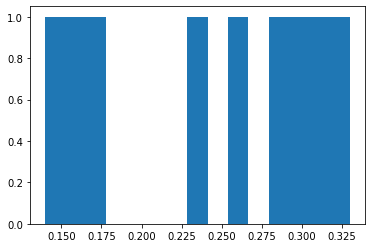

(0.9075505137443542, 0.29910555481910706, -0.3375282952446721)
36
Size of sample is 36


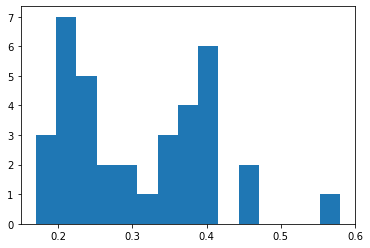

Size of sample is 36


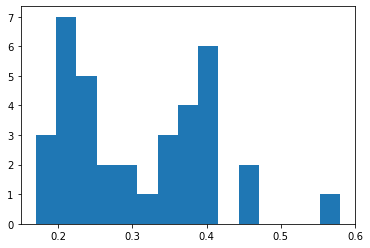

(0.9208859801292419, 0.013365870341658592, 0.5673930763371807)
10
Size of sample is 10


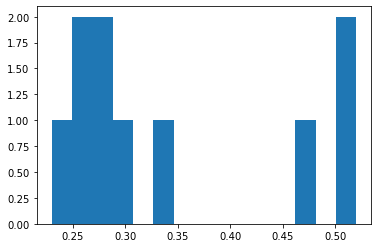

Size of sample is 10


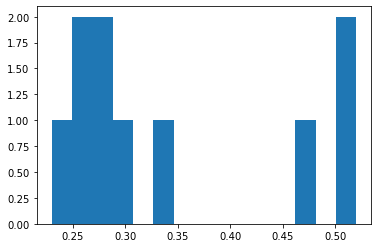

(0.8138577938079834, 0.02135484665632248, 0.71561150026718)
9
Size of sample is 9


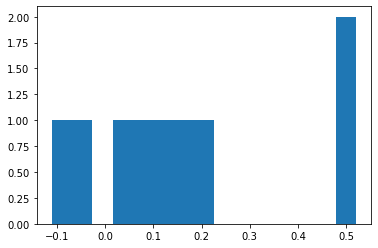

Size of sample is 9


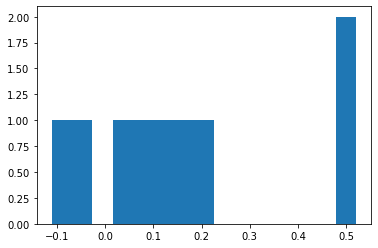

(0.8970442414283752, 0.23536339402198792, 0.6564762271968343)
36
Size of sample is 36


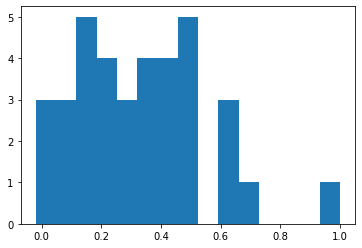

Size of sample is 36


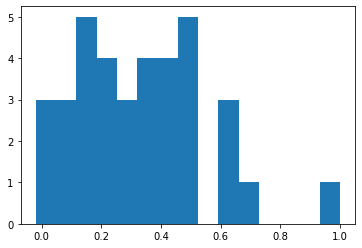

(0.9591471552848816, 0.20230358839035034, 0.6801756470628538)
10
Size of sample is 10


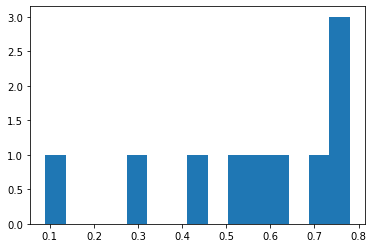

Size of sample is 10


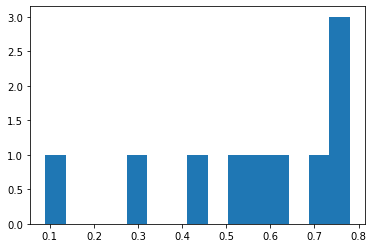

(0.888144314289093, 0.16159361600875854, -0.8415918058734562)


In [41]:
sil_5k_by_instruments = [[],[],[]]
acc_5k_by_instruments = [[],[],[]]

for idx, prof_arr in enumerate(profile_array):
    music_cat_id = int(prof_arr[2])
    sil_5k_by_instruments[music_cat_id].append(sil_k5_all_data[idx])  
    acc_5k_by_instruments[music_cat_id].append(acc_k5_all_data[idx])
    
music_cond_names = ['nonmus', 'mus', 'vocal']

for sample in sil_5k_by_instruments:
    print(len(sample))
    show_hist(sample)
    print(normality_stat_test(sample, refuse_minimal=9))
    
for sample in acc_5k_by_instruments:
    print(len(sample))
    show_hist(sample)
    print(normality_stat_test(sample, refuse_minimal=9))

In [42]:
print('results from sil_5k_by_instruments')
results = nonpara_multisample_stat_test(sil_5k_by_instruments, sig_thresh, music_cond_names)
print()
print('results from acc_5k_by_instruments')
results = nonpara_multisample_stat_test(acc_5k_by_instruments, sig_thresh, music_cond_names)

results from sil_5k_by_instruments
no diff between samples nonmus mus
no diff between samples nonmus vocal
no diff between samples mus vocal

results from acc_5k_by_instruments
no diff between samples nonmus mus
(10.5, 0.005399235727352161, 'nonmus median: 0.11', 'vocal median: 0.5900000000000001', 'effect: -0.7666666666666667')
(76.5, 0.006048715941597175, 'mus median: 0.31', 'vocal median: 0.5900000000000001', 'effect: -0.575')


# Generate MDS plots

In [43]:
print(averaged_groups.keys())
print(averaged_groups['intra_register_ratings'].keys())
print(averaged_groups['intra_register_ratings'][(0, 1)].keys())
print(averaged_groups['intra_register_ratings'][(0, 1)]['low'])

dict_keys(['intra_register_ratings', 'intra_gender_ratings'])
dict_keys([(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)])
dict_keys(['low', 'high'])
[0.4722222222222221, 0.74, 0.5666666666666667, 0.23000000000000004, 0.6244444444444446, 0.6716666666666667, 0.5788888888888888, 0.7977777777777778, 0.7733333333333333, 0.8044444444444444, 0.4283333333333333, 0.3111111111111111, 0.7277777777777779, 0.6644444444444445, 0.5966666666666667, 0.6916666666666668, 0.5077777777777778, 0.635, 0.5444444444444445, 0.8066666666666666, 0.8344444444444443, 0.44777777777777783, 0.4088888888888889, 0.5455555555555556, 0.6633333333333333, 0.3022222222222222, 0.36000000000000004, 0.5433333333333333]


### MDS for register conditions

USING MEDIANS
registers


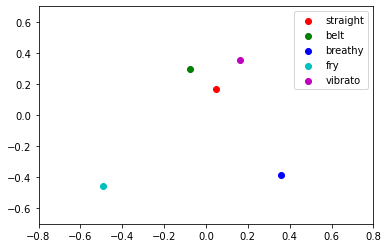

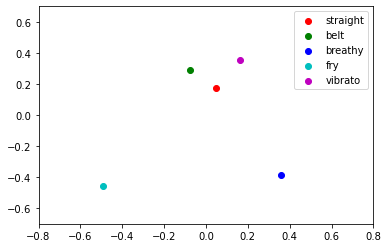

genders


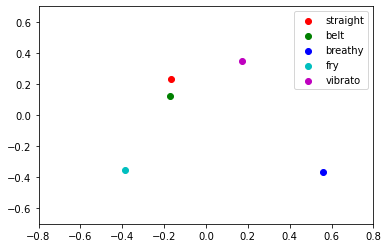

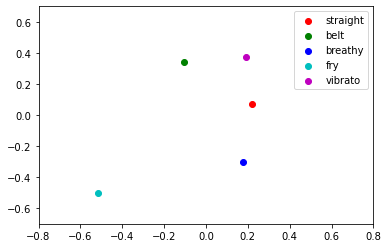

In [44]:
print('USING MEDIANS')
print('registers')
register_classpair, register_mds = summarize_cond_grouped_ratings_mds(averaged_groups['intra_register_ratings'],
                                                        'median',
                                                        register_cond_names,
                                                        class_pairs,
                                                        label_list,
                                                        mds_dim=2,
                                                        show_plot=True)
print('genders')
register_classpair, gender_mds = summarize_cond_grouped_ratings_mds(averaged_groups['intra_gender_ratings'],
                                                        'median',
                                                        gender_cond_names,
                                                        class_pairs,
                                                        label_list,
                                                        mds_dim=2,
                                                        show_plot=True)